# Coursework 2: Robotic behavioural cloning from images and actuator data

## Description
For this coursework, you are required to develop a behaviour cloning model. Behaviour cloning is a technique for training robotic agents using a dataset of sequences of actions. Consider the supervised learning definition where we have a dataset of observatios $d=\{(x_{1},y_{1}),...,(x_{n},y_{n})\}$ and the aim is to learn a function: $f:\mathcal{X}\rightarrow\mathcal{Y}$. In this case, $\mathcal{X}$ is the set of "observations" that the robot makes and $\mathcal{Y}$ is the set of actions that the robot takes.

The dataset you have been provided with contains examples of robot arms being required to pickup objects or drop objects (given it has already picked the object up) in a specific place. The observation space ($\mathcal{X}$) consists of:
- "front_cam_ob": A 3rd person image of the scene 
- "mount_cam_ob": An image of the scene taken from a camera mounted on top of the robotic arm, looking down
- "ee_cartesian_pos_ob": The positional and orientation co-ordinates of the robotic arm
- "ee_cartesian_vel_ob": The velocity of position and orientation of the robotic arm
- "joint_pos_ob": The position of the gripper which opens and closes

The action space ($\mathcal{Y}$) consists of:
- Three co-ordinates defining how much to move the robotic arm
- An action defining whether to open, not to move or close the gripper

The dataset is split into "trajectories" i.e., sequences of:
- $x_{i}$: The front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob, joint_pos_ob __at time point i__ 
- $y_{i}$: The action taken i.e., how to move the arm and the gripper __given the observations__ in $x_{i}$

More information on the dataset can be found at: https://github.com/clvrai/clvr_jaco_play_dataset?tab=readme-ov-file

### Task
Your task has been split into several questions, each exploring how to develop an appropriate model for learning $f:\mathcal{X}\rightarrow\mathcal{Y}$. The task will require you to:
- Question 1: Tune an end-to-end supervised learning model taking in the full set of observations and predicting actions: You will be required to evaluate a proposed deep learning architecture (which takes as input all of front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob and predict the two actions) and propose a new model which outperforms the existing model;
- Question 2: Define and evaluate a VAE model for performing self-supervised learning and tune it as best you can, to learn a latent representation that can be used as input to a downstream supervised model for behaviour cloning
- Question 3: Evaluate the performance of your model proposed in question 1 against your self-supervised VAE representations from question 2 (plus a supervised head) on the test set

### Pointers
Some helper functions have been provided for you including the following functionality:
- A training and validation loop capabale of:
  - Handling "half-precision" modelling;
  - Logging results to weights and biases;
- An eda template to help you visualise the data
- An evaluation template to help you load saved model checkpoints from weights and biases
- A preprocessing script to help you convert the data into train/validation and test splits;
  - In this preprocessing script, trajectories longer than 75 timesteps have been removed to ease the computational requirements of the task;
- A torch Dataset class capable of handling the multi-model nature of the data;
- A example collate_fn to use in Dataloaders

Additionally, it is strongly suggested to call ```torch.manual_seed(1)``` whenever you initialise your model (i.e., when you first create the model or call model.reset()). This will ensure the parameters are initialised at the same value each time.

### IMPORTANT
- You are __not__ allowed to use pre-trained models, developed outside of this coursework i.e., you could __not__ use a pre-trained YOLO model
- Questions have been marked under the title "Task", ensure that you answer/address all of the bullet points under these headings


## Data download
Download the data for the project from here: https://drive.usercontent.google.com/download?id=1tVSilmXhyQd8gxZAEhvKMnynw0qzRFSZ&authuser=0

Save the data locally at: ../data/all_play_data_diverse or in Google Collab at: /content/drive/MyDrive/comp0188_2425/cw2. Saving the data in these locations will ensure the proprocessing script provided runs correctly. If you would like to alter these locations, you can alter them in the config.py file of the provided comp0188_cw2 package via the ROOT_PATH global variable.

### transition_df.csv
You have additionally been provided with a csv called "transition_df.csv". This contains a row for each observation/action pair in the dataset and is used to generate the train/validation and test datasets for this task. Note that this csv contains all trajectories (even those over 75 timesteps). This csv might also be useful for EDA. The transition_df.csv should be placed in the same folder that you placed the raw data in (discussed above).

## Imports

The comp0188_cw2 contains some config functionality so that you can run the code in collab and locally (to test models)! When you first import the package, import the project_options and set the appropriate configs.
- project_options.collab = True will set the dataset directories for google collab whilst false will set suitable local directories
- project_options.debug = True will load a subset of data whilst False will load all of the data. 

__IMPORTANT__: Alterting these options __once you have loaded other functionality__ from comp0188_cw2 may result in unintended outcomes.

In [1]:
COLLAB = False
if COLLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install --force-reinstall git+https://github.com/joshuaspear/pymlrf.git
    !pip install wandb
    !pip install torchinfo
    !pip install jaxtyping
    !pip install git+https://github.com/joshuaspear/comp0188_cw2_public.git
    !pip install typeguard==2.13.3

Ignore the error: 
```ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.```

In [2]:
from comp0188_cw2 import project_options
project_options.collab = COLLAB
print(project_options.collab)
project_options.debug = False
print(project_options.debug)

False
False


In [3]:
import psutil
import pynvml

# CPU details using psutil
cpu_freq = psutil.cpu_freq()
cpu_count = psutil.cpu_count(logical=False)
logical_cpu_count = psutil.cpu_count(logical=True)
print(f"CPU Frequency: {cpu_freq.max:.2f} MHz")
print(f"Physical CPU Cores: {cpu_count}")
print(f"Logical CPU Cores: {logical_cpu_count}")

# GPU details using pynvml
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
gpu_name = pynvml.nvmlDeviceGetName(handle)
gpu_memory_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
print(f"GPU Name: {gpu_name}")
print(f"Total Memory: {gpu_memory_info.total / (1024**2):.2f} MB")
print(f"Free Memory: {gpu_memory_info.free / (1024**2):.2f} MB")
print(f"Used Memory: {gpu_memory_info.used / (1024**2):.2f} MB")
pynvml.nvmlShutdown()


CPU Frequency: 4716.67 MHz
Physical CPU Cores: 16
Logical CPU Cores: 24
GPU Name: NVIDIA GeForce RTX 3090 Ti
Total Memory: 24564.00 MB
Free Memory: 10759.19 MB
Used Memory: 13804.81 MB


In [4]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import DataLoader, Sampler, WeightedRandomSampler
import datetime
from pymlrf.Structs.torch import DatasetOutput
import copy
from collections import Counter
from IPython.display import display, HTML
from typing import List
from wandb import Artifact

from comp0188_cw2.utils import load_all_files
from comp0188_cw2.config import (FILE_PATH, ROOT_PATH,
    train_dh, val_dh, test_dh, WANDB_PROJECT
    )
from comp0188_cw2.models.CNNConfig import ConvolutionLayersConfig
from comp0188_cw2.models.base import BaseModel
from comp0188_cw2.models.JointCNNEncoder import JointCNNEncoder
from comp0188_cw2.models.CNN import CNN
from comp0188_cw2.models.MLP import MLP
from comp0188_cw2.Metric.WandBMetricOrchestrator import WandBMetricOrchestrator
from comp0188_cw2.Dataset.NpDictDataset import NpDictDataset
from comp0188_cw2.Loss.BalancedLoss import TrackerBalancedLoss
from comp0188_cw2 import logger
from comp0188_cw2.training.TrainingLoop import TorchTrainingLoop

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

2024-12-14 10:36:48,897 - pymlrf - WARNING - pymlrf environment variable not set. Logging to file will not be performed (__init__.py:47)


In [5]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'CW2_Questions_105_marks_QUESTIONS_2.ipynb'

In [6]:
print(train_dh.loc)

../data/all_play_data_diverse/train


## Build the dataset
You will only need to perform this step __once__ for the full dataset and __once__ for the debug dataset for the entire coursework, both locally and in Google collab. In Google Collab, the data will be saved in your Google Drive.

In [7]:
from comp0188_cw2.Preprocessing import main
RUN_PREPROCESSING = False
if RUN_PREPROCESSING:
  main()

In [8]:
def additional_preprocessing(ROOT_PATH, train_nps, val_nps, test_nps):
    # Load the transition dataframe
    tran_df = pd.read_csv(os.path.join(ROOT_PATH, "transition_df.csv"))
    tran_df_sub = tran_df[tran_df["episode_length"] < 75]
    print(tran_df_sub.shape)
    print(f"Transitions excluded: {(tran_df.shape[0]-tran_df_sub.shape[0])/tran_df.shape[0]}")

    # Split the episodes
    _train_idx, test_idx = train_test_split(
        tran_df_sub["episode"].unique(),
        test_size=0.2,
        random_state=1
    )

    train_idx, val_idx = train_test_split(
        _train_idx,
        test_size=0.1,
        random_state=1
    )

    # Assign split labels
    tran_df_sub["is_test"] = np.where(
        tran_df_sub["episode"].isin(test_idx),
        1,
        0
    )
    tran_df_sub["is_val"] = np.where(
        tran_df_sub["episode"].isin(val_idx),
        1,
        0
    )
    tran_df_sub["is_train"] = (1 - tran_df_sub[["is_test", "is_val"]].max(axis=1))

    # Filter the DataFrames for each split
    train_nps_episodes = tran_df_sub[tran_df_sub["is_train"] == 1]
    val_nps_episodes = tran_df_sub[tran_df_sub["is_val"] == 1]
    test_nps_episodes = tran_df_sub[tran_df_sub["is_test"] == 1]

    # Rename the 'terminated' column to 'terminals'
    train_nps_episodes = train_nps_episodes.rename(columns={'terminated': 'terminals'})
    val_nps_episodes = val_nps_episodes.rename(columns={'terminated': 'terminals'})
    test_nps_episodes = test_nps_episodes.rename(columns={'terminated': 'terminals'})

    # Columns to drop (excluding 'terminated' since it has been renamed)
    columns_to_drop = ['reward', 'max_reward', 'is_test', 'is_val', 'is_train']

    # Drop the specified columns from each DataFrame
    train_nps_episodes = train_nps_episodes.drop(columns=columns_to_drop, errors='ignore')
    val_nps_episodes = val_nps_episodes.drop(columns=columns_to_drop, errors='ignore')
    test_nps_episodes = test_nps_episodes.drop(columns=columns_to_drop, errors='ignore')

    # Check if the number of unique episodes is the same as the number of terminals
    train_unique_episodes = train_nps_episodes['episode'].nunique()
    train_terminals_count = train_nps_episodes['terminals'].sum()

    val_unique_episodes = val_nps_episodes['episode'].nunique()
    val_terminals_count = val_nps_episodes['terminals'].sum()

    test_unique_episodes = test_nps_episodes['episode'].nunique()
    test_terminals_count = test_nps_episodes['terminals'].sum()

    print(f"Train - Unique Episodes: {train_unique_episodes}, Terminals Count: {train_terminals_count}")
    print(f"Validation - Unique Episodes: {val_unique_episodes}, Terminals Count: {val_terminals_count}")
    print(f"Test - Unique Episodes: {test_unique_episodes}, Terminals Count: {test_terminals_count}")

    # Ensure the counts match
    assert train_unique_episodes == train_terminals_count, "Mismatch in train episodes and terminals count"
    assert val_unique_episodes == val_terminals_count, "Mismatch in validation episodes and terminals count"
    assert test_unique_episodes == test_terminals_count, "Mismatch in test episodes and terminals count"

    # Amend the episode_length column for train_nps_episodes
    train_nps_episodes['episode_length'] = train_nps_episodes.groupby('episode').cumcount() + 1

    # Amend the episode_length column for val_nps_episodes
    val_nps_episodes['episode_length'] = val_nps_episodes.groupby('episode').cumcount() + 1

    # Amend the episode_length column for test_nps_episodes
    test_nps_episodes['episode_length'] = test_nps_episodes.groupby('episode').cumcount() + 1

    # Merging the datasets
    train_nps.update(train_nps_episodes)
    val_nps.update(val_nps_episodes)
    test_nps.update(test_nps_episodes)

    # Function to convert specific columns to numpy arrays
    def convert_to_numpy(data_dict, columns):
        for column in columns:
            if column in data_dict and isinstance(data_dict[column], pd.Series):
                data_dict[column] = data_dict[column].to_numpy()

    # Columns to convert
    columns_to_convert = ['episode', 'episode_length', 'terminals']

    # Convert columns in each dataset
    convert_to_numpy(train_nps, columns_to_convert)
    convert_to_numpy(val_nps, columns_to_convert)
    convert_to_numpy(test_nps, columns_to_convert)

    # Function to check the type of each item and add an extra dimension to specific keys
    def check_data_type(data_dict):
        for key, value in data_dict.items():
            if isinstance(value, np.ndarray):
                if key in ["terminals", "episode", "episode_length"]:
                    value = value[:, np.newaxis]  # Add an extra dimension
                    data_dict[key] = value  # Update the dictionary with the reshaped array
                # print(f"{key}: Numpy array with shape {value.shape}")
            elif isinstance(value, pd.DataFrame):
                # print(f"{key}: Pandas DataFrame with shape {value.shape}")
                pass
            else:
                # print(f"{key}: Unknown type {type(value)}")
                pass

    # Checking the data types in each dataset and adding an extra dimension where needed
    # print("Train dataset:")
    check_data_type(train_nps)

    # print("\nValidation dataset:")
    check_data_type(val_nps)

    # print("\nTest dataset:")
    check_data_type(test_nps)

    return train_nps, val_nps, test_nps

## Question 1: Tune an end-to-end supervised learning model taking in the full set of observations and predicting actions

In [9]:
_keys = [
    "actions","front_cam_ob",
    "mount_cam_ob","terminals",
    "ee_cartesian_pos_ob",
    "ee_cartesian_vel_ob",
    "joint_pos_ob"
    ]
train_nps = load_all_files(train_dh.loc,"train_[0-9]+.h5",keys=_keys)
val_nps = load_all_files(val_dh.loc,"val_[0-9]+.h5",keys=_keys)
test_nps = load_all_files(test_dh.loc,"test_[0-9]+.h5",keys=_keys)

100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


In [10]:
train_nps, val_nps, test_nps = additional_preprocessing(ROOT_PATH, train_nps, val_nps, test_nps)

(35722, 5)
Transitions excluded: 0.5418200474571924
Train - Unique Episodes: 453, Terminals Count: 453
Validation - Unique Episodes: 51, Terminals Count: 51
Test - Unique Episodes: 126, Terminals Count: 126


/tmp/ipykernel_83025/1653985452.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tran_df_sub["is_test"] = np.where(
/tmp/ipykernel_83025/1653985452.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tran_df_sub["is_val"] = np.where(
/tmp/ipykernel_83025/1653985452.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [11]:
# Function to compute mean and std
def compute_mean_std(data):
    tensor_data = torch.tensor(data)
    mean = tensor_data.mean(dim=0)
    std = tensor_data.std(dim=0)
    return mean, std

# Compute mean and std for each observation type
actions_mean, actions_std = compute_mean_std(train_nps["actions"])
ee_cartesian_pos_ob_mean, ee_cartesian_pos_ob_std = compute_mean_std(train_nps["ee_cartesian_pos_ob"])
ee_cartesian_vel_ob_mean, ee_cartesian_vel_ob_std = compute_mean_std(train_nps["ee_cartesian_vel_ob"])
joint_pos_ob_mean, joint_pos_ob_std = compute_mean_std(train_nps["joint_pos_ob"])

# Print the computed means and standard deviations on one line
print("Actions mean:", actions_mean, "Actions std:", actions_std)
print("EE Cartesian Position mean:", ee_cartesian_pos_ob_mean, "EE Cartesian Position std:", ee_cartesian_pos_ob_std)
print("EE Cartesian Velocity mean:", ee_cartesian_vel_ob_mean, "EE Cartesian Velocity std:", ee_cartesian_vel_ob_std)
print("Joint Position mean:", joint_pos_ob_mean, "Joint Position std:", joint_pos_ob_std)

Actions mean: tensor([-1.7729e-03, -7.5245e-04, -7.1716e-03,  1.0078e+00],
       dtype=torch.float16) Actions std: tensor([0.1115, 0.1013, 0.1181, 0.4980], dtype=torch.float16)
EE Cartesian Position mean: tensor([-0.0796, -0.4280,  0.2666,  0.0044, -0.0159,  0.9912,  0.1274],
       dtype=torch.float16) EE Cartesian Position std: tensor([0.1329, 0.0852, 0.0474, 0.0093, 0.0156, 0.0021, 0.0164],
       dtype=torch.float16)
EE Cartesian Velocity mean: tensor([-0.0007, -0.0024, -0.0084,  0.0016, -0.0123,  0.0034],
       dtype=torch.float16) EE Cartesian Velocity std: tensor([0.1348, 0.1143, 0.1311, 0.1428, 0.6172, 0.2693], dtype=torch.float16)
Joint Position mean: tensor([0.8843, 0.8667], dtype=torch.float16) Joint Position std: tensor([0.3188, 0.3171], dtype=torch.float16)


### Question 1.a Preprocessing
Most likely in machine learning pipelines, input data needs to be preprocessed before passing it to the model. This question requires you to specify the preprocessing that you will perform for the different types of data i.e., front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob. The dataset class provided in the associated "comp0188_cw2" package enables you to pass a dictionary of functions to preprocess each element of the observations and actions. The class expects a dictionary of transformations to apply to each input/output. 

#### Question 1.a.i Preprocessing steps (5 marks)

##### Task
- Complete the dictionaries below, specifying the type of transformations you wish to perform. For each element (of the observations and actions), you should __at least__ convert the output to a tensor thus, these transformations have been implemented for you. You may alter __any__ part of the code between the "INSERT YOUR CODE HERE" comments

In [12]:
# ******* INSERT YOUR CODE HERE *******

# Function to normalize data
def normalize(tensor, mean, std):
    return (tensor - mean) / std

# Function to create sine and cosine features
def create_sin_cos_features(x, max_length):
    sin_feature = torch.sin(2 * torch.pi * x / max_length)
    cos_feature = torch.cos(2 * torch.pi * x / max_length)
    return torch.stack([sin_feature, cos_feature], dim=-1)

# Define the augmentations
image_augmentations_front = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)), # Randomly crop the 224 x 224 images to between 80% and 100% of the original size
    transforms.ColorJitter(brightness=0.2),  # Only brightness will have an effect for black and white images
])

image_augmentations_mount = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)), # Randomly crop the 224 x 224 images to between 80% and 100% of the original size
    transforms.ColorJitter(brightness=0.2),  # Only brightness will have an effect for black and white images
])

positional_augmentations = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x)),
    transforms.Lambda(lambda x: normalize(x, ee_cartesian_pos_ob_mean, ee_cartesian_pos_ob_std))
])

velocity_augmentations = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x)),
    transforms.Lambda(lambda x: normalize(x, ee_cartesian_vel_ob_mean, ee_cartesian_vel_ob_std))
])

joint_pos_augmentations = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x)),
    transforms.Lambda(lambda x: normalize(x, joint_pos_ob_mean, joint_pos_ob_std))
])

# Update the global_transforms dictionary
global_transforms = {
    "front_cam_ob": image_augmentations_front,
    "mount_cam_ob": image_augmentations_mount,
    "actions": transforms.Compose([
        transforms.Lambda(lambda x: torch.tensor(x))
    ]),
    "ee_cartesian_pos_ob": positional_augmentations,
    "ee_cartesian_vel_ob": velocity_augmentations,
    "joint_pos_ob": joint_pos_augmentations,
    "terminals": transforms.Compose([
        transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float16))
    ]),
    "episode_length": transforms.Compose([
        transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float16)),
        transforms.Lambda(lambda x: create_sin_cos_features(x, max_length=75))
    ]),
    "episodes": transforms.Compose([
        transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float16))
    ])
}

# ******* INSERT YOUR CODE HERE - END *******

#### Question 1.a.ii Justification (5 marks)
##### Task
- In the markdown cell below, justify your decisions for preprocessing including where you have decided __not__ to apply preprocessing. You should include empirical evidence from your EDA analysis to support your decisions. Justfication __without__ evidence will be rewarded 0 marks.

_actions_

Actions are in a tabular data format and only converted to tensors for processing. This is because they contain the target variables and these do not need to be amended / augmented in any other way.

_front_cam_ob_ & _mount_cam_ob_

These are black and white images. As such, image data augmentations can be applied to them:
1. The images have pixel size 255, so they are scaled by 255 so that they have scale [0,1]. This helps to stabilise the learning process.
2. RandomResizedCrop is applied to randomly crop the images to 80% to 100% of the original size. Then, they are resized back to 224,224. This is done to increase the robustness of the model to different viewpoints, such as objects that appear closer than previously observed (adversarial attacks).
3. ColorJitter is applied to randomly change the brightness of the images. Only brightness is amended, as the images are processed in greyscale. This is done to increase the robustness of the model to different lighting conditions (adversarial attacks).
4. Finally, images are converted to tensors for processing.

_ee_cartesian_pos_ob_ & _ee_cartesian_vel_ob_ & _joint_pos_ob_

These are three types of tabular, movement data. These are the 'end effector cartesian position'; 'end effector cartesian velocity' and 'joint positions of the jaco arm'. As tabular movement data, these are:
1. Converted to tensors for processing.
2. Normalised using the mean and standard deviation of the training data. This scales the features and helps them stay I.I.D. As the means (calculated earlier) demonstrate, the data would otherwise be on different scales. So, normalising these features will stabilise the learning process.

Time Series Data
1. The terminals, episode_length and episodes keys are added (using transition_df.csv) and moved to separate tensors. This is so that time series information can be utilised later on. 
2. Pre-processing includes a transformation to the episode_length to add in sin and cos features. These approximate fourier features enable the MLP to capture the time series dependencies by encoding the episode into a sin/cos transformation terms. This is because, when printing a sequence during EDA, it is clear that the position of the robotic arm is dependent on the previous position of the arm. 


### Question 1.b End-to-end supervised model evaluation
The code below defines an end to end supervised model which: 
- Jointly encodes the two images ("front_cam_ob", "mount_cam_ob") using a CNN architecture (image_encoder);
- Seperately encoding the positional and velocity observations using an MLP;
- Combines the two embeddings by adding them together and;
- Passes the combined embedding into a final MLP layer (dense)
  
This question requires you to define suitable loss functions for the model and then evaluate the performance.

In [13]:
cnn2_config = ConvolutionLayersConfig(
    input_dim=224,
    input_channels=2,
    layers=[
        nn.Conv2d(
            in_channels=2,
            out_channels=8,
            kernel_size=(3,3),
            stride=1,
            padding=1,
            dilation=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
        ]
    )

_cnn_output_dim = cnn2_config.get_output_dims()
_cnn_output_channels = cnn2_config.get_output_channels()
_mlp_input_dim = int(
            (_cnn_output_dim[-1]*_cnn_output_dim[-1])*_cnn_output_channels[-1]
            )


image_encoder = JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[256],
        output_dim=128
        )
)

obs_encoder = MLP(
    input_dim = 15,
    hidden_dims = [256,256],
    output_dim = 128
)

dense = MLP(
    input_dim = 128,
    hidden_dims = [64,32],
    output_dim = 6
)

class Baseline1(BaseModel):

  def __init__(
      self,
      image_encoder:JointCNNEncoder,
      obs_encoder:MLP,
      dense:MLP
      ) -> None:
      super().__init__()
      self.image_encoder = image_encoder
      self.obs_encoder = obs_encoder
      self.dense = dense

  def forward(self, images, obs):
    _img_enc = self.image_encoder(images)
    _obs_enc = self.obs_encoder(obs)
    _dense_enc = self.dense(_img_enc+_obs_enc)
    pos = _dense_enc[:,0:3]
    grp = _dense_enc[:,3:]

    return {
        "pos": pos,
        "grp":grp
        }
  def reset(
      self,
      image_encoder_kwargs,
      obs_encoder_kwargs,
      dense_kwargs
      ):
    self.image_encoder.reset(**image_encoder_kwargs)
    self.obs_encoder.reset(**obs_encoder_kwargs)
    self.dense.reset(**dense_kwargs)

torch.manual_seed(1)
model = Baseline1(
    image_encoder=image_encoder,
    obs_encoder=obs_encoder,
    dense=dense
)

#### Question 1.b.i Loss definitions (3 marks)
For the model defined above, the proposed loss function is defined where the contribution of "pos_criterion" and "grp_criterion" are equally weighted and the mean of the two values loss are used to define the final loss. Furthermore, the loss for the positional actions is the MSE and the loss for grp_criterion is the CrossEntropyLoss.

##### Task:
- Justify why this composite loss function is reasonable. You should make reference to the range of values predicted by the deep learning model.

##### Answer:

1. The positional actions are continuous in regression and the gripper actions are discrete and categorical. Therefore, it makes sense to measure positional actions using a regression function, Mean Squared Error (MSE), and gripper actions using a classification function, CrossEntropyLoss. There are three possible outputs for the classification function so this is a discrete, multi-classification task. Therefore, CrossEntropyLoss is appropriate.
2. Taking the mean of the two values as the loss for the entire model allows the regression and classification problem to be considered at once.
3. Equally weighting the values helps the model to learn both tasks. However, as the range for MSE, [-0.2, 0.2] and CrossEntropyLoss [0, 1, 2] is different, this may not be perfect. In this task, the MSE is likely to be small relative to the CrossEntropyLoss. Despite this, it is still a reasonable approach to take. A (non-equally) weighted sum could be explored to improve the balance between the two losses.

In [14]:
pos_criterion = nn.MSELoss(reduction="mean")
grp_criterion = nn.CrossEntropyLoss(reduction="mean")

In [15]:
torch.manual_seed(1)
model.reset({},{},{})
exp_kwargs = {
    "batch_size": 64,
    "learning_rate": 0.001,
    "half_precision": True,
    "target_offset": 0
}

if project_options.debug:
    exp_kwargs["batch_size"] = 64 # amended from 4

if exp_kwargs["half_precision"]:
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )
else:
    train_dataset = NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

print(len(train_dataset))
out = train_dataset[0]

def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        images.append(
            torch.concat(
                [val.input["front_cam_ob"], val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            "images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )

train_dataloader = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

first_batch = next(train_dataloader.__iter__())

input_dim = first_batch.input["images"].shape
#print("Input images shape:", input_dim)
#print("Input images values:", first_batch.input["images"])

input_dim = first_batch.input["obs"].shape
#print("Input obs shape:", input_dim)
#print("Input obs values:", first_batch.input["obs"])

# Compute mean and std for obs
#obs_mean = first_batch.input["obs"].mean(dim=0)
#obs_std = first_batch.input["obs"].std(dim=0)

# Print the computed means and standard deviations
#print("Input obs shape:", input_dim)
#print("Input obs values:", first_batch.input["obs"])
#print("Obs mean:", obs_mean)
#print("Obs std:", obs_std)

pos_dim = first_batch.output["pos"].shape
#print("Output pos shape:", pos_dim)
#print("Output pos values:", first_batch.output["pos"])

grp_dim = first_batch.output["grp"].shape
#print("Output grp shape:", grp_dim)
#print("Output grp values:", first_batch.output["grp"])

# Print the maximum value (pixel density) of the images
max_pixel_density = torch.max(first_batch.input["images"])
#print("Maximum pixel size:", max_pixel_density)

exp_kwargs["model_def"] = model.__repr__()


if exp_kwargs["half_precision"]:
    model = model.half()
optimizer = torch.optim.Adam(
    model.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04
    )

__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":pos_criterion,
        "grp": grp_criterion
    }
    )

if exp_kwargs["half_precision"]:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            with torch.autocast(device_type="cuda"):
                res = model(
                    images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                    )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            with torch.autocast(device_type="cpu"):
                res = model(
                    images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                    )
else:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            res = model(
                images=first_batch.input["images"].cuda(),
                obs=first_batch.input["obs"].cuda()
                )
            first_batch.output["pos"] = first_batch.output["pos"].cuda()
            first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            res = model(
                images=first_batch.input["images"],
                obs=first_batch.input["obs"]
                )
print(__criterion(res,first_batch.output))


25469
tensor(1.6836, device='cuda:0', dtype=torch.float16)


In [16]:
# Initialise variables to store the global min and max values
global_min_pos = float('inf')
global_max_pos = float('-inf')
unique_grp_values = set()

# Iterate through the dataloader
for batch in train_dataloader:
    pos_values = batch.output["pos"]
    grp_values = batch.output["grp"]

    # Calculate the minimum and maximum values for the current batch
    min_pos = pos_values.min().item()
    max_pos = pos_values.max().item()

    # Update the global min and max values
    if min_pos < global_min_pos:
        global_min_pos = min_pos
    if max_pos > global_max_pos:
        global_max_pos = max_pos

    # Update the set of unique grp values
    unique_grp_values.update(grp_values.argmax(dim=1).tolist())

# Print the global minimum and maximum values
print("Global minimum pos value:", global_min_pos)
print("Global maximum pos value:", global_max_pos)

# Print all unique grp values
print("Unique grp values:", unique_grp_values)

Global minimum pos value: -0.199951171875
Global maximum pos value: 0.199951171875
Unique grp values: {0, 1, 2}


In [17]:
def safe_add_file(artifact, local_path, name=None, is_tmp=False, skip_cache=False, policy=None, overwrite=False):
    try:
        artifact.add_file(local_path, name, is_tmp, skip_cache, policy, overwrite)
    except OSError as e:
        if e.errno == 122:  # Disk quota exceeded
            print(f"Warning: {e.strerror}. Skipping file: {local_path}")
        else:
            raise

In [18]:
mo = WandBMetricOrchestrator()

train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="train",
    mo=mo
    )

val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="val",
    mo=mo
    )

sl_trainer = TorchTrainingLoop(
    model=model, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=10, logger=logger,
    mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
    preds_save_type=None
)

wandb_name = "End_to_end_L1"
wandb_grp="End_to_end"

if project_options.debug:
    wandb_name = f"{wandb_name}_DEBUG"


# Example usage in your training loop
orig = datetime.datetime.now()
try:
    sl_trainer.training_loop(
        train_loader=train_dataloader,
        val_loader=val_dataloader,
        wandb_proj=WANDB_PROJECT,
        wandb_grp=wandb_grp,
        wandb_config=exp_kwargs,
        wandb_name=wandb_name,
        reset_kwargs={
            "image_encoder_kwargs": {},
            "obs_encoder_kwargs": {},
            "dense_kwargs": {}
        }
    )
except Exception as e:
    print(f"An error occurred: {e}")
post_train = datetime.datetime.now()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: decmca (decmca_ucl). Use `wandb login --relogin` to force relogin


100%|██████████| 398/398 [00:21<00:00, 18.70it/s]


In [19]:
def evaluate_classification_model(classification_model, dataloader):
    classification_model.eval()
    all_class_preds = []
    all_class_targets = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch.input["images"]
            obs = batch.input["obs"]
            class_targets = batch.output["grp"].argmax(dim=1)

            if torch.cuda.is_available():
                images = images.cuda()
                obs = obs.cuda()
                class_targets = class_targets.cuda()

            # Get classification outputs
            class_outputs = classification_model(images=images, obs=obs)
            class_preds = class_outputs["grp"].argmax(dim=1)

            all_class_preds.append(class_preds.cpu().numpy())
            all_class_targets.append(class_targets.cpu().numpy())

    all_class_preds = np.concatenate(all_class_preds)
    all_class_targets = np.concatenate(all_class_targets)

    # Confusion matrix for classification tasks
    cm = confusion_matrix(all_class_targets, all_class_preds)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    cm_overall_percent = cm.astype('float') / cm.sum() * 100

    fig, axes = plt.subplots(1, 3, figsize=(30, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_title('Confusion Matrix')

    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    axes[1].set_title('Confusion Matrix (%)')

    sns.heatmap(cm_overall_percent, annot=True, fmt='.2f', cmap='Blues', ax=axes[2])
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('Actual')
    axes[2].set_title('Confusion Matrix (Overall %)')

    plt.tight_layout()
    plt.show()



In [20]:
def evaluate_regression_model(regression_model, dataloader):
    regression_model.eval()
    all_reg_preds = []
    all_reg_targets = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch.input["images"]
            obs = batch.input["obs"]
            reg_targets = batch.output["pos"]

            if torch.cuda.is_available():
                images = images.cuda()
                obs = obs.cuda()
                reg_targets = reg_targets.cuda()

            # Get regression outputs
            reg_outputs = regression_model(images=images, obs=obs)
            reg_preds = reg_outputs["pos"]

            all_reg_preds.append(reg_preds.cpu().numpy())
            all_reg_targets.append(reg_targets.cpu().numpy())

    all_reg_preds = np.concatenate(all_reg_preds, axis=0)
    all_reg_targets = np.concatenate(all_reg_targets, axis=0)

    task_names = ["X Co-ordinates", "Y Co-ordinates", "Z Co-ordinates"]
    num_tasks = all_reg_targets.shape[1]

    fig, axes = plt.subplots(1, num_tasks, figsize=(30, 7))

    for i in range(num_tasks):
        mae = mean_absolute_error(all_reg_targets[:, i], all_reg_preds[:, i])
        mse = mean_squared_error(all_reg_targets[:, i], all_reg_preds[:, i])
        r2 = r2_score(all_reg_targets[:, i], all_reg_preds[:, i])

        axes[i].scatter(all_reg_targets[:, i], all_reg_preds[:, i], alpha=0.5)
        axes[i].plot([all_reg_targets[:, i].min(), all_reg_targets[:, i].max()],
                     [all_reg_targets[:, i].min(), all_reg_targets[:, i].max()], 'r--')
        axes[i].set_xlabel('Actual Values')
        axes[i].set_ylabel('Predicted Values')
        axes[i].set_title(f'Task {i+1}: {task_names[i]}, Actual vs Predicted')

        textstr = f'MAE: {mae:.4f}\nMSE: {mse:.4f}\nR²: {r2:.4f}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        axes[i].text(0.05, 0.95, textstr, transform=axes[i].transAxes, fontsize=14,
                     verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()

In [21]:
# Define the model architecture for Baseline1
baseline_model = Baseline1(
    image_encoder=image_encoder,
    obs_encoder=obs_encoder,
    dense=dense
)

# Load the checkpoint
baseline_checkpoint_path = './wandb/latest-run/files/agent_checkpoints/mdl_chkpnt_epoch_10.pt'
baseline_checkpoint = torch.load(baseline_checkpoint_path)

# Extract the model state dictionary
baseline_model_state_dict = baseline_checkpoint['model_state_dict']

# Load the state dictionary into the model
baseline_model.load_state_dict(baseline_model_state_dict)

# Move the model to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
baseline_model.to(device)

/tmp/ipykernel_83025/4274397530.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  baseline_checkpoint = torch.load(baseline_checkpoint_path)


Baseline1(
  (image_encoder): JointCNNEncoder(
    (_cnn): CNN(
      (module_list): ModuleList(
        (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): ReLU()
        (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      )
    )
    (_dense): MLP(
      (module_lst): ModuleList(
        (0): DenseBlock(
          (linear): Linear(in_features=25088, out_features=256, bias=True)
        )
        (1): Linear(in_features=256, out_features=128, bias=True)
      )
    )
    (_flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (obs_

#### Question 1.b.ii Model evaluation (marks broken down in sub questions)
This question requires you to evaluate the perfomance of the model defined above by interpreting model training/validation metrics and investigating the specific failure modes of the model. Run the cells above which will train the model for 10 epochs.

**IMPORTANT, for questions (1.b.ii.i, 1.b.ii.ii, 1.b.ii.ii)**
- You are **not** expected to train a baseline model and you will be awarded **0 marks** for training such a model and evaluating performance against it.
- Furthermore, when interpretting the metric(s) and justifying your conclusions, you will loose marks for failing to comment on striking results that are obvious to the marker.
- **Incorrect interpretations of metrics** will be **negatively penalised**
- Finally, where you have been asked for empirical evidence, but provide none, you will be awarded __0 marks__.

#### Question 1.b.ii.i Epoch selection (3 marks)
##### Task
- Select an appropriate epoch using a suitable method, provide __empirical evidence__ for your choice.

##### Answer
Epoch 10 is selected as the best performing model, as the overall validation loss, 0.6167, is lowest at this epoch. The epoch validation loss:
 1. Combines the performance of both mean squared error and cross entropy loss metrics;
2. Indicates that the model generalises best at this epoch.

So, epoch validation loss is the preferred metric for deciding the best model.

#### Question 1.b.ii.ii Performance evaluation (8 marks)
##### Task
- Draw conclusions regarding how well the model performs. To do this you may want to use additional metrics to the one(s) already reported. Critically, you should __contextualise__ the performance of the model. We are expecting discussion points a long the lines: _The model achieved a score of X according to metric Y. This suggests that the model is/is not performing well, because..._

Answer:

As the model is not to be compared to a baseline, metrics that can be evaluated by definition will be used to assess the performance of each target.

For classification targets, accuracy will be used as this has a range of 0 to 1, where 0 is all wrong and 1 is all correct. 

For regression targets, R-squared ($R^2$) will be used. 1 indicates the model perfectly explains variations, 0 indicates there is no explanatory power. 

The model achieved the following classification results:

1. Class 0 predictions: A 0 percent accuracy rate is achieved. The model is totally unable to correctly identify class 0 predictions.
2. Class 1 predictions: A 97.45 percent accuracy is achieved. This is a spurious result, as the model is only predicting class 1 due to class imbalance. 
3. Class 2 predictions: A 28.07 percent accuracy is achieved. This is a poor performance, as the majority of predictions for class 2 are inaccurate.

Overall, class imbalance means that class 0 and class 2 are undersampled during analysis and the results for these are poor. The model is able to achieve spuriously high overall accuracy by predicting class 1. Overall, 93.18 of all predictions in the model are for class 1, even though only 75% of actual observations are from class 1.

The model achieved the following regression results:
1. X co-ordinate predictions: An $R^2$ of 0.10 is achieved. So, for X there is very weak explanatory power. 
2. Y co-ordinate predictions: An $R^2$ of 0.45 is achieved. So, for Y there is some weak explanatory power.
3. Z co-ordinate predictions: An $R^2$ of 0.40 is achieved. So, for Z there is some weak explanatory power.

Overall, results are poor for the regression analysis. This is due to overfitting on the training data, as pos_train_los is 0.00678 but pos_val_loss is 0.01042. 

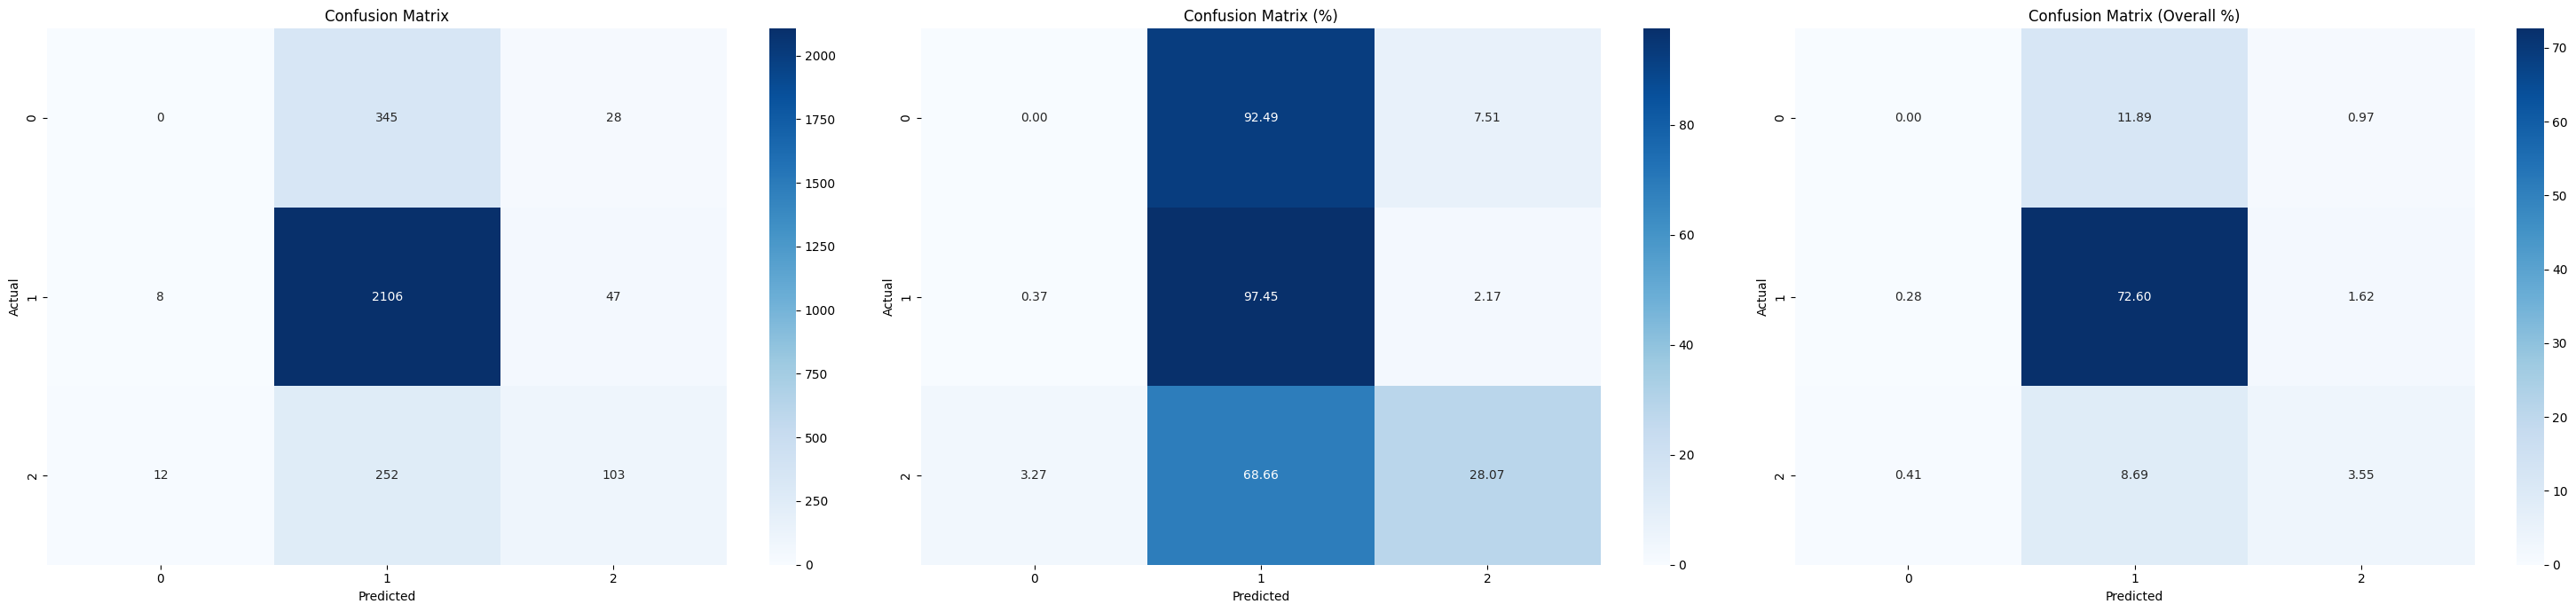

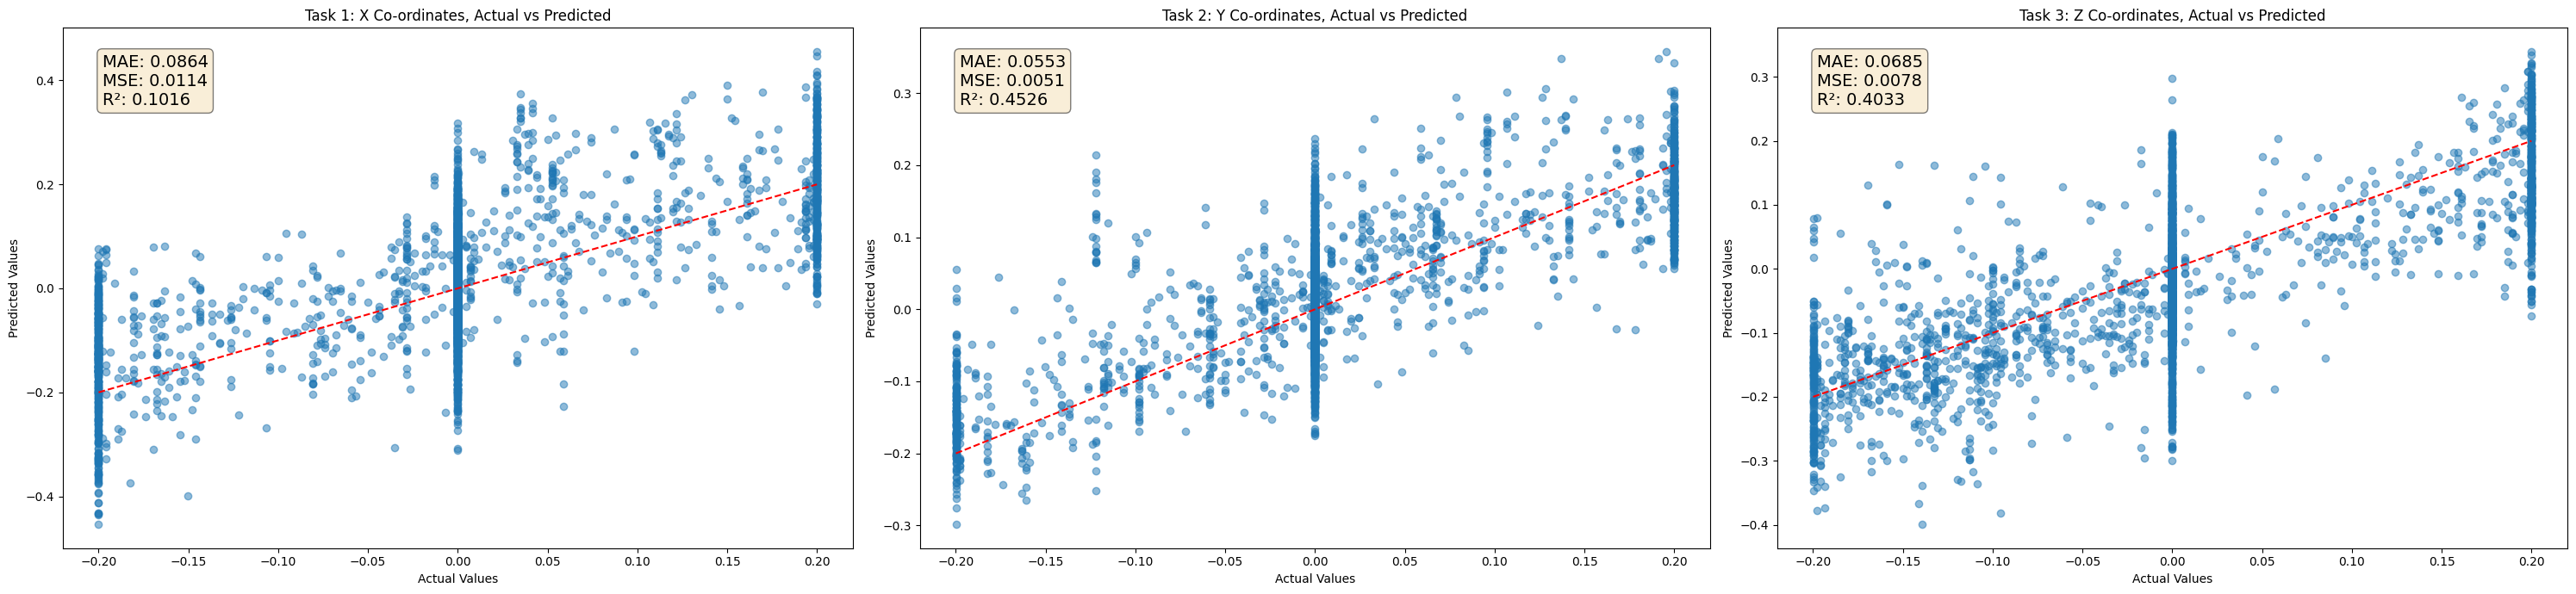

In [22]:
# Create the charts to evaluate the model
display(HTML("<h2>Data Evaluation</h2>"))

# Evaluate classification model
evaluate_classification_model(baseline_model, val_dataloader)

# Evaluate regression model
evaluate_regression_model(baseline_model, val_dataloader)

#### Question 1.b.ii.iii Model failure modes (9 marks)
##### Task
- Investigate the failure modes of the model. You should: 
  - Demonstrate the failure mode using **empirical evidence** e.g., _the model fails on X observations as demonstrated by..._
  - Assess the impact of these failure modes using **empirical evidence** i.e., how significant is this problem. You should consider both metrics and dataset coverage
  - Conclude __why__ the model might be failing on these observations **empirical evidence** e.g., _X part of the model performs poorly, as demonstrated by..._

__IMPORTANT__:
- Marks will be penalised if the failure modes you identify are not systematic i.e., you select a single observation that the model fails on. If you cannot identify any general failure modes of the model, you will be awarded full marks if you provide empirical evidence justifying why there are no systematic failure modes which sufficienty accounts for the diversity of observations in the dataset.


##### **Answer**:

Kindly refer to the charts provided in 1.b.ii.ii for reference in these answers.

##### 1. The model is making predictions outside the regression range of [-0.2, 0.2].

  - **Empirical Evidence:** The model fails on predictions outside the range of [-0.2, 0.2] as demonstrated by the fact that it consistently predicts values beyond this range across all coordinate prediction tasks.
  - **Impact Assessment:** This issue is significant as it affects all coordinate prediction tasks, particularly for actual targets that are close to -0.2 or 0.2. This can be quantified by the number of predictions falling outside the range and the deviation from the expected values.
  - **Conclusion:** The model is failing on these observations because neural network regression models can produce predictions that extend beyond the range of the training data. The lack of constraints or regularisation in the Baseline model allows these out-of-range predictions to occur unchecked. Implementing `torch.clamp` will ensure that regression values are kept within the correct range.

##### 2. The model is struggling with class imbalance in classification.

  - **Empirical Evidence:** The model over-predicts gripper action 1 for all classes, as demonstrated by the disproportionately high number of predictions for class 1 compared to classes 0 and 2.
  - **Impact Assessment:** This issue is significant as it results in very few true position predictions for classes 0 and 2, leading to a spuriously high accuracy for class 1. In total, approximately 93% of all predictions made by the baseline are for class 1.
  - **Conclusion:** The model is failing on these observations because it achieves a high accuracy by predicting the frequently occurring class 1. Sample weighting can be utilised to re-balance the classes and weight the loss function accordingly. This will enable the model to pursue a global minima that maximises the performance of all three classification objectives and this learn 'true' relationships.

##### 3. All of the prediction values in regression are low.

  - **Empirical Evidence:** All of the $R^2$ co-ordinate scores are under 50%. In particular, the model's predictions for the X coordinate are significantly worse than for the Y and Z coordinates, with an $R^2$ of only 12.5%. Further, the error for the validation data is nearly twice the size of the error for the training data.
  - **Impact Assessment:** This issue is significant as it indicates overfitting, with poor validation results compared to training results.
  - **Conclusion:** The model is failing on these observations due to overfitting. Regularisation techniques, such as dropout or weight decay, will be used to avoid over-reliance on a set of weights and improve generalisation.

### Question 1.c Model tuning
Now you have evaluated the proposed model, you are required to iterate and train a higher performing one. You are expected to run experiments that help you understand where the model is underperforming, guiding your development.

#### Question 1.c.i Model tuning (5 marks)
##### Task
- Using the code blocks below, implement a model which improves over the previous. Improve the performance as best you can and report the results using the metric/metrics you used in question 1.b.ii Model evaluation. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [29]:
def run_experiment(use_clamp=True, use_terminal_batch_sampler=True, use_weighted_sampler=True, use_class_weights=True, use_dropout=True, use_episode_length=True):
    # Define the CNN configuration
    cnn2_config = ConvolutionLayersConfig(
        input_dim=224,
        input_channels=2,
        layers=[
            nn.Conv2d(
                in_channels=2,
                out_channels=8,
                kernel_size=(3,3),
                stride=1,
                padding=1,
                dilation=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout(p=0.5) if use_dropout else nn.Identity(),  # Conditional dropout
            nn.Conv2d(
                in_channels=8,
                out_channels=16,
                kernel_size=(3,3),
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout(p=0.5) if use_dropout else nn.Identity(),  # Conditional dropout
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=(3,3),
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout(p=0.5) if use_dropout else nn.Identity(),  # Conditional dropout
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=(3,3),
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout(p=0.5) if use_dropout else nn.Identity(),  # Conditional dropout
        ]
    )

    _cnn_output_dim = cnn2_config.get_output_dims()
    _cnn_output_channels = cnn2_config.get_output_channels()
    _mlp_input_dim = int(
                (_cnn_output_dim[-1]*_cnn_output_dim[-1])*_cnn_output_channels[-1]
                )

    image_encoder = JointCNNEncoder(
        cnn=CNN(cnn2_config),
        dense=MLP(
            input_dim=_mlp_input_dim,
            hidden_dims=[256],
            output_dim=128
        )
    )

    obs_encoder_input_dim = 17 if use_episode_length else 15
    obs_encoder = MLP(
        input_dim=obs_encoder_input_dim,  # Conditional input dimension
        hidden_dims=[256,256],
        output_dim=128
    )

    dense = MLP(
        input_dim=128,
        hidden_dims=[64,32],
        output_dim=6
    )

    class Improved1(BaseModel):
        def __init__(self, image_encoder: JointCNNEncoder, obs_encoder: MLP, dense: MLP) -> None:
            super().__init__()
            self.image_encoder = image_encoder
            self.obs_encoder = obs_encoder
            self.dense = dense

        def forward(self, images, obs):
            _img_enc = self.image_encoder(images)
            _obs_enc = self.obs_encoder(obs)
            _dense_enc = self.dense(_img_enc + _obs_enc)
            pos = _dense_enc[:, 0:3]
            grp = _dense_enc[:, 3:]

            if use_clamp:
                pos = torch.clamp(pos, min=-0.2, max=0.2)

            return {
                "pos": pos,
                "grp": grp
            }

        def reset(self, image_encoder_kwargs, obs_encoder_kwargs, dense_kwargs):
            self.image_encoder.reset(**image_encoder_kwargs)
            self.obs_encoder.reset(**obs_encoder_kwargs)
            self.dense.reset(**dense_kwargs)

    torch.manual_seed(1)
    
    model = Improved1(
        image_encoder=image_encoder,
        obs_encoder=obs_encoder,
        dense=dense
    )
    model.reset({}, {}, {})
    exp_kwargs = {
        "batch_size": 64,
        "learning_rate": 0.001,
        "half_precision": True,
        "target_offset": 0
    }

    if project_options.debug:
        exp_kwargs["batch_size"] = 64  # amended from 4

    if exp_kwargs["half_precision"]:
        train_dataset = NpDictDataset(
            array_dict=train_nps,
            transform_lkp=global_transforms,
            dep_vars=["actions"],
            indep_vars=[
                "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
                "ee_cartesian_vel_ob", "joint_pos_ob"
            ] + (["episode_length"] if use_episode_length else []),
            target_offset=exp_kwargs["target_offset"]
        )

        val_dataset = NpDictDataset(
            array_dict=val_nps,
            transform_lkp=global_transforms,
            dep_vars=["actions"],
            indep_vars=[
                "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
                "ee_cartesian_vel_ob", "joint_pos_ob"
            ] + (["episode_length"] if use_episode_length else []),
            target_offset=exp_kwargs["target_offset"]
        )

        test_dataset = NpDictDataset(
            array_dict=test_nps,
            transform_lkp=global_transforms,
            dep_vars=["actions"],
            indep_vars=[
                "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
                "ee_cartesian_vel_ob", "joint_pos_ob"
            ] + (["episode_length"] if use_episode_length else []),
            target_offset=exp_kwargs["target_offset"]
        )
    else:
        train_dataset = NpDictDataset(
            array_dict={k: train_nps[k].astype(np.float32) for k in train_nps},
            transform_lkp=global_transforms,
            dep_vars=["actions"],
            indep_vars=[
                "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
                "ee_cartesian_vel_ob", "joint_pos_ob"
            ] + (["episode_length"] if use_episode_length else []),
            target_offset=exp_kwargs["target_offset"]
        )

        val_dataset = NpDictDataset(
            array_dict={k: val_nps[k].astype(np.float32) for k in val_nps},
            transform_lkp=global_transforms,
            dep_vars=["actions"],
            indep_vars=[
                "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
                "ee_cartesian_vel_ob", "joint_pos_ob"
            ] + (["episode_length"] if use_episode_length else []),
            target_offset=exp_kwargs["target_offset"]
        )

        test_dataset = NpDictDataset(
            array_dict={k: test_nps[k].astype(np.float32) for k in test_nps},
            transform_lkp=global_transforms,
            dep_vars=["actions"],
            indep_vars=[
                "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
                "ee_cartesian_vel_ob", "joint_pos_ob"
            ] + (["episode_length"] if use_episode_length else []),
            target_offset=exp_kwargs["target_offset"]
        )

    # print(len(train_dataset))
    out = train_dataset[0]

    def collate_func(input_list: List[DatasetOutput]) -> DatasetOutput:
        pos = []
        _grp = []
        images = []
        obs = []

        for val in input_list:
            images.append(
                torch.concat(
                    [val.input["front_cam_ob"], val.input["mount_cam_ob"]],
                    dim=0
                )[None, :]
            )
            if use_episode_length:
                episode_length = val.input["episode_length"]
                if episode_length.ndim == 1:
                    episode_length = episode_length.unsqueeze(0)
                elif episode_length.ndim == 2 and episode_length.shape[0] == 1:
                    episode_length = episode_length.squeeze(0)
                obs.append(
                    torch.concat(
                        [
                            val.input["ee_cartesian_pos_ob"],
                            val.input["ee_cartesian_vel_ob"],
                            val.input["joint_pos_ob"],
                            episode_length
                        ],
                        dim=0
                    )[None, :]
                )
            else:
                obs.append(
                    torch.concat(
                        [
                            val.input["ee_cartesian_pos_ob"],
                            val.input["ee_cartesian_vel_ob"],
                            val.input["joint_pos_ob"]
                        ],
                        dim=0
                    )[None, :]
                )
            pos.append(val.output["actions"][0:3][None, :])
            _grp.append(val.output["actions"][-1:][None])

        _grp = torch.concat(_grp, dim=0)
        grp = torch.zeros(_grp.shape[0], 3)
        grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1

        return DatasetOutput(
            input={
                "images": torch.concat(images, dim=0),
                "obs": torch.concat(obs, dim=0),
            },
            output={
                "pos": torch.concat(pos, dim=0),
                "grp": grp
            }
        )

    # Extract the classification targets (last column)
    classification_targets = train_nps["actions"][:, -1]
    print(len(train_nps["actions"]))

    # Calculate class weights for classification targets
    class_counts = Counter(classification_targets)
    total_samples = len(classification_targets)
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

    print("Class counts:", class_counts)
    print("Total samples:", total_samples)
    print("Class weights:", class_weights)

    # Hardcoded class weights
    class_weights_tensor = torch.tensor([8.3, 1.3, 7.11], dtype=torch.float)
    print("Class weights tensor:", class_weights_tensor)

    # Move the class weights tensor to the appropriate device (e.g., GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    class_weights_tensor = class_weights_tensor.to(device)

    print("Class weights tensor:", class_weights_tensor)

    # Create a list of sample weights
    sample_weights = [class_weights[target] for target in classification_targets]
    print("Sample weights Length:", len(sample_weights))

    # Convert sample weights to a tensor
    sample_weights_tensor = torch.tensor(sample_weights, dtype=torch.float)

    # Create the sampler
    sampler = WeightedRandomSampler(weights=sample_weights_tensor, num_samples=len(train_nps["actions"]), replacement=True)

    grp_criterion = nn.CrossEntropyLoss(reduction="mean", weight=class_weights_tensor if use_class_weights else None)  # Conditional class weights

    class TerminalBatchSampler(Sampler):
        def __init__(self, sequences, weighted_sampler=None):
            self.sequences = sequences
            self.weighted_sampler = weighted_sampler

        def __iter__(self):
            if self.weighted_sampler:
                sampled_sequences = list(self.weighted_sampler)
            else:
                sampled_sequences = range(len(self.sequences))

            for seq_idx in sampled_sequences:
                yield self.sequences[seq_idx]

        def __len__(self):
            return len(self.sequences)

    # Group sequences for training and validation
    train_sequences = []
    sequence = []
    for idx, terminal in enumerate(train_nps['terminals']):
        sequence.append(idx)
        if terminal == 1:
            train_sequences.append(sequence)
            sequence = []
    if sequence:
        train_sequences.append(sequence)

    val_sequences = []
    sequence = []
    for idx, terminal in enumerate(val_nps['terminals']):
        sequence.append(idx)
        if terminal == 1:
            val_sequences.append(sequence)
            sequence = []
    if sequence:
        val_sequences.append(sequence)

    test_sequences = []
    sequence = []
    for idx, terminal in enumerate(test_nps['terminals']):
        sequence.append(idx)
        if terminal == 1:
            test_sequences.append(sequence)
            sequence = []
    if sequence:
        test_sequences.append(sequence)

    # Calculate sequence weights for training
    sequence_weights = []
    for sequence in train_sequences:
        sequence_targets = classification_targets[sequence]
        sequence_weight = sum(class_weights[target] for target in sequence_targets) / len(sequence_targets)
        sequence_weights.append(sequence_weight)
    sequence_weights_tensor = torch.tensor(sequence_weights, dtype=torch.float)

    # Create sequence-level sampler
    sequence_sampler = WeightedRandomSampler(weights=sequence_weights_tensor, num_samples=len(train_sequences), replacement=True)

    # Create batch samplers
    train_batch_sampler = TerminalBatchSampler(train_sequences, sequence_sampler if use_weighted_sampler else None) if use_terminal_batch_sampler else None
    val_batch_sampler = TerminalBatchSampler(val_sequences) if use_terminal_batch_sampler else None
    test_batch_sampler = TerminalBatchSampler(test_sequences) if use_terminal_batch_sampler else None

    # Create DataLoaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_sampler=train_batch_sampler,
        collate_fn=collate_func,
    ) if train_batch_sampler else DataLoader(
        train_dataset,
        batch_size=exp_kwargs["batch_size"],
        shuffle=True,
        collate_fn=collate_func,
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_sampler=val_batch_sampler,
        collate_fn=collate_func,
    ) if val_batch_sampler else DataLoader(
        val_dataset,
        batch_size=exp_kwargs["batch_size"],
        shuffle=False,
        collate_fn=collate_func,
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_sampler=test_batch_sampler,
        collate_fn=collate_func,
    ) if test_batch_sampler else DataLoader(
        test_dataset,
        batch_size=exp_kwargs["batch_size"],
        shuffle=False,
        collate_fn=collate_func,
    )

    first_batch = next(iter(train_dataloader))

    exp_kwargs["model_def"] = model.__repr__()

    if exp_kwargs["half_precision"]:
        model = model.half()
    
    optimizer = torch.optim.Adam(
        model.parameters(), lr=exp_kwargs["learning_rate"],
        eps=1e-04
    )

    # Define the ReduceLROnPlateau scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    __criterion = TrackerBalancedLoss(
        loss_lkp={
            "pos": pos_criterion,
            "grp": grp_criterion
        }
    )

    if exp_kwargs["half_precision"]:
        with torch.no_grad():
            if torch.cuda.is_available():
                model = model.cuda()
                with torch.autocast(device_type="cuda"):
                    res = model(
                        images=first_batch.input["images"].cuda(),
                        obs=first_batch.input["obs"].cuda()
                    )
                    first_batch.output["pos"] = first_batch.output["pos"].cuda()
                    first_batch.output["grp"] = first_batch.output["grp"].cuda()
            else:
                with torch.autocast(device_type="cpu"):
                    res = model(
                        images=first_batch.input["images"],
                        obs=first_batch.input["obs"]
                    )
    else:
        with torch.no_grad():
            if torch.cuda.is_available():
                model = model.cuda()
                res = model(
                    images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
            else:
                res = model(
                    images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                )
    print(__criterion(res, first_batch.output))

    mo = WandBMetricOrchestrator()

    train_criterion = TrackerBalancedLoss(
        loss_lkp={
            "pos":copy.deepcopy(pos_criterion),
            "grp":copy.deepcopy(grp_criterion)
        },
        name="train",
        mo=mo
    )


    val_criterion = TrackerBalancedLoss(
        loss_lkp={
            "pos":copy.deepcopy(pos_criterion),
            "grp":copy.deepcopy(grp_criterion)
        },
        name="val",
        mo=mo
    )

    # Instantiate Improved1
    torch.manual_seed(1)
    model = Improved1(
        image_encoder=image_encoder,
        obs_encoder=obs_encoder,
        dense=dense
    )

    sl_trainer = TorchTrainingLoop(
        model=model, gpu=True, optimizer=optimizer, criterion=train_criterion,
        val_criterion=val_criterion, epochs=20, logger=logger,
        mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
        preds_save_type=None,
        scheduler=None
    )

    wandb_name = "End_to_end_L2"
    wandb_grp="End_to_end"

    if project_options.debug:
        wandb_name = f"{wandb_name}_DEBUG"

    # Example usage in your training loop
    orig = datetime.datetime.now()
    try:
        sl_trainer.training_loop(
            train_loader=train_dataloader,
            val_loader=val_dataloader,
            wandb_proj=WANDB_PROJECT,
            wandb_grp=wandb_grp,
            wandb_config=exp_kwargs,
            wandb_name=wandb_name,
            reset_kwargs={
                "image_encoder_kwargs": {},
                "obs_encoder_kwargs": {},
                "dense_kwargs": {}
            }
        )
    except Exception as e:
        print(f"An error occurred: {e}")
    post_train = datetime.datetime.now()

    return train_dataloader, val_dataloader, test_dataloader, image_encoder, obs_encoder, dense, Improved1

# Train the model:
improved_train_dataloader, improved_val_dataloader, improved_test_dataloader, improved_image_encoder, improved_obs_encoder, improved_dense, Improved1 = run_experiment(
    use_clamp=True, 
    use_terminal_batch_sampler=True, 
    use_weighted_sampler=True, 
    use_class_weights=True, 
    use_dropout=True, 
    use_episode_length=True
)

25469
Class counts: Counter({1.0: 19147, 2.0: 3261, 0.0: 3061})
Total samples: 25469
Class weights: {1.0: 1.3301822739854807, 0.0: 8.320483502123489, 2.0: 7.810180926096289}
Class weights tensor: tensor([8.3000, 1.3000, 7.1100])
Class weights tensor: tensor([8.3000, 1.3000, 7.1100], device='cuda:0')
Sample weights Length: 25469
tensor(6.3242, device='cuda:0', dtype=torch.float16)


100%|██████████| 453/453 [00:22<00:00, 19.77it/s]


In [30]:
def run_evaluation(model_class, classification_checkpoint_path, regression_checkpoint_path,
                   val_dataloader, image_encoder, obs_encoder, dense, run_no_ensemble=False,
                   save_classification_file=None, save_regression_file=None, if_save=False):
    import torch
    from IPython.display import HTML, display

    def load_classification_model(model_class, checkpoint_path):
        classification_model = model_class(
            image_encoder=image_encoder,
            obs_encoder=obs_encoder,
            dense=dense
        )
        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path)
        # Extract the model state dictionary
        model_state_dict = checkpoint['model_state_dict']
        # Load the state dictionary into the model
        classification_model.load_state_dict(model_state_dict)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        classification_model.to(device)
        return classification_model

    def load_regression_model(model_class, checkpoint_path):
        regression_model = model_class(
            image_encoder=image_encoder,
            obs_encoder=obs_encoder,
            dense=dense
        )
        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path)
        # Extract the model state dictionary
        model_state_dict = checkpoint['model_state_dict']
        # Load the state dictionary into the model
        regression_model.load_state_dict(model_state_dict)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        regression_model.to(device)
        return regression_model

    def save_model(model, file_name):
        torch.save({'model_state_dict': model.state_dict()}, file_name)

    torch.manual_seed(1)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(1)

    display(HTML("<h2>Data Evaluation</h2>"))

    classification_model = load_classification_model(
        model_class=model_class, 
        checkpoint_path=classification_checkpoint_path
    )
    evaluate_classification_model(classification_model, val_dataloader)

    regression_model = load_regression_model(
        model_class=model_class, 
        checkpoint_path=regression_checkpoint_path
    )
    evaluate_regression_model(regression_model, val_dataloader)

    if if_save:
        if save_classification_file:
            save_model(classification_model, save_classification_file)
        if save_regression_file:
            save_model(regression_model, save_regression_file)

    if run_no_ensemble:
        display(HTML("<h2>Data Evaluation - No Ensemble</h2>"))

        classification_model_no_ensemble = load_classification_model(
            model_class=model_class, 
            checkpoint_path=classification_checkpoint_path
        )
        evaluate_classification_model(classification_model_no_ensemble, val_dataloader)

        # Use the classification model for regression in the no ensemble case
        evaluate_regression_model(classification_model_no_ensemble, val_dataloader)

/tmp/ipykernel_83025/182827254.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


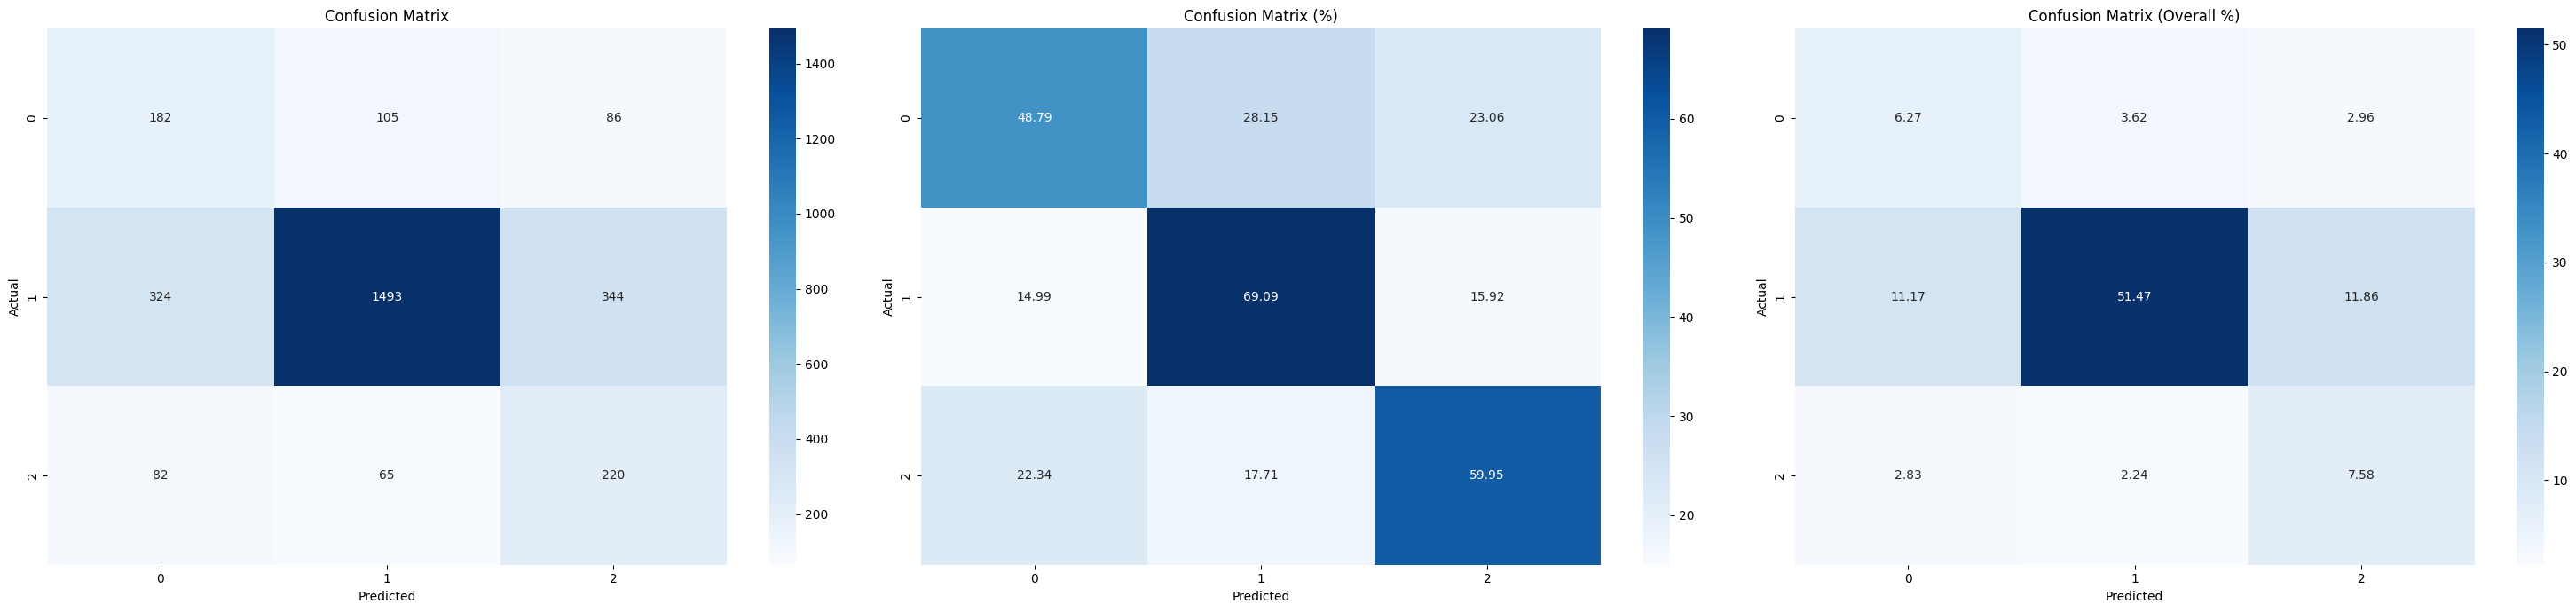

/tmp/ipykernel_83025/182827254.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


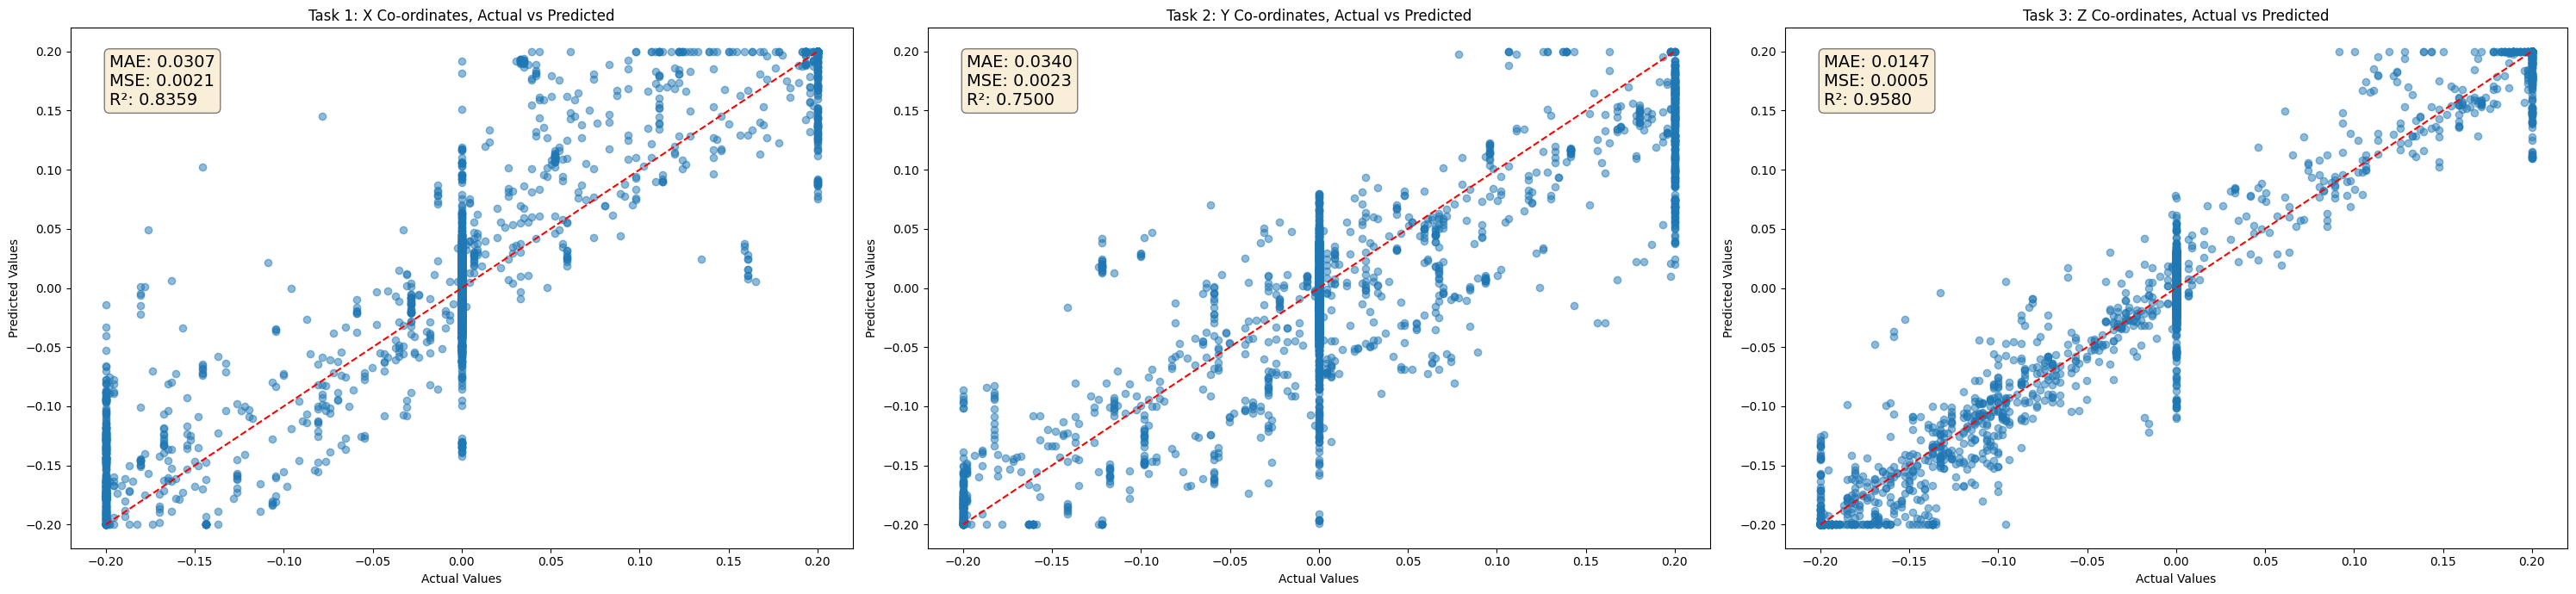

/tmp/ipykernel_83025/182827254.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


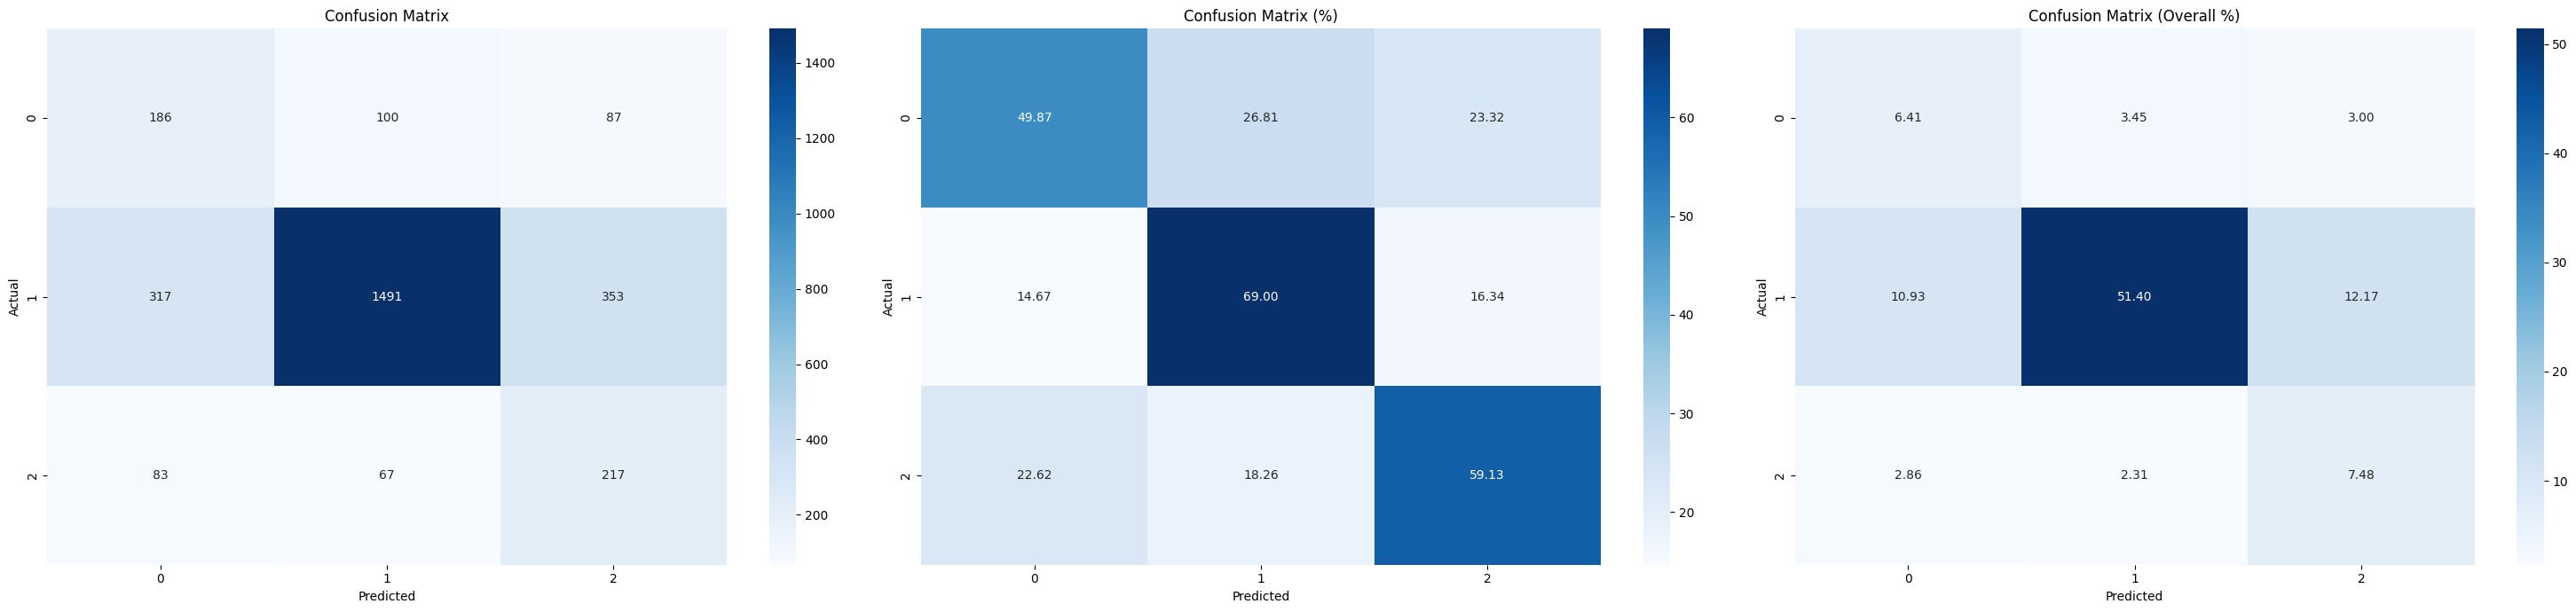

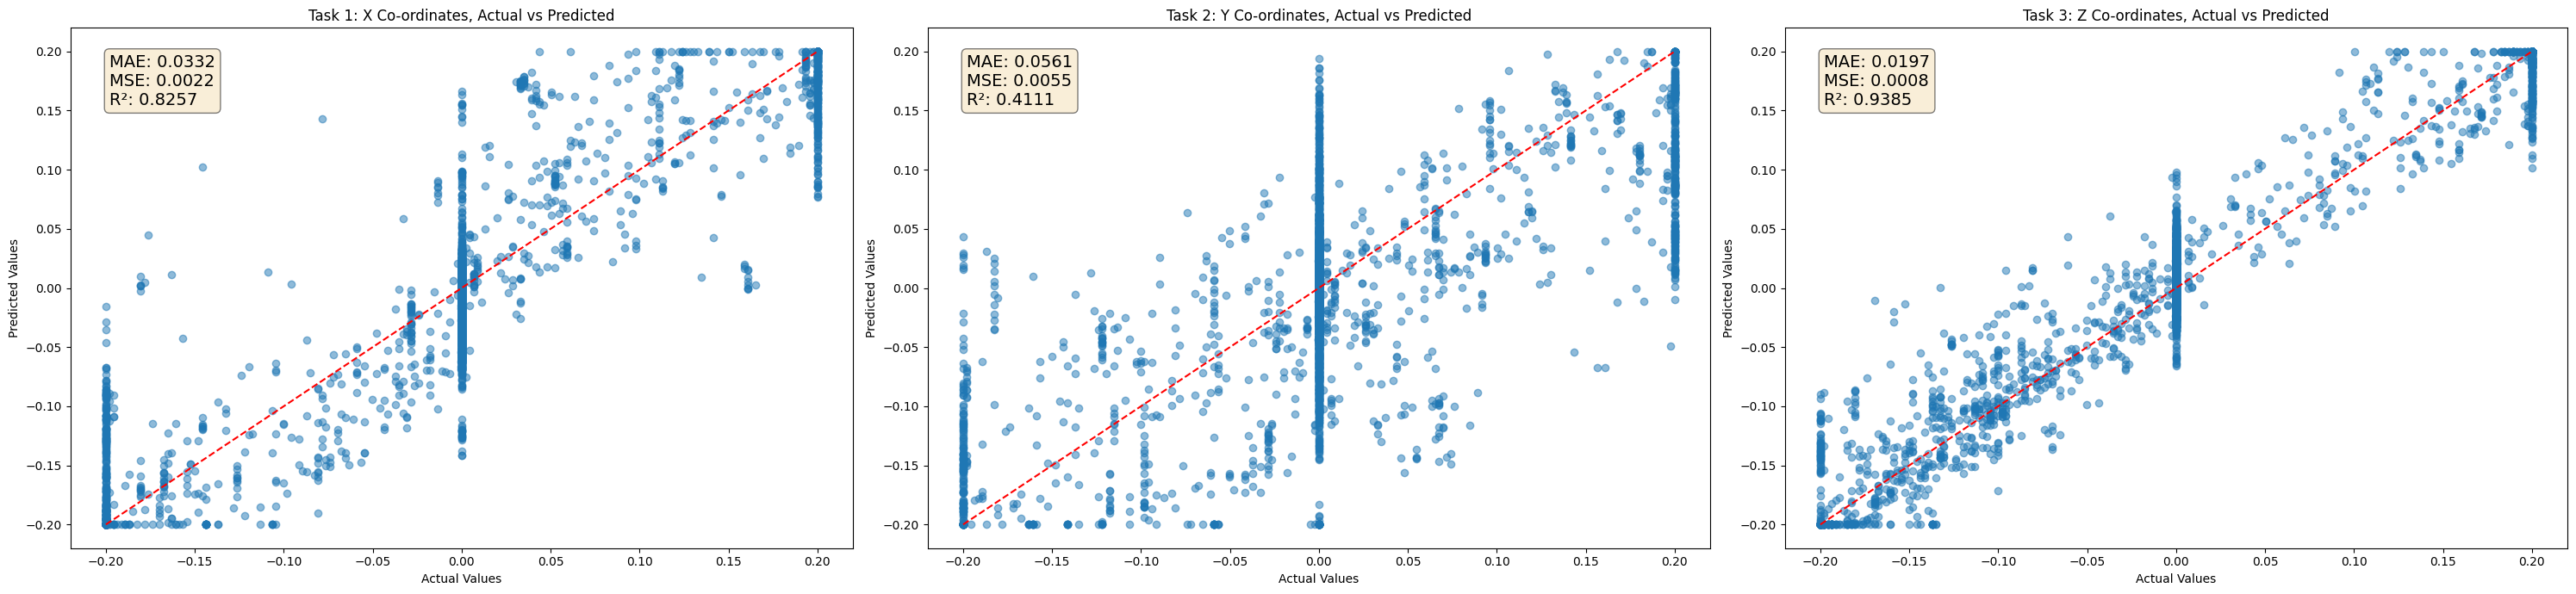

In [31]:
run_evaluation(
    model_class=Improved1,
    classification_checkpoint_path='./wandb/latest-run/files/agent_checkpoints/mdl_chkpnt_epoch_18.pt',
    regression_checkpoint_path='./wandb/latest-run/files/agent_checkpoints/mdl_chkpnt_epoch_14.pt',
    val_dataloader=improved_val_dataloader,
    image_encoder=improved_image_encoder,
    obs_encoder=improved_obs_encoder,
    dense=improved_dense,
    run_no_ensemble=True,
    save_classification_file='improved_classification_model.pt',
    save_regression_file='improved_regression_model.pt',
    if_save=True
)

#### Question 1.c.ii Discussion (marks broken down in subsections below)

##### Task
In the markdown blocks below, discuss **three** experiments that you ran during the development of your model, defined in 1.c.i Model tuning which were the **most insightful** with respect to the design of your final model. Importantly, **most insightful** needn't necessarily be the final decisions that appear in the model defined in question 1.c.i Model tuning, rather they should be experiments that most shaped your model development process. For example: 
- You might decide to use a learning rate scheduler and decrease the learning rate at epoch 10 (call this experiment "EXP_LR");
- This experiment produces a jump in performance and unlocks a series of further fruitful experiments into learning rate scheduling;
- However, in the model reported in question 1.c.i Model tuning, you use a learning rate schedule with descreases at epochs 6 and 15 (since these produced a marginal performance over "EXP_LR")
- For this question __you should discuss EXP_LR__.
  
For each experiment, complete the "Description", "Result" and "Conclusion" sections where the following information should be provided:
* __Description__: What delta were you measuring i.e., change of architecture, change of learning rate etc?
* __Justification__: **Why** are you conducting the experiment?
  * What was the context of the model development process up to this point? What did you already know about how well the model performed/why it was performing/what were the challenging data points?
* __Conclusion__: What did you __learn__ from the experiment and provide __empirical evidence__ to support this claim. In drawing your conclusions, consider where there are multiple possible causes for the model failing, ensure you provide evidence for each of these and conclude whether or not they might be root cause (you may conclude that there are multiple causes).

**IMPORTANT** If your reported experiments are **not** well motivated and do not demonstrate that you have interrogated the model performance, you will be deducted marks. An example of poor motovation might be: *I chose to decrease the learning rate from X to Y as I did not know what impact this might have*. This justification could be improved by explaining what you __already know__ about how the learning rate might be affecting the model. What hypotheses might you draw about what the experiment will show?


#### Question 1.c.ii.i Experiment 1 discussion (10 marks)

##### Description

Improving Regression Outputs:

1. Change of architecture: Implemented torch.clamp to keep regression outputs within the range [-0.2, 0.2].
2. Change of architecture: Added dropout after each convolutional block to reduce overfitting.

Evaluation Criteria:
1. Improvement in $R^2$, MAE and MSE scores.
2. Reduction in the difference between training and validation regression outputs (less overfitting).
3. Classification metrics should remain similar to the baseline.

 
##### Justification

Torch.clamp:

1. Reason: To ensure the regression outputs are within the actual range of results, improving the accuracy of predictions.
2. Context: The model previously produced regression outputs outside the expected range, leading to poor performance.

Dropout:
1. Reason: To reduce overfitting by preventing the model from relying too heavily on any particular set of weights.
2. Context: The model showed significant overfitting on the regression data, with a large gap between training and validation losses.


##### Conclusion

Results:

1. Torch.clamp: Successfully constrained all values within the range [-0.2, 0.2].
2. Dropout: Reduced overfitting, with training loss (pos_train_loss) at 0.0009 and validation loss (pos_val_loss) at 0.00056.

Performance:
1. $R^2$ scores improved to 0.89, 0.78, and 0.94 respectively. All other metrics (MAE, MSE) also improve.
2. Classification metrics remained relatively unchanged, as expected.

The experiment successfully improved regression results by addressing overfitting and constraining output values.
The Baseline model's over-reliance on a subset of weights was mitigated, leading to better generalisation.


In [ ]:
# Train the model:
exp1_train_dataloader, exp1_val_dataloader, exp1_test_dataloader, exp1_image_encoder, exp1_obs_encoder, exp1_dense, exp1 = run_experiment(
    use_clamp=True, 
    use_terminal_batch_sampler=False, 
    use_weighted_sampler=False, 
    use_class_weights=False, 
    use_dropout=True, 
    use_episode_length=False
)

25469
Class counts: Counter({1.0: 19147, 2.0: 3261, 0.0: 3061})
Total samples: 25469
Class weights: {1.0: 1.3301822739854807, 0.0: 8.320483502123489, 2.0: 7.810180926096289}
Class weights tensor: tensor([8.3000, 1.3000, 7.1100])
Class weights tensor: tensor([8.3000, 1.3000, 7.1100], device='cuda:0')
Sample weights Length: 25469
tensor(1.3994, device='cuda:0', dtype=torch.float16)


100%|██████████| 398/398 [00:22<00:00, 18.07it/s]


/tmp/ipykernel_83025/182827254.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


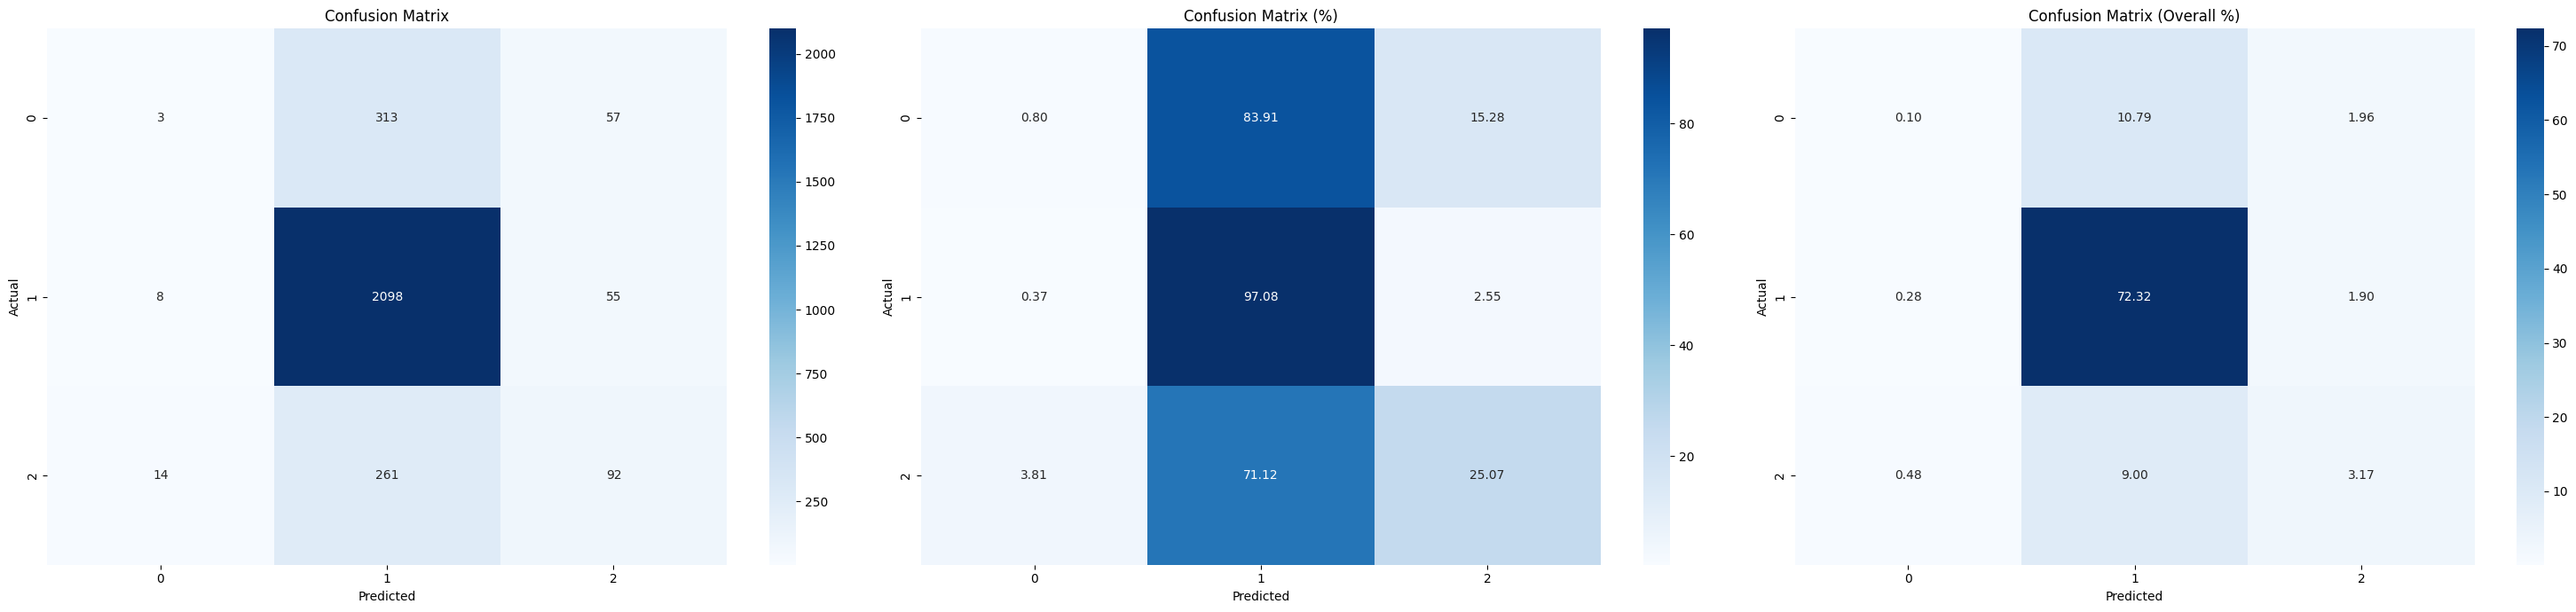

/tmp/ipykernel_83025/182827254.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


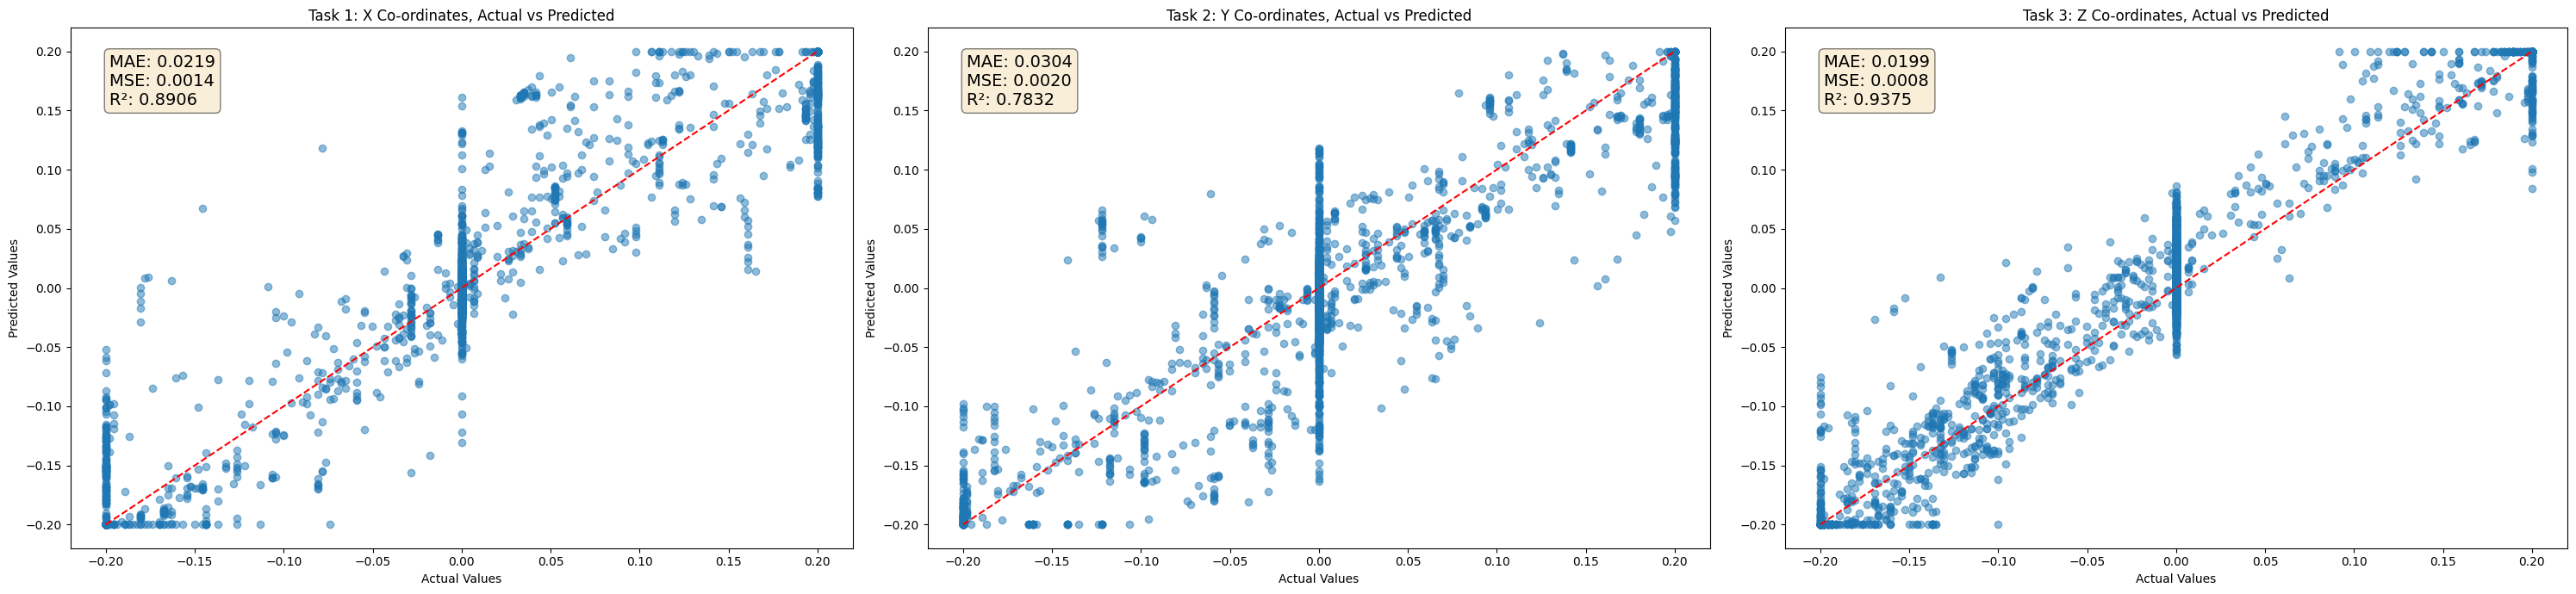

In [33]:
run_evaluation(
    model_class=exp1,
    classification_checkpoint_path='./wandb/latest-run/files/agent_checkpoints/mdl_chkpnt_epoch_17.pt',
    regression_checkpoint_path='./wandb/latest-run/files/agent_checkpoints/mdl_chkpnt_epoch_17.pt',
    val_dataloader=exp1_val_dataloader,
    image_encoder=exp1_image_encoder,
    obs_encoder=exp1_obs_encoder,
    dense=exp1_dense,
    run_no_ensemble=False,
    save_classification_file='exp1_classification_model.pt',
    save_regression_file='exp1_regression_model.pt',
    if_save=True
)

#### Question 1.c.ii.ii Experiment 2 discussion (10 marks)

##### Description

Improving Classification Targets Accuracy:

1. Change of sampler: Implemented sample weighting and sequences using a batch sampler that feeds sequences of the same length as the episodes into the model. Sequences with frequent occurrences of under-sampled classes (0 and 2) are given higher weighting.
2. Change of criterion: Amended the loss function (grp_criterion) to give greater weighting to the under-sampled classes.

Evaluation Criteria:
1. Improvement in the accuracy of classes 0 and 2.
2. Presence of 'true' predictions for class 1, avoiding over-prediction of class 1.
3. No significant degradation in regression outputs.

##### Justification

Sample Weighting & Sequences:
1. Reason: To enable the model to process one episode at a time, helping the model to identify patterns within an episode. Episodes with more instances of class 0 and 2 will be oversampled, increasing accuracy for classes 0 and 2.
2. Context: Episodes will contain similar features (i.e. the images will be similar), so the model needs to learn the characteristics that differentiate features within an episode.

Loss Weighting:
1. Reason: To ensure the model becomes accurate for all classes, not just the majority class (class 1).
2. Context: The model had a bias towards predicting class 1 due to class imbalance.

##### Conclusion

Results:
1. Classification metrics improved significantly for classes 0 and 2, with accuracies of 40% and 60% respectively.
2. Class 1 accuracy remained reasonable at 70%.

Performance:
1. Small drop in $R^2$ regression metrics, decreasing by 0.02 to 0.08 for all co-ordinates.

The experiment successfully improved classification accuracy for under-sampled classes. The model now learns true relationships between inputs and targets, justifying the drop in performance on class 1. The slight regression performance drop suggests a potential need for an ensemble approach, with separate models for regression and classification outputs.

In [59]:
# Train the model with specified parameters
exp2_train_dataloader, exp2_val_dataloader, exp2_test_dataloader, exp2_image_encoder, exp2_obs_encoder, exp2_dense, exp2 = run_experiment(
    use_clamp=True,              
    use_terminal_batch_sampler=True,
    use_weighted_sampler=True,
    use_class_weights=True,
    use_dropout=True,      
    use_episode_length=False
)

25469
Class counts: Counter({1.0: 19147, 2.0: 3261, 0.0: 3061})
Total samples: 25469
Class weights: {1.0: 1.3301822739854807, 0.0: 8.320483502123489, 2.0: 7.810180926096289}
Class weights tensor: tensor([8.3000, 1.3000, 7.1100])
Class weights tensor: tensor([8.3000, 1.3000, 7.1100], device='cuda:0')
Sample weights Length: 25469
tensor(7.3984, device='cuda:0', dtype=torch.float16)


100%|██████████| 453/453 [00:22<00:00, 19.92it/s]


/tmp/ipykernel_83025/182827254.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


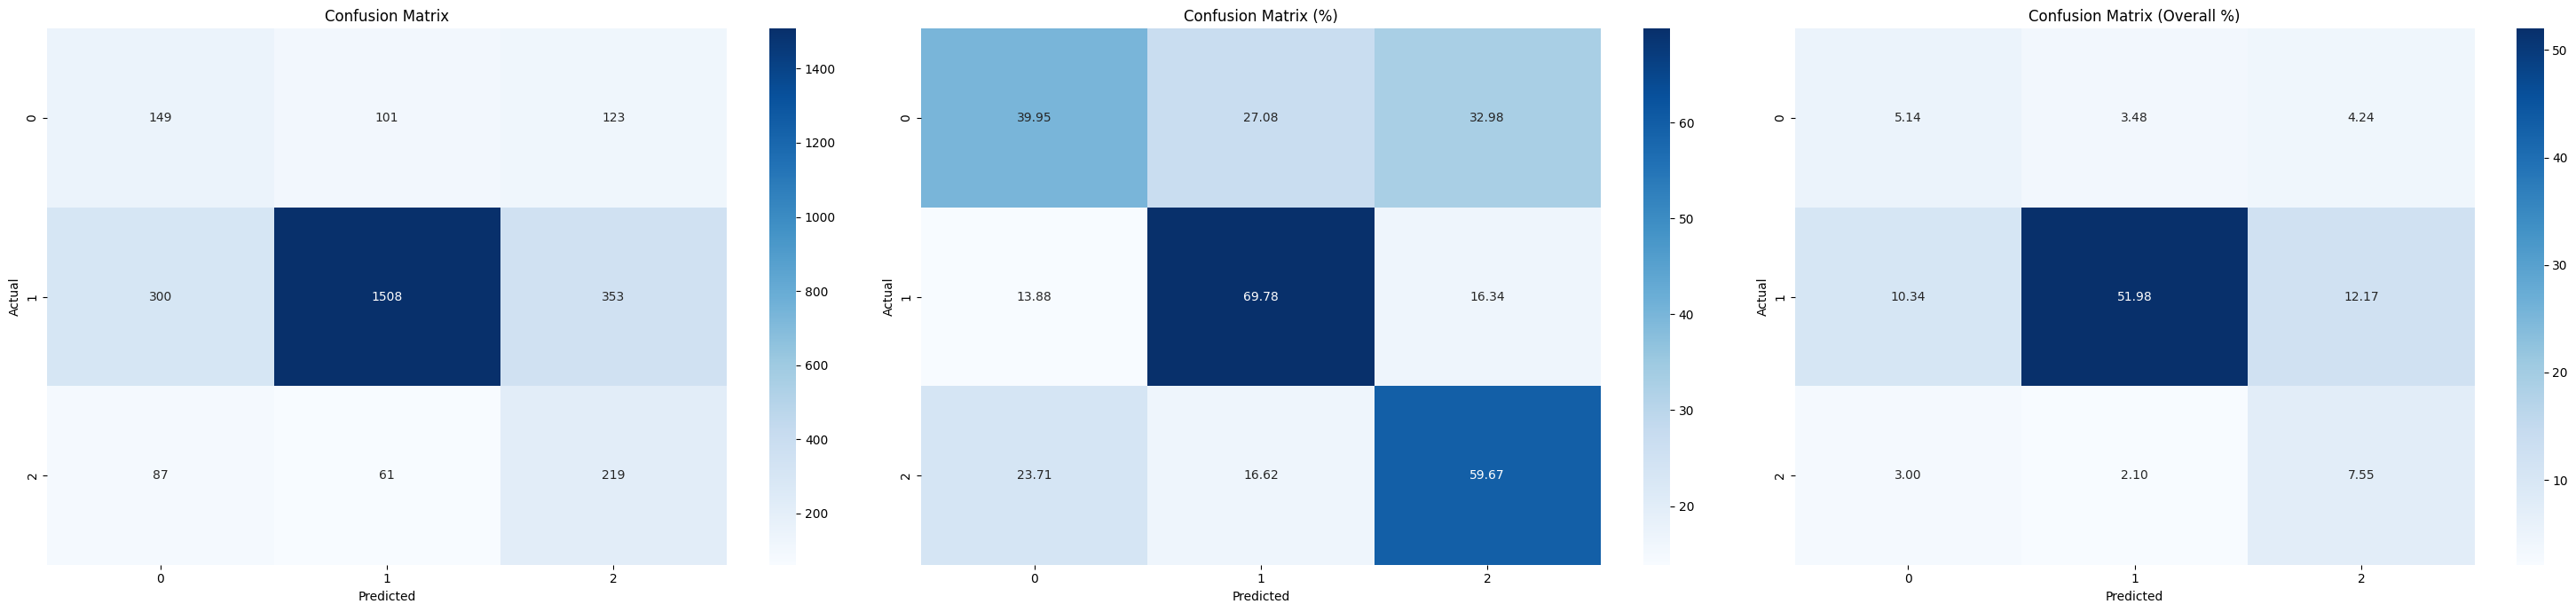

/tmp/ipykernel_83025/182827254.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


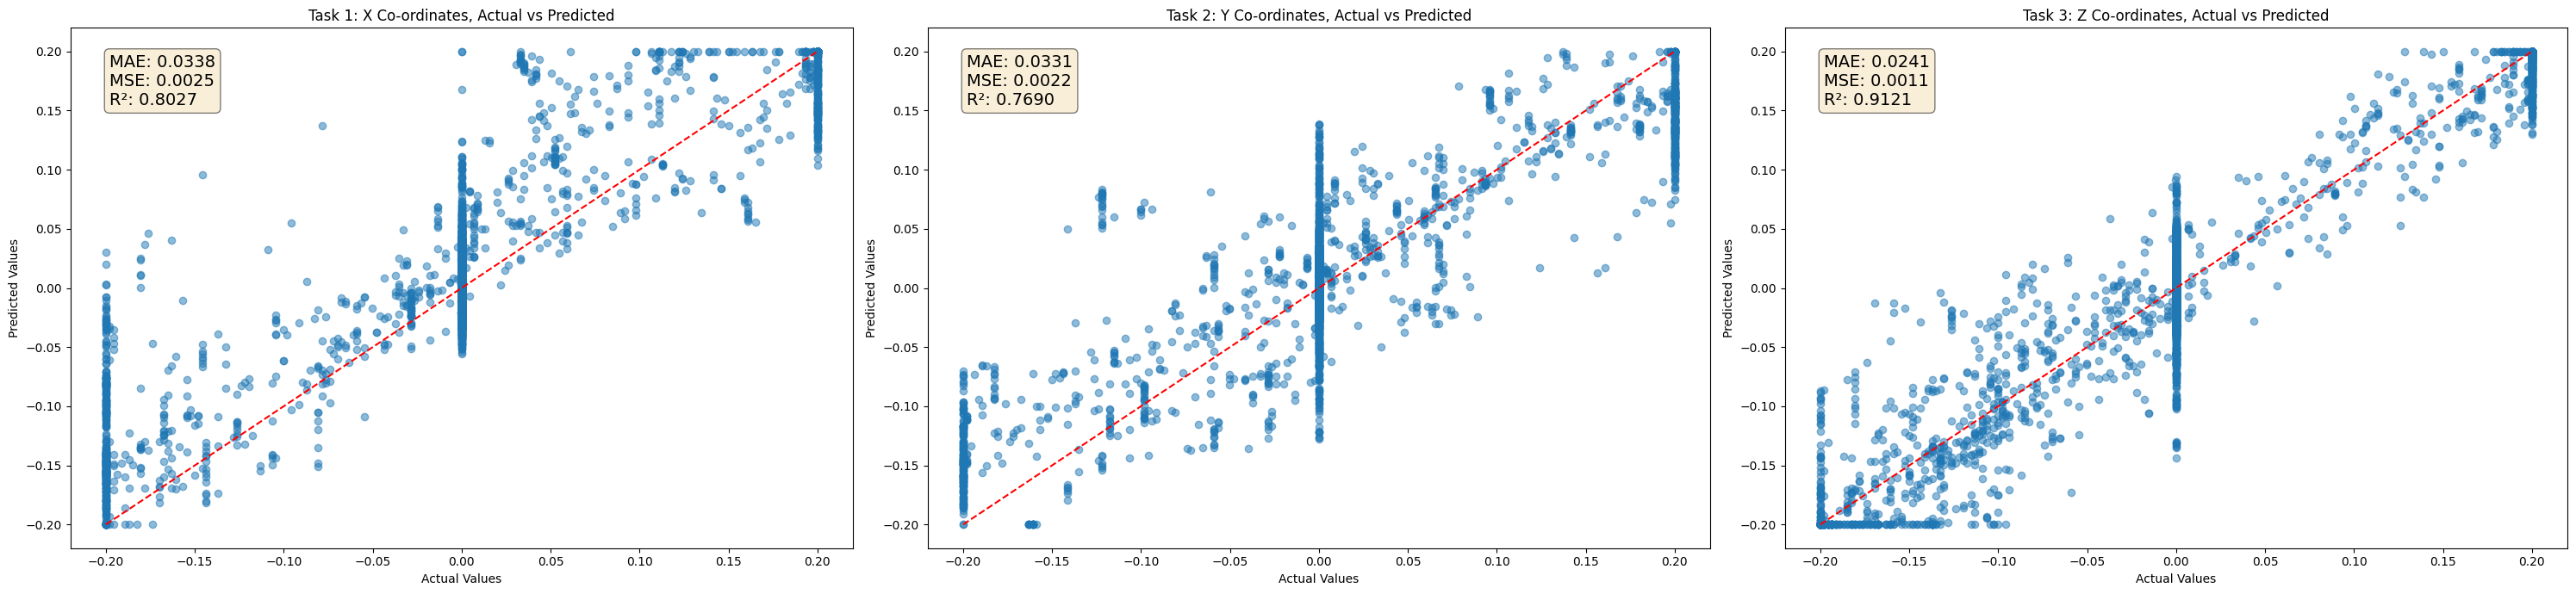

In [ ]:
run_evaluation(
    model_class=exp2,
    classification_checkpoint_path='./wandb/latest-run/files/agent_checkpoints/mdl_chkpnt_epoch_19.pt',
    regression_checkpoint_path='./wandb/latest-run/files/agent_checkpoints/mdl_chkpnt_epoch_19.pt',
    val_dataloader=exp2_val_dataloader,
    image_encoder=exp2_image_encoder,
    obs_encoder=exp2_obs_encoder,
    dense=exp2_dense,
    run_no_ensemble=False,
    save_classification_file='exp2_classification_model.pt',
    save_regression_file='exp2_regression_model.pt',
    if_save=True
)

#### Question 1.c.ii.iii Experiment 3 discussion (10 marks)

##### Description

Improving Classification Metrics with Episode Length Features:

1. Change of architecture: Added episode length features to the MLP, including sine and cosine approximate Fourier terms to represent episode time steps efficiently.

Evaluation Criteria:
1. Improvement in classification metrics.
2. No degradation in regression outputs.

##### Justification

Episode Length Features:

1. Reason: To enable the model to learn how features vary across an episode by capturing sequence information in the MLP.
2. Context: The ability to capture time series patterns in a tabular data format can enhance the model's predictive power. The cyclic nature of sine and cosine waves efficiently encodes different periods of an episode and the distance between parts of an episode.

##### Conclusion

Results:

1. Large increase in the accuracy of class 0, with an approximately 10% jump.
2. Minor drops (less than 1%) in performance for classes 1 and 2.

Performance:

1. Significant drop in the performance of the Y regression output.

The experiment successfully improved the accuracy for class 0, though there were minor drops for classes 1 and 2.
The regression output degradation suggests that an ensemble approach may be appropriate, with separate models for classification and regression targets.
To further improve the models, sequence data could be utilised more efficiently, such as using LSTM-style architectures instead of the MLP and ConvLSTM* layers instead of Conv2D.

*(ref: https://github.com/ndrplz/ConvLSTM_pytorch/tree/master?tab=readme-ov-file)


In [61]:
# Train the model:
exp3_train_dataloader, exp3_val_dataloader, exp3_test_dataloader, exp3_image_encoder, exp3_obs_encoder, exp3_dense, exp3 = run_experiment(
    use_clamp=True, 
    use_terminal_batch_sampler=True, 
    use_weighted_sampler=True, 
    use_class_weights=True, 
    use_dropout=True, 
    use_episode_length=True
)

25469
Class counts: Counter({1.0: 19147, 2.0: 3261, 0.0: 3061})
Total samples: 25469
Class weights: {1.0: 1.3301822739854807, 0.0: 8.320483502123489, 2.0: 7.810180926096289}
Class weights tensor: tensor([8.3000, 1.3000, 7.1100])
Class weights tensor: tensor([8.3000, 1.3000, 7.1100], device='cuda:0')
Sample weights Length: 25469
tensor(6.3242, device='cuda:0', dtype=torch.float16)


100%|██████████| 453/453 [00:23<00:00, 19.26it/s]


/tmp/ipykernel_83025/182827254.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


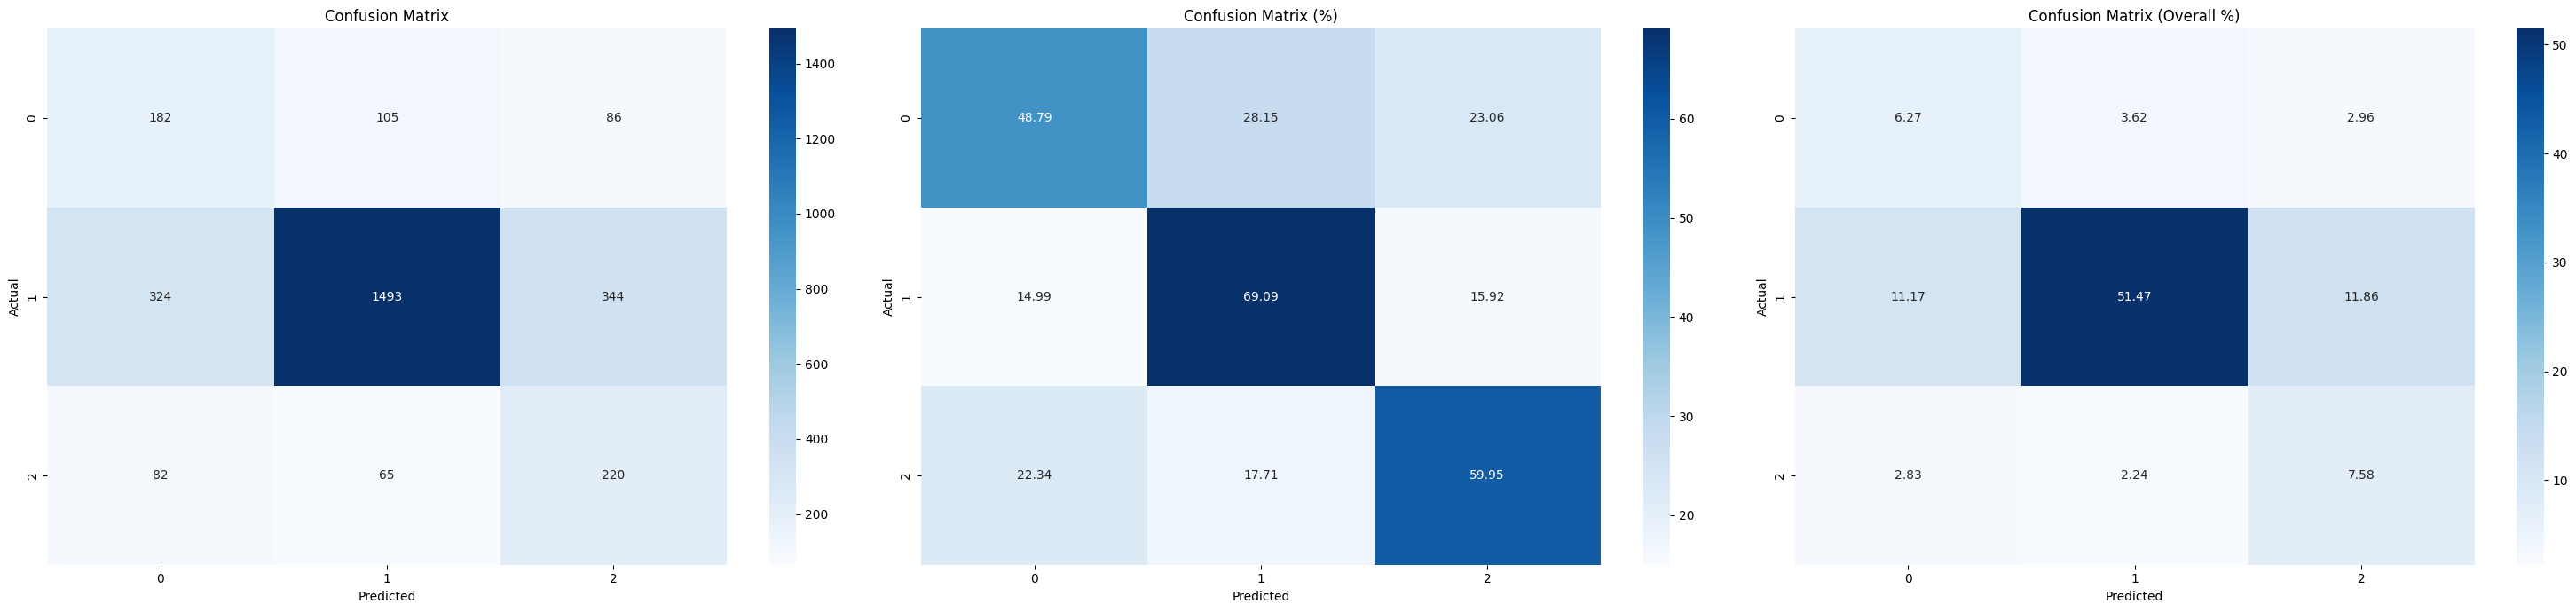

/tmp/ipykernel_83025/182827254.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


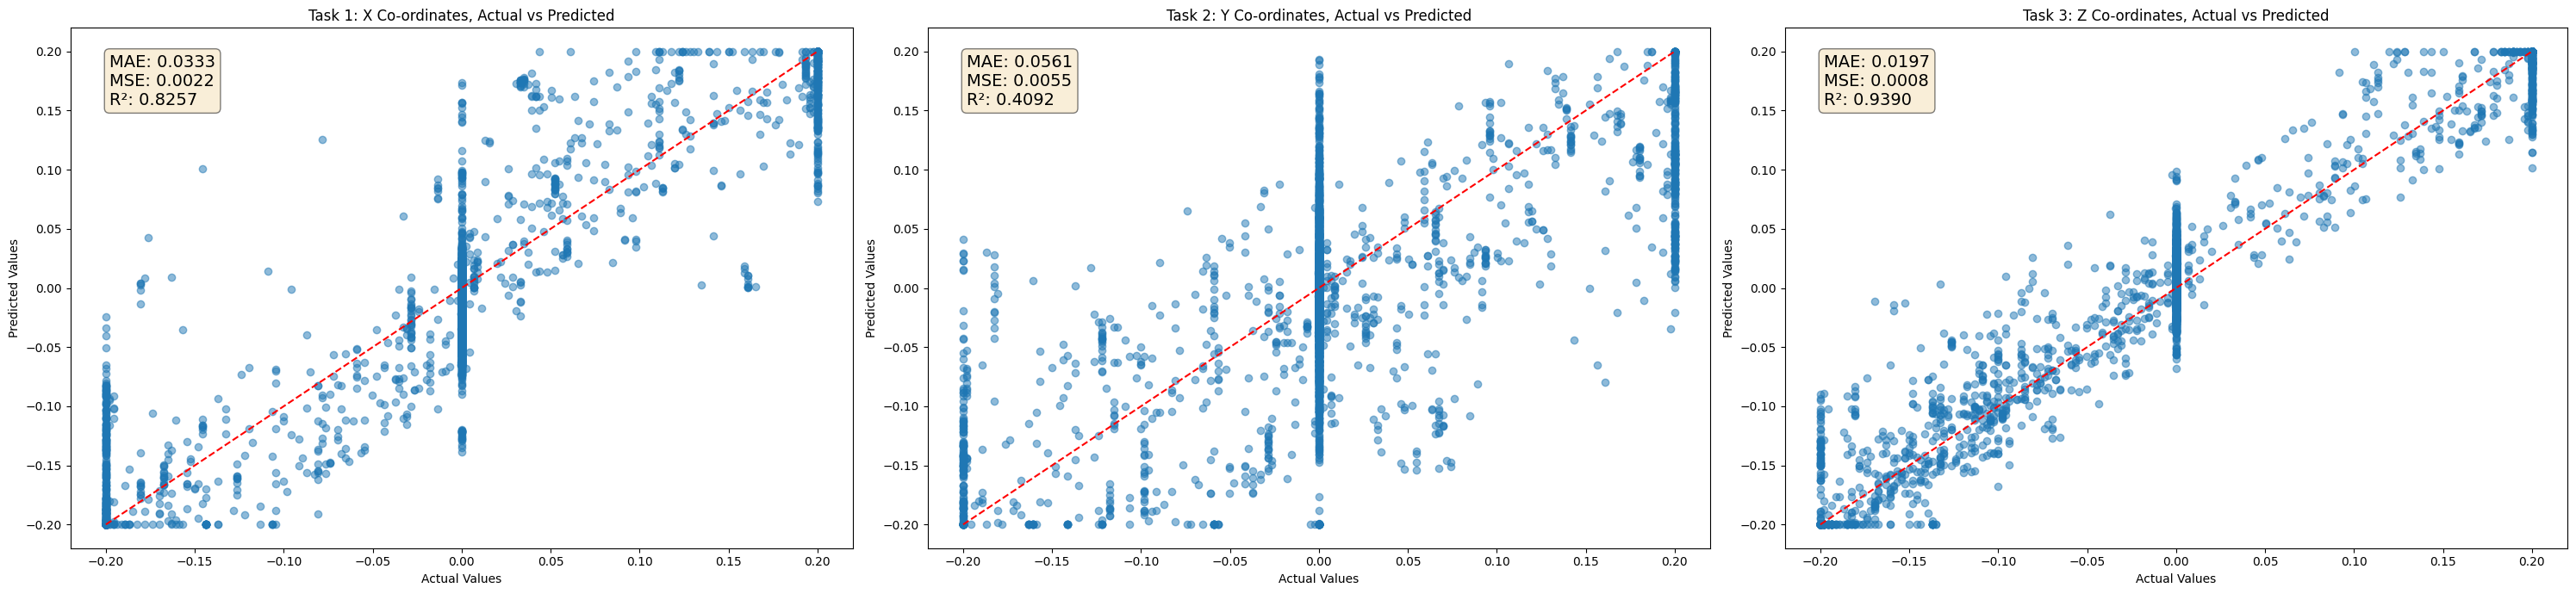

In [65]:
run_evaluation(
    model_class=exp3,
    classification_checkpoint_path='./wandb/latest-run/files/agent_checkpoints/mdl_chkpnt_epoch_18.pt',
    regression_checkpoint_path='./wandb/latest-run/files/agent_checkpoints/mdl_chkpnt_epoch_18.pt',
    val_dataloader=exp3_val_dataloader,
    image_encoder=exp3_image_encoder,
    obs_encoder=exp3_obs_encoder,
    dense=exp3_dense,
    run_no_ensemble=False,
    save_classification_file='exp3_classification_model.pt',
    save_regression_file='exp3_regression_model.pt',
    if_save=True
)

### Question 2 Self-supervised pretraining with VAEs

This question requires you to implement a self-supervised approach using a VAE architecture. The focus of question 2 is in developing a VAE model without using __any__ supervised information i.e., without using any action information. You will assess the convergence of the model and the suitability of the learnt latent space. You are required to select and appropriate architecture/loss function/target set of observations to perform self-supervised learning over.

__IMPORTANT__: Do not use any of the __action__ information. You will be awarded 0 marks if you do.

In [38]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchsummary import summary
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler

import matplotlib.pyplot as plt
import pandas as pd
import altair as alt

In [39]:
# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
device="cpu"

Using cuda device


In [40]:
def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

In [41]:
_keys = [
    "actions","front_cam_ob",
    "mount_cam_ob","terminals",
    "ee_cartesian_pos_ob",
    "ee_cartesian_vel_ob",
    "joint_pos_ob"
    ]
train_nps_new = load_all_files(train_dh.loc,"train_[0-9]+.h5",keys=_keys)
val_nps_new = load_all_files(val_dh.loc,"val_[0-9]+.h5",keys=_keys)
test_nps_new = load_all_files(test_dh.loc,"test_[0-9]+.h5",keys=_keys)

train_nps_new, val_nps_new, test_nps_new = additional_preprocessing(ROOT_PATH, train_nps_new, val_nps_new, test_nps_new)


100%|██████████| 5/5 [00:16<00:00,  3.22s/it]


(35722, 5)
Transitions excluded: 0.5418200474571924
Train - Unique Episodes: 453, Terminals Count: 453
Validation - Unique Episodes: 51, Terminals Count: 51
Test - Unique Episodes: 126, Terminals Count: 126


/tmp/ipykernel_83025/1653985452.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tran_df_sub["is_test"] = np.where(
/tmp/ipykernel_83025/1653985452.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tran_df_sub["is_val"] = np.where(
/tmp/ipykernel_83025/1653985452.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [42]:
train_nps_new.keys()

dict_keys(['actions', 'front_cam_ob', 'mount_cam_ob', 'terminals', 'ee_cartesian_pos_ob', 'ee_cartesian_vel_ob', 'joint_pos_ob', 'episode', 'episode_length'])

In [43]:
for key in train_nps_new.keys():
    print(f"{key}: {train_nps_new[key].shape}")

actions: (25469, 4)
front_cam_ob: (25469, 224, 224)
mount_cam_ob: (25469, 224, 224)
terminals: (25469, 1)
ee_cartesian_pos_ob: (25469, 7)
ee_cartesian_vel_ob: (25469, 6)
joint_pos_ob: (25469, 2)
episode: (25469, 1)
episode_length: (25469, 1)


In [44]:
# ******* INSERT YOUR CODE HERE *******

batch_size = 100

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255),
    transforms.ColorJitter(brightness=0.2),  # Only brightness will have an effect for black and white images
])

def denormalize(x):
    return x

class DualCamObDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        self.front_cam_data = data_dict['front_cam_ob']
        self.mount_cam_data = data_dict['mount_cam_ob']
        self.labels = data_dict['actions']
        self.transform = transform

    def __len__(self):
        return len(self.front_cam_data)

    def __getitem__(self, idx):
        front_cam_sample = self.front_cam_data[idx]
        mount_cam_sample = self.mount_cam_data[idx]
        label = self.labels[idx]
        if self.transform:
            front_cam_sample = self.transform(front_cam_sample)
            mount_cam_sample = self.transform(mount_cam_sample)
        # Concatenate along the channel dimension
        combined_sample = torch.cat((front_cam_sample, mount_cam_sample), dim=0)
        return combined_sample, label

# Dataset Class for the Front and Mount Camera Observations
training_data = DualCamObDataset(
    data_dict=train_nps_new,
    transform=data_transforms,
)

# Calculate class weights
classification_targets = train_nps_new['actions'][:, -1]
class_counts = Counter(classification_targets)
total_samples = len(classification_targets)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
class_weights_tensor = torch.tensor([class_weights[cls] for cls in sorted(class_weights.keys())], dtype=torch.float)

# Create a list of sample weights
sample_weights = [class_weights[target] for target in classification_targets]
sample_weights_tensor = torch.tensor(sample_weights, dtype=torch.float)

# Create the sampler
# sampler = WeightedRandomSampler(weights=sample_weights_tensor, num_samples=len(sample_weights_tensor), replacement=True)

train_dataloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    # sampler=sampler,
    shuffle=True,  # Use shuffle instead of sampler
)

val_data = DualCamObDataset(
    data_dict=val_nps_new,
    transform=data_transforms,
)

val_dataloader = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
)

# ******* INSERT YOUR CODE HERE - END *******

torch.Size([100, 2, 224, 224])


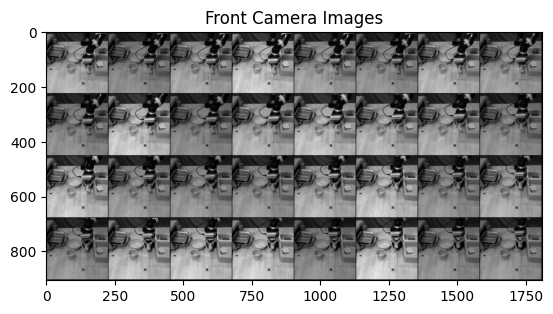

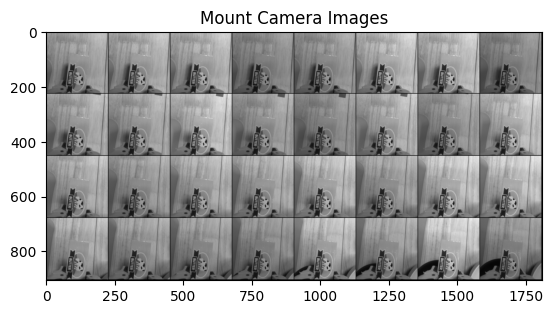

In [45]:
# Get the first batch from the dataloader
first_batch, _ = next(iter(val_dataloader))

# Print the first batch to see its structure
print(first_batch.shape)

# Unpack the first batch
sample_inputs = first_batch

# Select the first 32 samples
fixed_input = sample_inputs[0:32, :, :, :]

# Convert to float32
fixed_input = fixed_input.to(torch.float32)

# Split the input into two images
front_cam_images = fixed_input[:, :1, :, :] 
mount_cam_images = fixed_input[:, 1:, :, :]

# Visualise the original images of the front camera
front_img = make_grid(denormalize(front_cam_images), nrow=8, padding=2, normalize=False, scale_each=False, pad_value=0)
plt.figure()
plt.title("Front Camera Images")
plt.imshow(front_img.permute(1, 2, 0), cmap='gray')  # Convert from CHW to HWC format for visualization
plt.show()

# Visualise the original images of the mount camera
mount_img = make_grid(denormalize(mount_cam_images), nrow=8, padding=2, normalize=False, scale_each=False, pad_value=0)
plt.figure()
plt.title("Mount Camera Images")
plt.imshow(mount_img.permute(1, 2, 0), cmap='gray')  # Convert from CHW to HWC format for visualization
plt.show()

In [46]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder for front_cam_ob
        self.encoder_front = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),  # 112x112
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),  # 56x56
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),  # 28x28
        )
        
        # Encoder for mount_cam_ob
        self.encoder_mount = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),  # 112x112
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),  # 56x56
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),  # 28x28
        )
        
        # Shared latent space
        self.linear_mu = nn.Linear(64 * 28 * 28, latent_dim)
        self.linear_logvar = nn.Linear(64 * 28 * 28, latent_dim)
        self.decoder_input = nn.Linear(latent_dim, 64 * 28 * 28)
        
        # Decoder for front_cam_ob
        self.decoder_front = nn.Sequential(
            nn.Upsample(scale_factor=2),  # 56x56
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),  # 112x112
            nn.Conv2d(32, 16, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),  # 224x224
            nn.Conv2d(16, 1, 3, 1, 1),
            nn.Sigmoid(),
        )
        
        # Decoder for mount_cam_ob
        self.decoder_mount = nn.Sequential(
            nn.Upsample(scale_factor=2),  # 56x56
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),  # 112x112
            nn.Conv2d(32, 16, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),  # 224x224
            nn.Conv2d(16, 1, 3, 1, 1),
            nn.Sigmoid(),
        )

    def encode(self, x, encoder):
        x = encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        mu = self.linear_mu(x)
        logvar = self.linear_logvar(x)
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, decoder):
        z = self.decoder_input(z)
        z = z.view(z.size(0), 64, 28, 28)  # Reshape the tensor
        z = decoder(z)
        return z

    def forward(self, x_front, x_mount):
        mu_front, logvar_front = self.encode(x_front, self.encoder_front)
        mu_mount, logvar_mount = self.encode(x_mount, self.encoder_mount)
        
        z_front = self.reparametrize(mu_front, logvar_front)
        z_mount = self.reparametrize(mu_mount, logvar_mount)
        
        recon_front = self.decode(z_front, self.decoder_front)
        recon_mount = self.decode(z_mount, self.decoder_mount)
        
        return mu_front, logvar_front, recon_front, mu_mount, logvar_mount, recon_mount

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 10  # Experiment with this!
model = VAE(latent_dim).to(device)  # Move the model to the GPU

# Print model summary for the entire model
summary(model, [(1, 224, 224), (1, 224, 224)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             160
         LeakyReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
         LeakyReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
         LeakyReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
           Linear-10                   [-1, 10]         501,770
           Linear-11                   [-1, 10]         501,770
           Conv2d-12         [-1, 16, 224, 224]             160
        LeakyReLU-13         [-1, 16, 224, 224]               0
        MaxPool2d-14         [-1, 16, 1

### Question 2.a Self-supervised VAE model (5 marks)

##### Task
- Implement the full model training process and model definiton in the code block below. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [47]:
# Define the log-cosh loss function
def log_cosh_loss(y_true, y_pred):
    """ref: https://openreview.net/forum?id=rkglvsC9Ym"""
    loss = torch.log(torch.cosh(y_pred - y_true))
    return torch.sum(loss)

# Define the VAE loss function
def loss_function_VAE(recon_x_front, x_front, recon_x_mount, x_mount, mu_front, logvar_front, mu_mount, logvar_mount, beta, use_logcosh=False):
    if use_logcosh:
        reconstruction_loss_front = log_cosh_loss(x_front, recon_x_front)
        reconstruction_loss_mount = log_cosh_loss(x_mount, recon_x_mount)
    else:
        reconstruction_loss_front = torch.pow(recon_x_front - x_front, 2).sum()
        reconstruction_loss_mount = torch.pow(recon_x_mount - x_mount, 2).sum()
    
    reconstruction_loss = reconstruction_loss_front + reconstruction_loss_mount

    KL_divergence_front = 0.5 * torch.sum(1 + logvar_front - mu_front**2 - torch.exp(logvar_front))
    KL_divergence_mount = 0.5 * torch.sum(1 + logvar_mount - mu_mount**2 - torch.exp(logvar_mount))
    KL_divergence = KL_divergence_front + KL_divergence_mount

    return reconstruction_loss_front, reconstruction_loss_mount, reconstruction_loss, -beta * KL_divergence_front, -beta * KL_divergence_mount, -beta * KL_divergence

latent_dim = 160 
num_epochs = 30
beta = 0.7
batch_size = 100

# Load the VAE
model = VAE(latent_dim).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Cosine annealing scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

train_reconstruction_loss_front = []
train_reconstruction_loss_mount = []
train_KL_loss_front = []
train_KL_loss_mount = []
train_tot_losses = []

val_reconstruction_loss_front = []
val_reconstruction_loss_mount = []
val_KL_loss_front = []
val_KL_loss_mount = []
val_tot_losses = []

# Initialise best_val_loss with a high value
best_val_loss = float('inf')

# Convolutional implementation training
for epoch in range(num_epochs):
    # Train
    epoch_reconstruction_loss_front = 0
    epoch_reconstruction_loss_mount = 0
    epoch_KL_loss_front = 0
    epoch_KL_loss_mount = 0
    epoch_tot_loss = 0

    for t, (x, _) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        # Separate the channels
        x_front = x[:, 0, :, :].unsqueeze(1).to(device=device, dtype=torch.float32)
        x_mount = x[:, 1, :, :].unsqueeze(1).to(device=device, dtype=torch.float32)
        
        mu_front, logvar_front, recon_x_front, mu_mount, logvar_mount, recon_x_mount = model(x_front, x_mount)
        
        reconstruction_loss_front, reconstruction_loss_mount, reconstruction_loss, KL_loss_front, KL_loss_mount, KL_loss = loss_function_VAE(
            recon_x_front.reshape(-1, 1*224*224), x_front.reshape(-1, 1*224*224),
            recon_x_mount.reshape(-1, 1*224*224), x_mount.reshape(-1, 1*224*224),
            mu_front, logvar_front, mu_mount, logvar_mount, beta,
            use_logcosh=True
        )
        tot_loss = reconstruction_loss + KL_loss

        tot_loss.backward()
        optimizer.step()

        epoch_reconstruction_loss_front += reconstruction_loss_front.item()
        epoch_reconstruction_loss_mount += reconstruction_loss_mount.item()
        epoch_KL_loss_front += KL_loss_front.item()
        epoch_KL_loss_mount += KL_loss_mount.item()
        epoch_tot_loss += tot_loss.item()

    train_reconstruction_loss_front.append(epoch_reconstruction_loss_front / len(train_dataloader.dataset))
    train_reconstruction_loss_mount.append(epoch_reconstruction_loss_mount / len(train_dataloader.dataset))
    train_KL_loss_front.append(epoch_KL_loss_front / len(train_dataloader.dataset))
    train_KL_loss_mount.append(epoch_KL_loss_mount / len(train_dataloader.dataset))
    train_tot_losses.append(epoch_tot_loss / len(train_dataloader.dataset))

    print("Epoch: %d, train loss = %.4f" % (epoch, train_tot_losses[-1]))

    # Validation
    val_reconstruction_loss_front_epoch = 0
    val_reconstruction_loss_mount_epoch = 0
    val_KL_loss_front_epoch = 0
    val_KL_loss_mount_epoch = 0
    val_tot_loss_epoch = 0

    with torch.no_grad():
        for x_val, _ in val_dataloader:
            # Separate the channels
            x_front_val = x_val[:, 0, :, :].unsqueeze(1).to(device=device, dtype=torch.float32)
            x_mount_val = x_val[:, 1, :, :].unsqueeze(1).to(device=device, dtype=torch.float32)
            
            mu_front_val, logvar_front_val, recon_x_front_val, mu_mount_val, logvar_mount_val, recon_x_mount_val = model(x_front_val, x_mount_val)
            
            reconstruction_loss_front_val, reconstruction_loss_mount_val, reconstruction_loss_val, KL_loss_front_val, KL_loss_mount_val, KL_loss_val = loss_function_VAE(
                recon_x_front_val.reshape(-1, 1*224*224), x_front_val.reshape(-1, 1*224*224),
                recon_x_mount_val.reshape(-1, 1*224*224), x_mount_val.reshape(-1, 1*224*224),
                mu_front_val, logvar_front_val, mu_mount_val, logvar_mount_val, beta,
                use_logcosh=True
            )
            val_loss = reconstruction_loss_val + KL_loss_val

            val_reconstruction_loss_front_epoch += reconstruction_loss_front_val.item()
            val_reconstruction_loss_mount_epoch += reconstruction_loss_mount_val.item()
            val_KL_loss_front_epoch += KL_loss_front_val.item()
            val_KL_loss_mount_epoch += KL_loss_mount_val.item()
            val_tot_loss_epoch += val_loss.item()

    val_reconstruction_loss_front.append(val_reconstruction_loss_front_epoch / len(val_dataloader.dataset))
    val_reconstruction_loss_mount.append(val_reconstruction_loss_mount_epoch / len(val_dataloader.dataset))
    val_KL_loss_front.append(val_KL_loss_front_epoch / len(val_dataloader.dataset))
    val_KL_loss_mount.append(val_KL_loss_mount_epoch / len(val_dataloader.dataset))
    val_tot_losses.append(val_tot_loss_epoch / len(val_dataloader.dataset))

    print("Epoch: %d, val loss = %.4f" % (epoch, val_tot_losses[-1]))

    # Save the model if the validation loss is the best we've seen so far
    if val_tot_losses[-1] < best_val_loss:
        best_val_loss = val_tot_losses[-1]
        torch.save(model.state_dict(), 'best_VAE_model.pt')
        print("Saved best model with val loss: %.4f" % best_val_loss)

    scheduler.step()

Total number of parameters is: 24228034
VAE(
  (encoder_front): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_mount): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(n

### Question 2.b Model convergence (12 marks)

##### Task
- Provide empirical evidence (in the form of appropriate training/validation metrics) supporting **why** the model is appropriately trained;
- Interpret why the metrics demonstrate that the model has converged. If your model has **not** converged, interpret why the metrics suggest so.

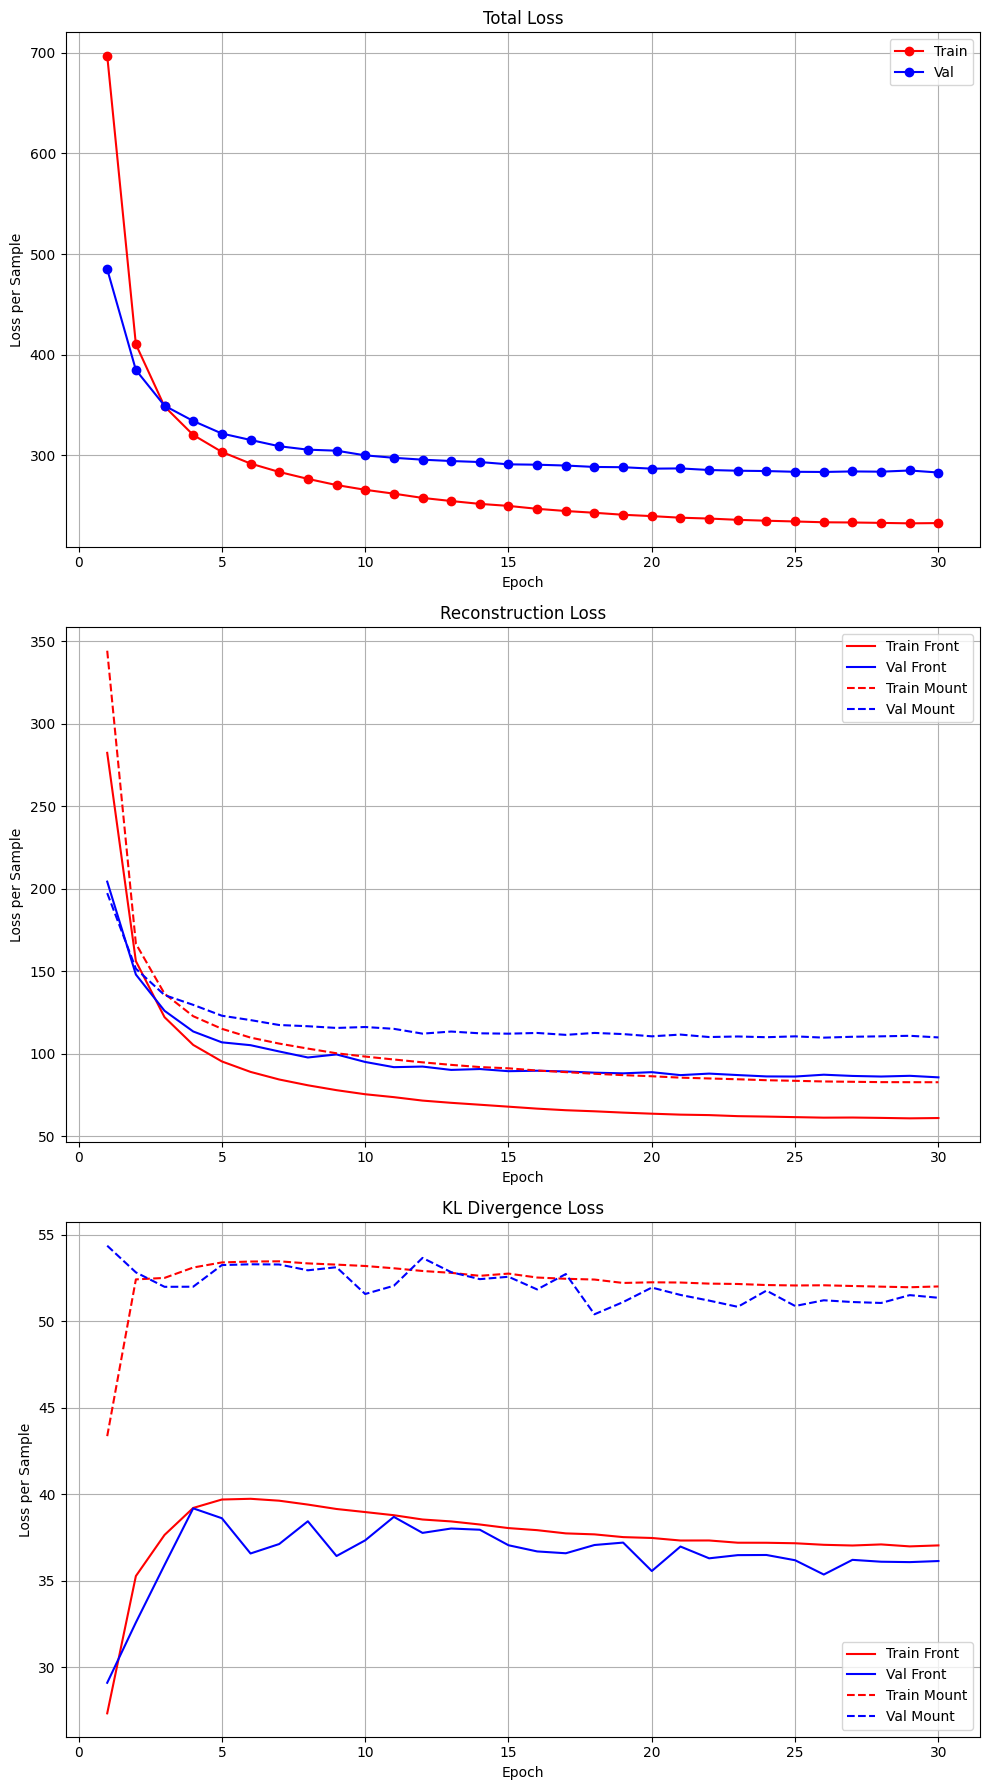

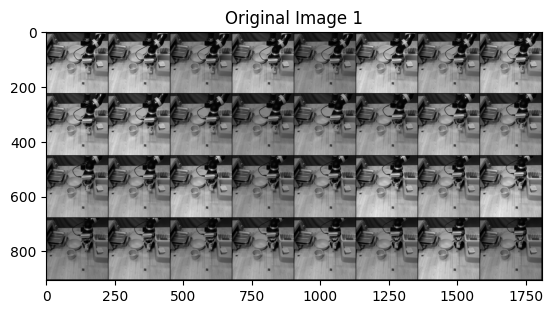

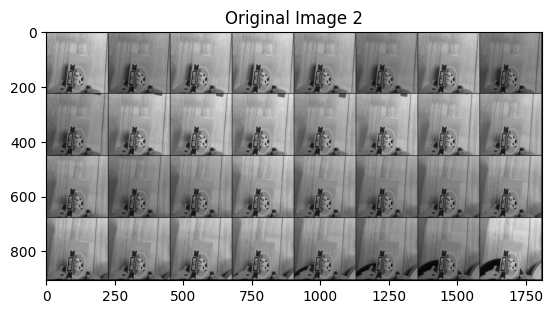

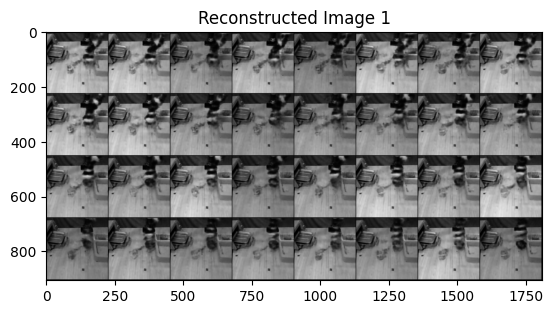

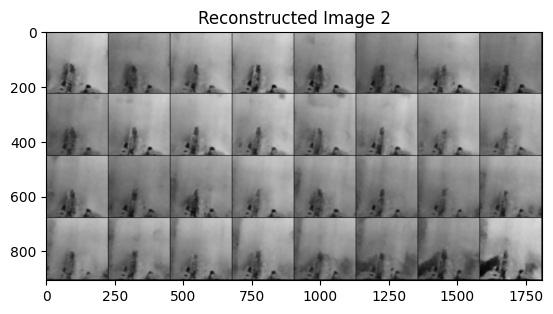

In [48]:
# Set the number of epochs
epochs = range(1, num_epochs + 1)

fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Total Loss
axs[0].plot(epochs, train_tot_losses, "-ro", label="Train")
axs[0].plot(epochs, val_tot_losses, "-bo", label="Val")
axs[0].set_title("Total Loss")
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss per Sample')
axs[0].legend()
axs[0].grid(True)

# Reconstruction Loss
axs[1].plot(epochs, train_reconstruction_loss_front, "-r", label="Train Front")
axs[1].plot(epochs, val_reconstruction_loss_front, "-b", label="Val Front")
axs[1].plot(epochs, train_reconstruction_loss_mount, "--r", label="Train Mount")
axs[1].plot(epochs, val_reconstruction_loss_mount, "--b", label="Val Mount")
axs[1].set_title("Reconstruction Loss")
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss per Sample')
axs[1].legend()
axs[1].grid(True)

# KL Divergence Loss
axs[2].plot(epochs, train_KL_loss_front, "-r", label="Train Front")
axs[2].plot(epochs, val_KL_loss_front, "-b", label="Val Front")
axs[2].plot(epochs, train_KL_loss_mount, "--r", label="Train Mount")
axs[2].plot(epochs, val_KL_loss_mount, "--b", label="Val Mount")
axs[2].set_title("KL Divergence Loss")
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss per Sample')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Input images
model.eval()
sample_inputs, labels = next(iter(val_dataloader))  # Unpacked labels here
sample_inputs = sample_inputs.float().to(device)  # Ensure the input is float type
fixed_input = sample_inputs[0:32, :, :, :]

# Visualise the original images of the last batch of the val set
img1 = make_grid(denormalize(fixed_input[:, 0, :, :].unsqueeze(1)), nrow=8, padding=2, normalize=False, scale_each=False, pad_value=0)
img2 = make_grid(denormalize(fixed_input[:, 1, :, :].unsqueeze(1)), nrow=8, padding=2, normalize=False, scale_each=False, pad_value=0)

plt.figure()
plt.title("Original Image 1")
show(img1)

plt.figure()
plt.title("Original Image 2")
show(img2)

# Reconstructed images
with torch.no_grad():
    # Separate the channels for the model input
    x_front = sample_inputs[:, 0, :, :].unsqueeze(1).to(device)
    x_mount = sample_inputs[:, 1, :, :].unsqueeze(1).to(device)
    
    # Get the reconstructed images from the model
    _, _, recon_x_front, _, _, recon_x_mount = model(x_front, x_mount)
    
    # Combine the reconstructed channels
    recon_batch = torch.cat((recon_x_front, recon_x_mount), dim=1)
    recon_batch = recon_batch[0:32, :, :, :]
    recon_batch = recon_batch.cpu()

    recon_img1 = make_grid(denormalize(recon_batch[:, 0, :, :].unsqueeze(1)), nrow=8, padding=2, normalize=False, scale_each=False, pad_value=0)
    recon_img2 = make_grid(denormalize(recon_batch[:, 1, :, :].unsqueeze(1)), nrow=8, padding=2, normalize=False, scale_each=False, pad_value=0)

    plt.figure()
    plt.title("Reconstructed Image 1")
    show(recon_img1)

    plt.figure()
    plt.title("Reconstructed Image 2")
    show(recon_img2)

##### Answer

The model has converged as evidenced by the training/validation metrics. The total loss, reconstruction loss, and KL divergence have stabilised for both the front and mount cameras.

1. Reconstruction Loss: The reconstruction loss for the front camera is lower than for the mount camera. This is evident from the reconstructed images, where the front camera reconstructions are clear and closely resemble the original images, while the mount camera reconstructions are blurry and less accurate.

2. KL Divergence: The KL divergence for the front camera is within an acceptable range (approx 35), indicating a reasonable relationship between the prior and inferred distributions. However, the KL divergence for the mount camera is higher (approx 55), suggesting a significant divergence from the prior distribution.

These metrics demonstrate that the model is performative for the front camera but not for the mount camera. The higher reconstruction loss and KL divergence for the mount camera indicate that the model struggles to accurately reconstruct these images, suggesting that a VAE of greater complexity or model adjustments may be necessary for better convergence.


### Question 2.c Latent space analysis (6 marks)

##### Task
- Using reasonable analysis, conclude whether the representation learnt by the self-supervised method will be beneficial for the downstream supervised task. **Empirical evidence** should be provided **however**, references to the performance of the self-superised method with a supervised head on the downstream task will be awarded __0 marks__. 

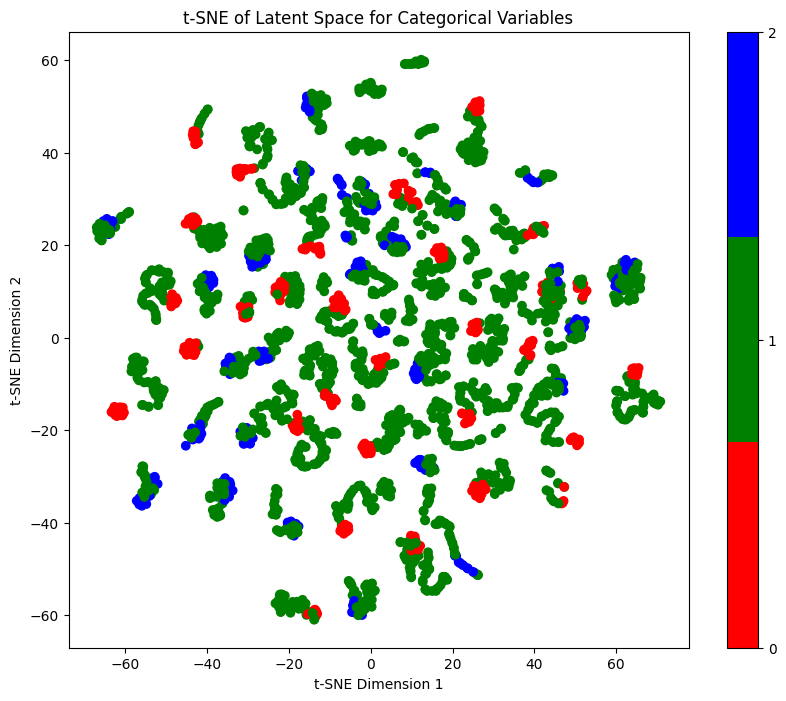

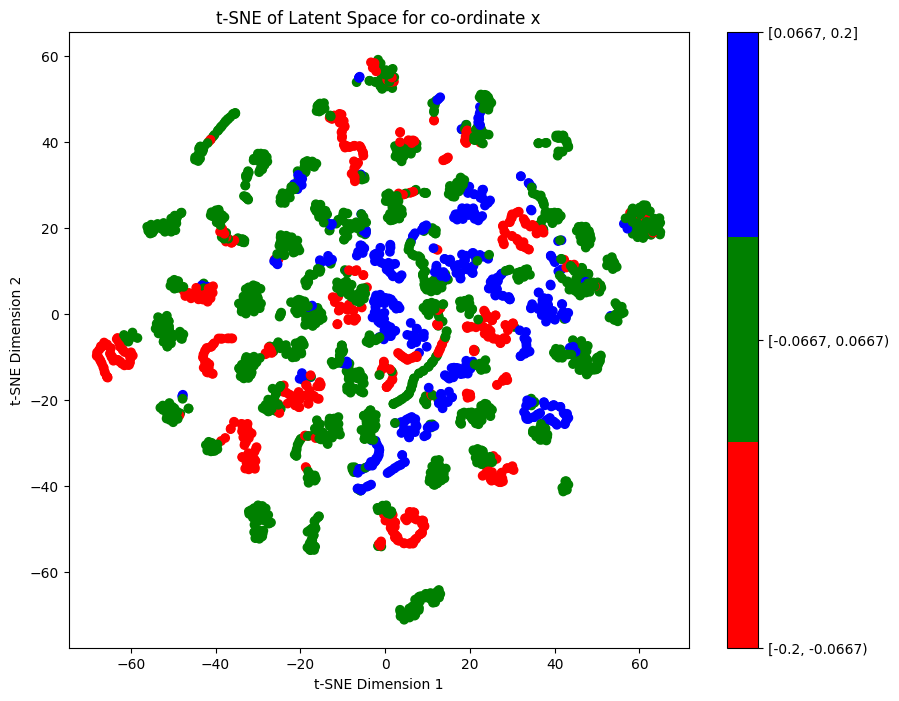

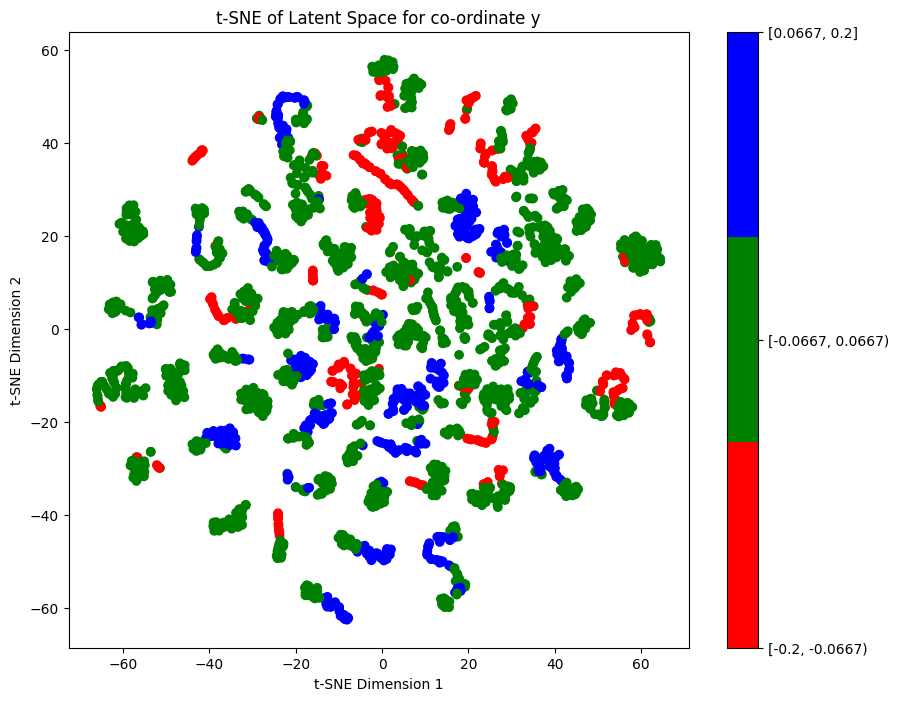

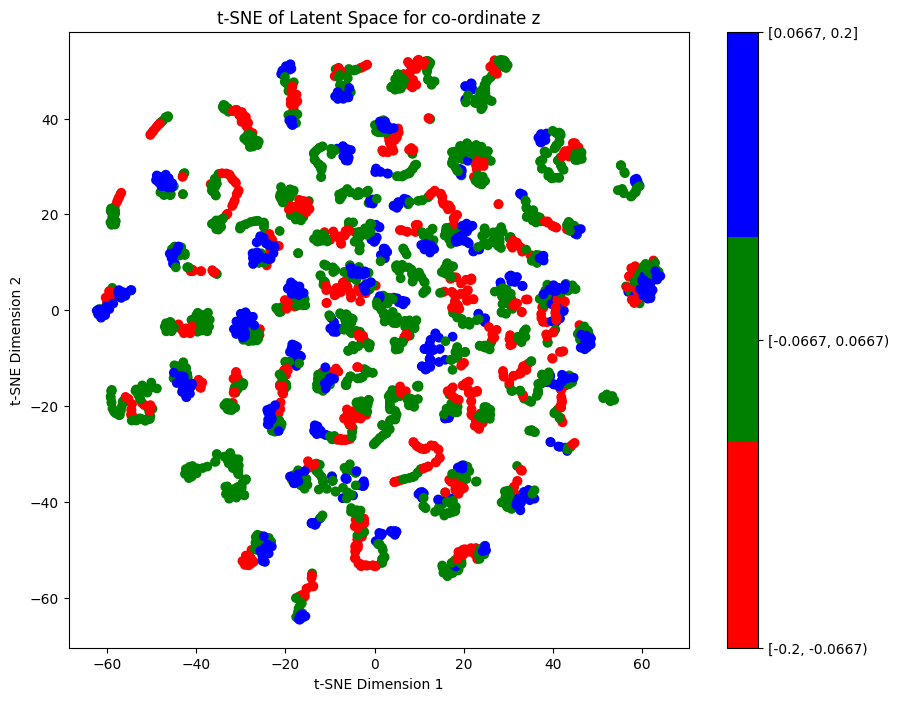

In [49]:
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap

# Put the model into evaluation mode
model.eval()
latent_vectors = []
labels = []

with torch.no_grad():
    for data, label in val_dataloader:
        # Separate the channels for the model input
        x_front = data[:, 0, :, :].unsqueeze(1).to(device).float()
        x_mount = data[:, 1, :, :].unsqueeze(1).to(device).float()
        
        # Encode the data to get the latent vectors
        mu_front, logvar_front = model.encode(x_front, model.encoder_front)
        mu_mount, logvar_mount = model.encode(x_mount, model.encoder_mount)
        
        # Combine the latent vectors
        mu = torch.cat((mu_front, mu_mount), dim=1)
        logvar = torch.cat((logvar_front, logvar_mount), dim=1)
        
        z = model.reparametrize(mu, logvar)
        latent_vectors.append(z.cpu().numpy())
        labels.append(label[:, -1].cpu().numpy())  # Use only the final column of the labels

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(labels, axis=0)

# Apply t-SNE to the latent vectors
tsne = TSNE(n_components=2)
z_embedded = tsne.fit_transform(latent_vectors)

# Define a discrete color map
cmap = ListedColormap(['red', 'green', 'blue'])

# Plot the t-SNE results for categorical variables
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=labels, cmap=cmap)
plt.colorbar(scatter, ticks=[0, 1, 2])
plt.title('t-SNE of Latent Space for Categorical Variables')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

# Put the model into evaluation mode
model.eval()
latent_vectors = []
labels = []

with torch.no_grad():
    for data, label in val_dataloader:
        # Separate the channels for the model input
        x_front = data[:, 0, :, :].unsqueeze(1).to(device).float()
        x_mount = data[:, 1, :, :].unsqueeze(1).to(device).float()
        
        # Encode the data to get the latent vectors
        mu_front, logvar_front = model.encode(x_front, model.encoder_front)
        mu_mount, logvar_mount = model.encode(x_mount, model.encoder_mount)
        
        # Combine the latent vectors
        mu = torch.cat((mu_front, mu_mount), dim=1)
        logvar = torch.cat((logvar_front, logvar_mount), dim=1)
        
        z = model.reparametrize(mu, logvar)
        latent_vectors.append(z.cpu().numpy())
        labels.append(label.cpu().numpy())  # Use all columns of the labels

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(labels, axis=0)

# Define a discrete color map
cmap = ListedColormap(['red', 'green', 'blue'])

# Define the coordinate labels
coordinate_labels = ['co-ordinate x', 'co-ordinate y', 'co-ordinate z']

# Loop through the preceding columns
for i in range(labels.shape[1] - 1):
    # Categorize labels into three ranges: [-0.2, -0.0667), [-0.0667, 0.0667), [0.0667, 0.2]
    bins = np.array([-0.2, -0.0667, 0.0667, 0.2])
    categorized_labels = np.digitize(labels[:, i], bins) - 1  # Subtract 1 to get labels in range [0, 1, 2]

    # Apply t-SNE to the latent vectors
    tsne = TSNE(n_components=2)
    z_embedded = tsne.fit_transform(latent_vectors)

    # Plot the t-SNE results for coordinate ranges
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=categorized_labels, cmap=cmap)
    cbar = plt.colorbar(scatter, ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['[-0.2, -0.0667)', '[-0.0667, 0.0667)', '[0.0667, 0.2]'])
    plt.title(f't-SNE of Latent Space for {coordinate_labels[i]}')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

##### Answer

A T-SNE map is utilised to view the latent space. T-SNE is used because it employs a cost function based on KL divergence, which shares some similarities with the loss function of a VAE. Furthermore, T-SNE is a useful dimensionality reduction technique that provides meaningful visualisations by clustering similar outputs together. However, it is important to note that the distances between clusters in the T-SNE map do not have a meaningful interpretation.

There is little linear separability between the categorical or regression variables and the targets. This suggests that the model will find it difficult to create meaningful relationships from the latent space.

The latent space suggests that the data is highly sequential. Often, data can be observed where two or three of the targets are clustered, but appear separable within that cluster. This would make sense, as each episode will have similar data but within that episode, all of the observational ranges may be observed. The ability to include a 3rd dimension, time series, in the images batches could improve the quality of the latent space by capturing the sequential nature of these relationships.

### Question 3 Full model training
This question requires you to first develop a supervised head which utilises the latent space from your self-supervised method. You are then required to assess the models performance as well as the model you developed in question 1.c.i on the test set, report the performance and conclude whether self-supervised learning is appropriate for this task.

In [50]:
def evaluate_vae_classification_model(classification_model, dataloader):
    classification_model.eval()
    all_class_preds = []
    all_class_targets = []

    with torch.no_grad():
        for batch in dataloader:
            front_cam_ob = batch.input["front_cam_ob"]
            mount_cam_ob = batch.input["mount_cam_ob"]
            obs = batch.input["obs"]
            class_targets = batch.output["grp"].argmax(dim=1)

            if torch.cuda.is_available():
                front_cam_ob = front_cam_ob.cuda()
                mount_cam_ob = mount_cam_ob.cuda()
                obs = obs.cuda()
                class_targets = class_targets.cuda()

            # Get classification outputs
            class_outputs = classification_model(front_cam_ob=front_cam_ob, mount_cam_ob=mount_cam_ob, obs=obs)
            class_preds = class_outputs["grp"].argmax(dim=1)

            all_class_preds.append(class_preds.cpu().numpy())
            all_class_targets.append(class_targets.cpu().numpy())

    all_class_preds = np.concatenate(all_class_preds)
    all_class_targets = np.concatenate(all_class_targets)

    # Confusion matrix for classification tasks
    cm = confusion_matrix(all_class_targets, all_class_preds)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    cm_overall_percent = cm.astype('float') / cm.sum() * 100

    fig, axes = plt.subplots(1, 3, figsize=(30, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_title('Confusion Matrix')

    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    axes[1].set_title('Confusion Matrix (%)')

    sns.heatmap(cm_overall_percent, annot=True, fmt='.2f', cmap='Blues', ax=axes[2])
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('Actual')
    axes[2].set_title('Confusion Matrix (Overall %)')

    plt.tight_layout()
    plt.show()

def evaluate_vae_regression_model(regression_model, dataloader):
    regression_model.eval()
    all_reg_preds = []
    all_reg_targets = []

    with torch.no_grad():
        for batch in dataloader:
            front_cam_ob = batch.input["front_cam_ob"]
            mount_cam_ob = batch.input["mount_cam_ob"]
            obs = batch.input["obs"]
            reg_targets = batch.output["pos"]

            if torch.cuda.is_available():
                front_cam_ob = front_cam_ob.cuda()
                mount_cam_ob = mount_cam_ob.cuda()
                obs = obs.cuda()
                reg_targets = reg_targets.cuda()

            # Get regression outputs
            reg_outputs = regression_model(front_cam_ob=front_cam_ob, mount_cam_ob=mount_cam_ob, obs=obs)
            reg_preds = reg_outputs["pos"]

            all_reg_preds.append(reg_preds.cpu().numpy())
            all_reg_targets.append(reg_targets.cpu().numpy())

    all_reg_preds = np.concatenate(all_reg_preds, axis=0)
    all_reg_targets = np.concatenate(all_reg_targets, axis=0)

    task_names = ["X Co-ordinates", "Y Co-ordinates", "Z Co-ordinates"]
    num_tasks = all_reg_targets.shape[1]

    fig, axes = plt.subplots(1, num_tasks, figsize=(30, 7))

    for i in range(num_tasks):
        mae = mean_absolute_error(all_reg_targets[:, i], all_reg_preds[:, i])
        mse = mean_squared_error(all_reg_targets[:, i], all_reg_preds[:, i])
        r2 = r2_score(all_reg_targets[:, i], all_reg_preds[:, i])

        axes[i].scatter(all_reg_targets[:, i], all_reg_preds[:, i], alpha=0.5)
        axes[i].plot([all_reg_targets[:, i].min(), all_reg_targets[:, i].max()],
                     [all_reg_targets[:, i].min(), all_reg_targets[:, i].max()], 'r--')
        axes[i].set_xlabel('Actual Values')
        axes[i].set_ylabel('Predicted Values')
        axes[i].set_title(f'Task {i+1}: {task_names[i]}, Actual vs Predicted')

        textstr = f'MAE: {mae:.4f}\nMSE: {mse:.4f}\nR²: {r2:.4f}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        axes[i].text(0.05, 0.95, textstr, transform=axes[i].transAxes, fontsize=14,
                     verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()

In [51]:
def run_vae_evaluation(model_class, classification_checkpoint_path, regression_checkpoint_path,
                       val_dataloader, vae_model, obs_encoder, dense, 
                       classification_save_path, regression_save_path, 
                       run_no_ensemble=False):
    import torch
    from IPython.display import HTML, display

    def load_classification_model(model_class, checkpoint_path):
        # Create an instance of the classification model
        classification_model = model_class(
            vae_model=vae_model,
            obs_encoder=obs_encoder,
            dense=dense
        )

        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path)

        # Extract the model state dictionary
        model_state_dict = checkpoint['model_state_dict']

        # Load the state dictionary into the model
        classification_model.load_state_dict(model_state_dict)

        # Move the model to the appropriate device (CPU or GPU)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        classification_model.to(device)

        return classification_model

    def load_regression_model(model_class, checkpoint_path):
        # Create an instance of the regression model
        regression_model = model_class(
            vae_model=vae_model,
            obs_encoder=obs_encoder,
            dense=dense
        )

        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path)

        # Extract the model state dictionary
        model_state_dict = checkpoint['model_state_dict']

        # Load the state dictionary into the model
        regression_model.load_state_dict(model_state_dict)

        # Move the model to the appropriate device (CPU or GPU)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        regression_model.to(device)

        return regression_model

    def save_model(model, path):
        # Save the model state dictionary
        torch.save({'model_state_dict': model.state_dict()}, path)

    # Set the random seed for reproducibility
    torch.manual_seed(1)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(1)

    display(HTML("<h2>Data Evaluation</h2>"))

    # Load and evaluate the classification model
    improved_1_classification_model = load_classification_model(
        model_class=model_class,
        checkpoint_path=classification_checkpoint_path
    )
    evaluate_vae_classification_model(improved_1_classification_model, val_dataloader)
    save_model(improved_1_classification_model, classification_save_path)

    # Load and evaluate the regression model
    improved_1_regression_model = load_regression_model(
        model_class=model_class,
        checkpoint_path=regression_checkpoint_path
    )
    evaluate_vae_regression_model(improved_1_regression_model, val_dataloader)
    save_model(improved_1_regression_model, regression_save_path)

    if run_no_ensemble:
        display(HTML("<h2>Data Evaluation - No Ensemble</h2>"))

        # Load and evaluate the classification model
        improved_1_classification_model_no_ensemble = load_classification_model(
            model_class=model_class,
            checkpoint_path=classification_checkpoint_path
        )
        evaluate_classification_model(improved_1_classification_model_no_ensemble, val_dataloader)

        # Use the classification model for regression in the no ensemble case
        evaluate_regression_model(improved_1_classification_model_no_ensemble, val_dataloader)

### Question 3.a Combining self-supervised model with the downstream task (5 marks)

##### Task
- Develop a model which combines the self-supervised pretraining with a model for performing the downstream task by freezing the self-supervised model and fine-tuning a head for prediction and implement it in the code block below. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions). The supervised head should at least include any inputs that you did not feed into the self-supervised model. For example, assume you decide to perform self-supervised learning only using front_cam_ob images. You must also include mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob observations in your model.

In [ ]:
# Load the VAE model and freeze its weights
vae_model = VAE(latent_dim=160)
vae_model.load_state_dict(torch.load('best_VAE_model.pt'))
for param in vae_model.parameters():
    param.requires_grad = False

def run_vae_experiment(use_clamp=True, use_terminal_batch_sampler=True, use_weighted_sampler=True,
                   use_class_weights=True, use_dropout=True, use_episode_length=True):

    # Ensure the forward method of Final1 uses the correct keys
    class Final1(BaseModel):
        def __init__(self, vae_model: VAE, obs_encoder: MLP, dense: MLP) -> None:
            super().__init__()
            self.vae_model = vae_model
            self.obs_encoder = obs_encoder
            self.dense = dense
    
        def forward(self, front_cam_ob, mount_cam_ob, obs):
            with torch.no_grad():
                mu_front, logvar_front, _, mu_mount, logvar_mount, _ = self.vae_model(front_cam_ob, mount_cam_ob)
                latent_space_front = self.vae_model.reparametrize(mu_front, logvar_front)
                latent_space_mount = self.vae_model.reparametrize(mu_mount, logvar_mount)
                latent_space = latent_space_front + latent_space_mount  # Combine the latent spaces
    
            _obs_enc = self.obs_encoder(obs)
            _dense_enc = self.dense(latent_space + _obs_enc)
            pos = _dense_enc[:, 0:3]
            grp = _dense_enc[:, 3:]
    
            if use_clamp:
                pos = torch.clamp(pos, min=-0.2, max=0.2)
    
            return {
                "pos": pos,
                "grp": grp
            }
    
        def reset(self, obs_encoder_kwargs, dense_kwargs):
            self.obs_encoder.reset(**obs_encoder_kwargs)
            self.dense.reset(**dense_kwargs)
    
    obs_encoder_input_dim = 17 if use_episode_length else 15
    obs_encoder = MLP(
        input_dim=obs_encoder_input_dim,  # Conditional input dimension
        hidden_dims=[256,256],
        output_dim=160 # Latent space dimension
    )

    dense = MLP(
        input_dim=160, # Latent space dimension
        hidden_dims=[64,32],
        output_dim=6
    )

    torch.manual_seed(1)
    
    model = Final1(
        vae_model=vae_model,
        obs_encoder=obs_encoder,
        dense=dense
    )
    model.reset({}, {})
    exp_kwargs = {
        "batch_size": 64,
        "learning_rate": 0.001,
        "half_precision": True,
        "target_offset": 0
    }

    if project_options.debug:
        exp_kwargs["batch_size"] = 64  # amended from 4

    if exp_kwargs["half_precision"]:
        train_dataset = NpDictDataset(
            array_dict=train_nps,
            transform_lkp=global_transforms,
            dep_vars=["actions"],
            indep_vars=[
                "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
                "ee_cartesian_vel_ob", "joint_pos_ob"
            ] + (["episode_length"] if use_episode_length else []),
            target_offset=exp_kwargs["target_offset"]
        )

        val_dataset = NpDictDataset(
            array_dict=val_nps,
            transform_lkp=global_transforms,
            dep_vars=["actions"],
            indep_vars=[
                "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
                "ee_cartesian_vel_ob", "joint_pos_ob"
            ] + (["episode_length"] if use_episode_length else []),
            target_offset=exp_kwargs["target_offset"]
        )

        test_dataset = NpDictDataset(
            array_dict=test_nps,
            transform_lkp=global_transforms,
            dep_vars=["actions"],
            indep_vars=[
                "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
                "ee_cartesian_vel_ob", "joint_pos_ob"
            ] + (["episode_length"] if use_episode_length else []),
            target_offset=exp_kwargs["target_offset"]
        )
    else:
        train_dataset = NpDictDataset(
            array_dict={k: train_nps[k].astype(np.float32) for k in train_nps},
            transform_lkp=global_transforms,
            dep_vars=["actions"],
            indep_vars=[
                "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
                "ee_cartesian_vel_ob", "joint_pos_ob"
            ] + (["episode_length"] if use_episode_length else []),
            target_offset=exp_kwargs["target_offset"]
        )

        val_dataset = NpDictDataset(
            array_dict={k: val_nps[k].astype(np.float32) for k in val_nps},
            transform_lkp=global_transforms,
            dep_vars=["actions"],
            indep_vars=[
                "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
                "ee_cartesian_vel_ob", "joint_pos_ob"
            ] + (["episode_length"] if use_episode_length else []),
            target_offset=exp_kwargs["target_offset"]
        )

        test_dataset = NpDictDataset(
            array_dict={k: test_nps[k].astype(np.float32) for k in test_nps},
            transform_lkp=global_transforms,
            dep_vars=["actions"],
            indep_vars=[
                "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
                "ee_cartesian_vel_ob", "joint_pos_ob"
            ] + (["episode_length"] if use_episode_length else []),
            target_offset=exp_kwargs["target_offset"]
        )

    # Update the collate_func to include front_cam_ob and mount_cam_ob
    def collate_func(input_list: List[DatasetOutput]) -> DatasetOutput:
        pos = []
        _grp = []
        front_cam_ob = []
        mount_cam_ob = []
        obs = []
    
        for val in input_list:
            front_cam_ob.append(val.input["front_cam_ob"][None, :])
            mount_cam_ob.append(val.input["mount_cam_ob"][None, :])
            if use_episode_length:
                episode_length = val.input["episode_length"]
                if episode_length.ndim == 1:
                    episode_length = episode_length.unsqueeze(0)
                elif episode_length.ndim == 2 and episode_length.shape[0] == 1:
                    episode_length = episode_length.squeeze(0)
                obs.append(
                    torch.concat(
                        [
                            val.input["ee_cartesian_pos_ob"],
                            val.input["ee_cartesian_vel_ob"],
                            val.input["joint_pos_ob"],
                            episode_length
                        ],
                        dim=0
                    )[None, :]
                )
            else:
                obs.append(
                    torch.concat(
                        [
                            val.input["ee_cartesian_pos_ob"],
                            val.input["ee_cartesian_vel_ob"],
                            val.input["joint_pos_ob"]
                        ],
                        dim=0
                    )[None, :]
                )
            pos.append(val.output["actions"][0:3][None, :])
            _grp.append(val.output["actions"][-1:][None])
    
        _grp = torch.concat(_grp, dim=0)
        grp = torch.zeros(_grp.shape[0], 3)
        grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    
        return DatasetOutput(
            input={
                "front_cam_ob": torch.concat(front_cam_ob, dim=0),
                "mount_cam_ob": torch.concat(mount_cam_ob, dim=0),
                "obs": torch.concat(obs, dim=0),
            },
            output={
                "pos": torch.concat(pos, dim=0),
                "grp": grp
            }
        )


    # Extract the classification targets (last column)
    classification_targets = train_nps["actions"][:, -1]
    print(len(train_nps["actions"]))

    # Calculate class weights for classification targets
    class_counts = Counter(classification_targets)
    total_samples = len(classification_targets)
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

    print("Class counts:", class_counts)
    print("Total samples:", total_samples)
    print("Class weights:", class_weights)

    # Hardcoded class weights
    class_weights_tensor = torch.tensor([8.3, 1.3, 7.11], dtype=torch.float)
    print("Class weights tensor:", class_weights_tensor)

    # Move the class weights tensor to the appropriate device (e.g., GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    class_weights_tensor = class_weights_tensor.to(device)

    print("Class weights tensor:", class_weights_tensor)

    # Create a list of sample weights
    sample_weights = [class_weights[target] for target in classification_targets]
    print("Sample weights Length:", len(sample_weights))

    # Convert sample weights to a tensor
    sample_weights_tensor = torch.tensor(sample_weights, dtype=torch.float)

    # Create the sampler
    sampler = WeightedRandomSampler(weights=sample_weights_tensor, num_samples=len(train_nps["actions"]), replacement=True)

    grp_criterion = nn.CrossEntropyLoss(reduction="mean", weight=class_weights_tensor if use_class_weights else None)  # Conditional class weights

    class TerminalBatchSampler(Sampler):
        def __init__(self, sequences, weighted_sampler=None):
            self.sequences = sequences
            self.weighted_sampler = weighted_sampler

        def __iter__(self):
            if self.weighted_sampler:
                sampled_sequences = list(self.weighted_sampler)
            else:
                sampled_sequences = range(len(self.sequences))

            for seq_idx in sampled_sequences:
                yield self.sequences[seq_idx]

        def __len__(self):
            return len(self.sequences)

    # Group sequences for training and validation
    train_sequences = []
    sequence = []
    for idx, terminal in enumerate(train_nps['terminals']):
        sequence.append(idx)
        if terminal == 1:
            train_sequences.append(sequence)
            sequence = []
    if sequence:
        train_sequences.append(sequence)

    val_sequences = []
    sequence = []
    for idx, terminal in enumerate(val_nps['terminals']):
        sequence.append(idx)
        if terminal == 1:
            val_sequences.append(sequence)
            sequence = []
    if sequence:
        val_sequences.append(sequence)

    # Calculate sequence weights for training
    sequence_weights = []
    for sequence in train_sequences:
        sequence_targets = classification_targets[sequence]
        sequence_weight = sum(class_weights[target] for target in sequence_targets) / len(sequence_targets)
        sequence_weights.append(sequence_weight)
    sequence_weights_tensor = torch.tensor(sequence_weights, dtype=torch.float)

    # Create sequence-level sampler
    sequence_sampler = WeightedRandomSampler(weights=sequence_weights_tensor, num_samples=len(train_sequences), replacement=True)

    # Create batch samplers
    train_batch_sampler = TerminalBatchSampler(train_sequences, sequence_sampler if use_weighted_sampler else None) if use_terminal_batch_sampler else None
    val_batch_sampler = TerminalBatchSampler(val_sequences) if use_terminal_batch_sampler else None

    # Create DataLoaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_sampler=train_batch_sampler,
        collate_fn=collate_func,
    ) if train_batch_sampler else DataLoader(
        train_dataset,
        batch_size=exp_kwargs["batch_size"],
        shuffle=True,
        collate_fn=collate_func,
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_sampler=val_batch_sampler,
        collate_fn=collate_func,
    ) if val_batch_sampler else DataLoader(
        val_dataset,
        batch_size=exp_kwargs["batch_size"],
        shuffle=False,
        collate_fn=collate_func,
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=exp_kwargs["batch_size"],
        shuffle=False,
        collate_fn=collate_func,
    )

    first_batch = next(iter(train_dataloader))

    exp_kwargs["model_def"] = model.__repr__()

    if exp_kwargs["half_precision"]:
        model = model.half()
    
    optimizer = torch.optim.Adam(
        model.parameters(), lr=exp_kwargs["learning_rate"],
        eps=1e-04
    )

    __criterion = TrackerBalancedLoss(
        loss_lkp={
            "pos": pos_criterion,
            "grp": grp_criterion
        }
    )

    if exp_kwargs["half_precision"]:
        with torch.no_grad():
            if torch.cuda.is_available():
                model = model.cuda()
                with torch.autocast(device_type="cuda"):
                    res = model(
                        front_cam_ob=first_batch.input["front_cam_ob"].cuda(),
                        mount_cam_ob=first_batch.input["mount_cam_ob"].cuda(),
                        obs=first_batch.input["obs"].cuda()
                    )
                    first_batch.output["pos"] = first_batch.output["pos"].cuda()
                    first_batch.output["grp"] = first_batch.output["grp"].cuda()
            else:
                with torch.autocast(device_type="cpu"):
                    res = model(
                        front_cam_ob=first_batch.input["front_cam_ob"],
                        mount_cam_ob=first_batch.input["mount_cam_ob"],
                        obs=first_batch.input["obs"]
                    )
    else:
        with torch.no_grad():
            if torch.cuda.is_available():
                model = model.cuda()
                res = model(
                    front_cam_ob=first_batch.input["front_cam_ob"].cuda(),
                    mount_cam_ob=first_batch.input["mount_cam_ob"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
            else:
                res = model(
                    front_cam_ob=first_batch.input["front_cam_ob"],
                    mount_cam_ob=first_batch.input["mount_cam_ob"],
                    obs=first_batch.input["obs"]
                )
    print(__criterion(res, first_batch.output))

    mo = WandBMetricOrchestrator()

    train_criterion = TrackerBalancedLoss(
        loss_lkp={
            "pos":copy.deepcopy(pos_criterion),
            "grp":copy.deepcopy(grp_criterion)
        },
        name="train",
        mo=mo
    )


    val_criterion = TrackerBalancedLoss(
        loss_lkp={
            "pos":copy.deepcopy(pos_criterion),
            "grp":copy.deepcopy(grp_criterion)
        },
        name="val",
        mo=mo
    )

    # Instantiate Final1
    torch.manual_seed(1)
    model = Final1(
        vae_model=vae_model,
        obs_encoder=obs_encoder,
        dense=dense
    )

    sl_trainer = TorchTrainingLoop(
        model=model, gpu=True, optimizer=optimizer, criterion=train_criterion,
        val_criterion=val_criterion, epochs=20, logger=logger,
        mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
        preds_save_type=None,
        scheduler=None
    )

    wandb_name = "End_to_end_L2"
    wandb_grp="End_to_end"

    if project_options.debug:
        wandb_name = f"{wandb_name}_DEBUG"

    # Example usage in your training loop
    orig = datetime.datetime.now()
    try:
        sl_trainer.training_loop(
            train_loader=train_dataloader,
            val_loader=val_dataloader,
            wandb_proj=WANDB_PROJECT,
            wandb_grp=wandb_grp,
            wandb_config=exp_kwargs,
            wandb_name=wandb_name,
            reset_kwargs={
                "obs_encoder_kwargs": {},
                "dense_kwargs": {}
            }
        )
    except Exception as e:
        print(f"An error occurred: {e}")
    post_train = datetime.datetime.now()

    return train_dataloader, val_dataloader, test_dataloader, obs_encoder, dense, Final1

# Train the model:
final_train_dataloader, final_val_dataloader, final_test_dataloader, final_obs_encoder, final_dense, Final1 = run_vae_experiment(
    use_clamp=True, 
    use_terminal_batch_sampler=True, 
    use_weighted_sampler=True, 
    use_class_weights=True, 
    use_dropout=True, 
    use_episode_length=True
)

/tmp/ipykernel_83025/2504731839.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load('best_VAE_model.pt'))


25469
Class counts: Counter({1.0: 19147, 2.0: 3261, 0.0: 3061})
Total samples: 25469
Class weights: {1.0: 1.3301822739854807, 0.0: 8.320483502123489, 2.0: 7.810180926096289}
Class weights tensor: tensor([8.3000, 1.3000, 7.1100])
Class weights tensor: tensor([8.3000, 1.3000, 7.1100], device='cuda:0')
Sample weights Length: 25469
tensor(4.2070, device='cuda:0', dtype=torch.float16)


100%|██████████| 453/453 [00:21<00:00, 21.25it/s]


/tmp/ipykernel_83025/2671864123.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


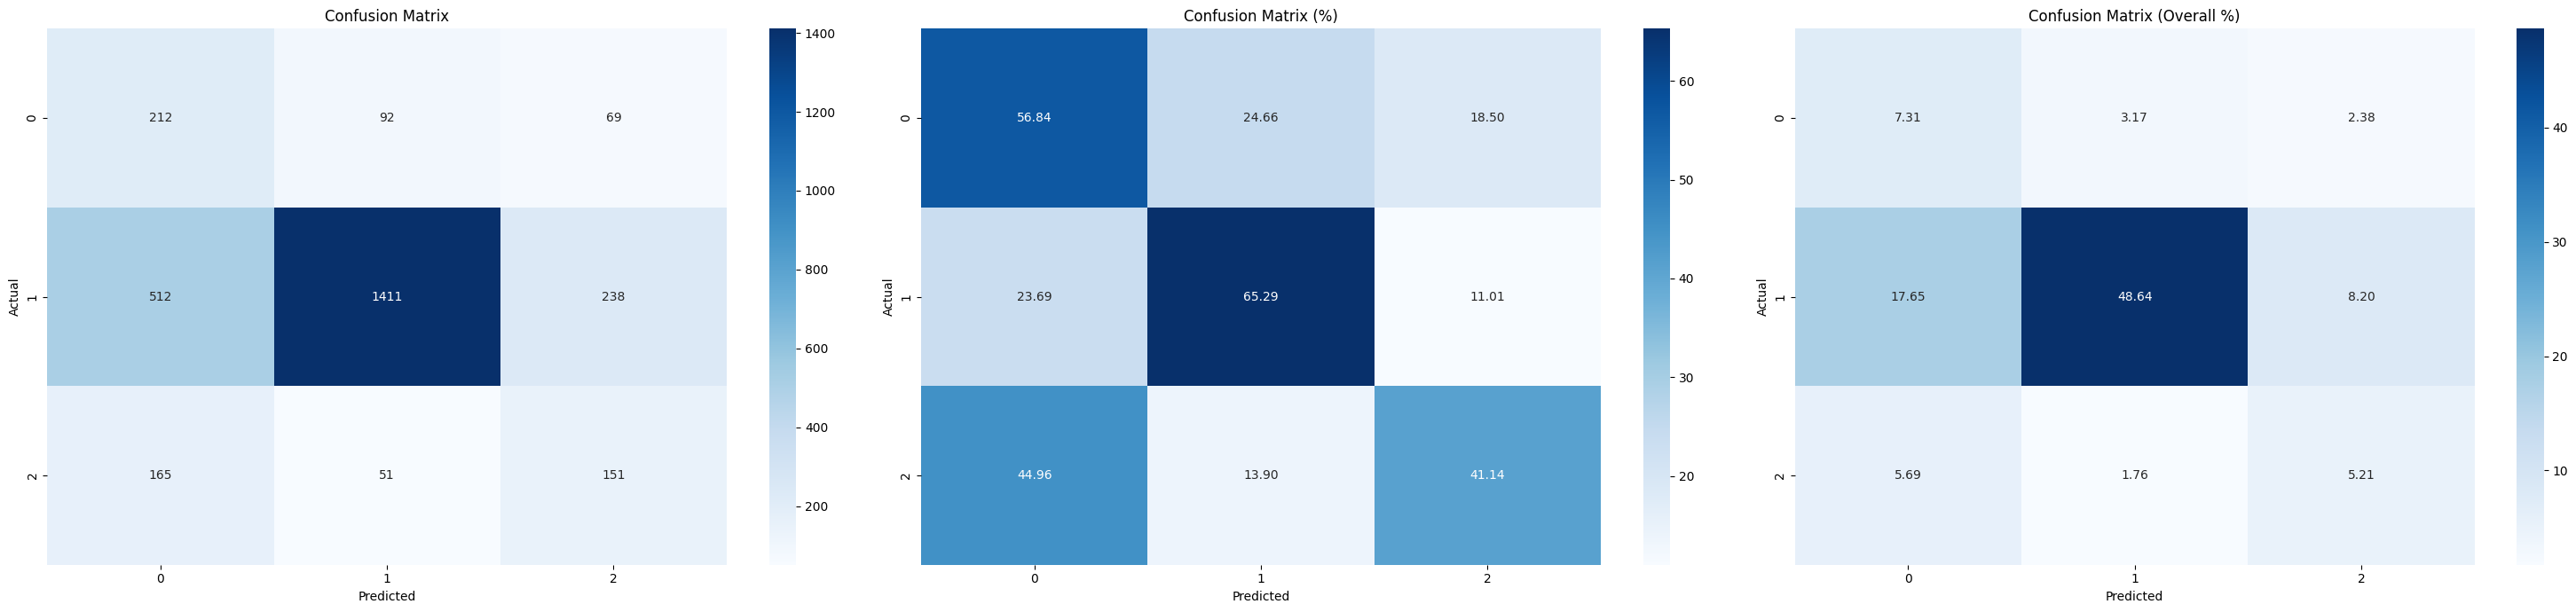

/tmp/ipykernel_83025/2671864123.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


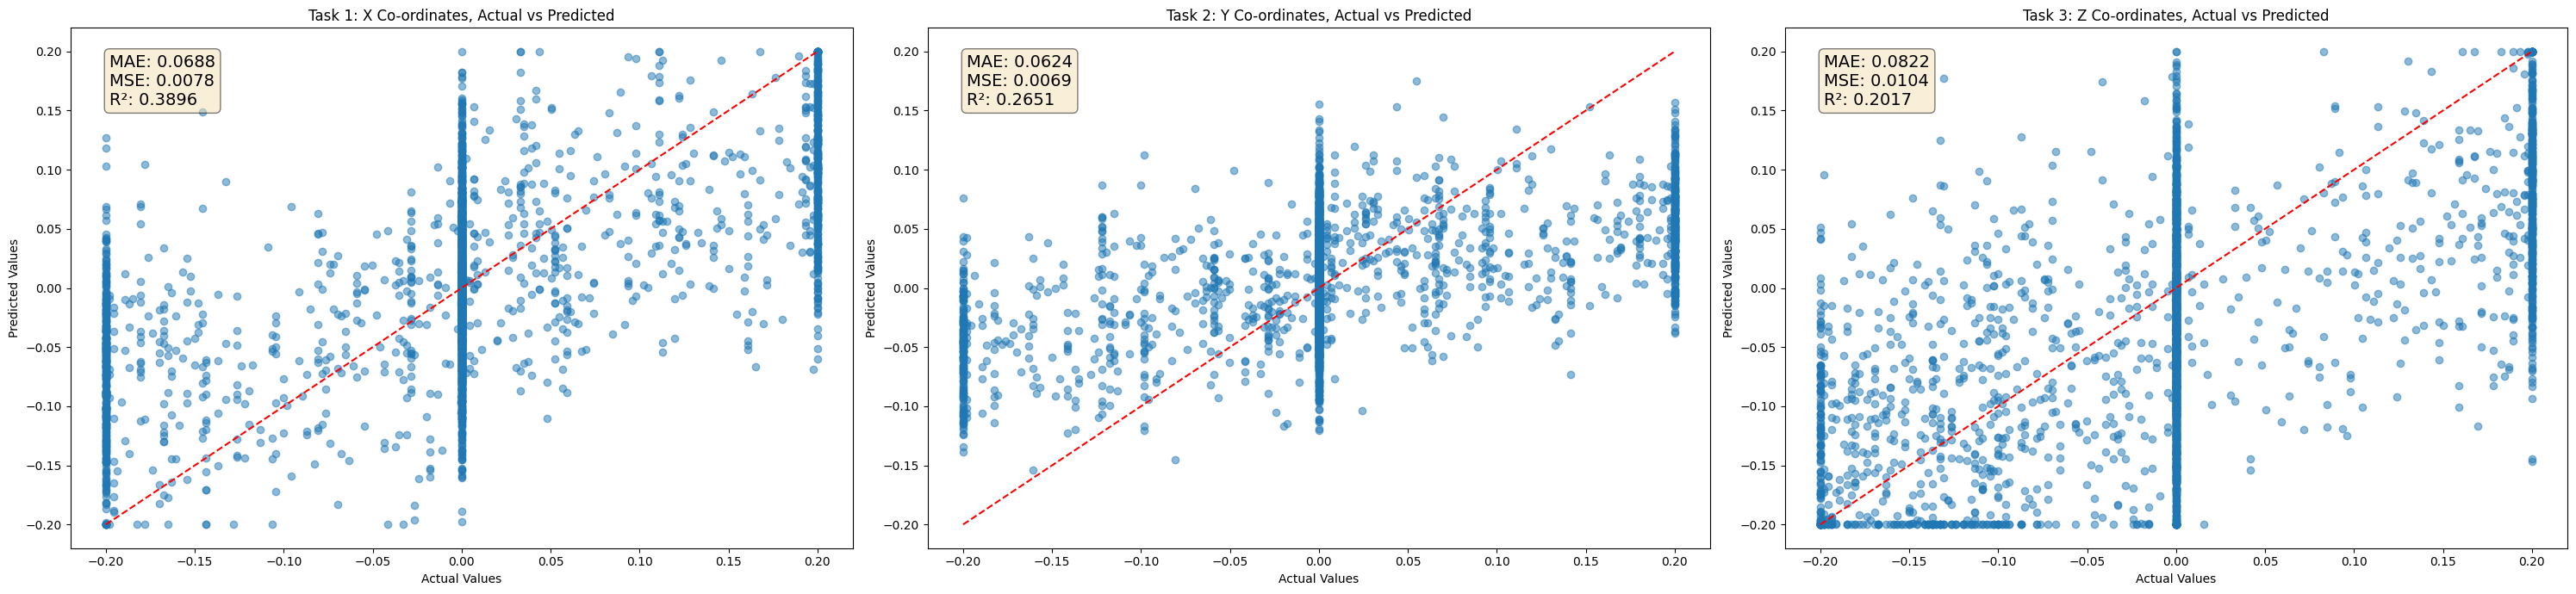

In [53]:
run_vae_evaluation(
    model_class=Final1,
    classification_checkpoint_path='./wandb/latest-run/files/agent_checkpoints/mdl_chkpnt_epoch_17.pt',
    regression_checkpoint_path='./wandb/latest-run/files/agent_checkpoints/mdl_chkpnt_epoch_20.pt',
    val_dataloader=final_val_dataloader,
    vae_model=vae_model,
    obs_encoder=final_obs_encoder,
    dense=final_dense,
    classification_save_path='final_1_classification_model.pt',
    regression_save_path='final_1_regression_model.pt',
    run_no_ensemble=False
)

### Question 3.b Assessing the suitability of self-supervised learning 
For the final two questions, you are required to assess the performance of the self-supervised + supervised head model and the end-to-end model that you have trained. Additionally, you are required to holistically evaluate whether self-supervised learning has been beneficial for this task.

#### Question 3.b.i Assessing the suitability of self-supervised learning (4 marks) 

##### Task
- In the code block below, evaluate the performance of the model you trained in question 3.a and the model you trained in question 1.c.i, using the test set. Additionally use the same metrics to train and evaluate the model that you used for question 1.c.i. Markers should be able to run the cell such that both models are run on the appropriate dataset. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

/tmp/ipykernel_83025/2671864123.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


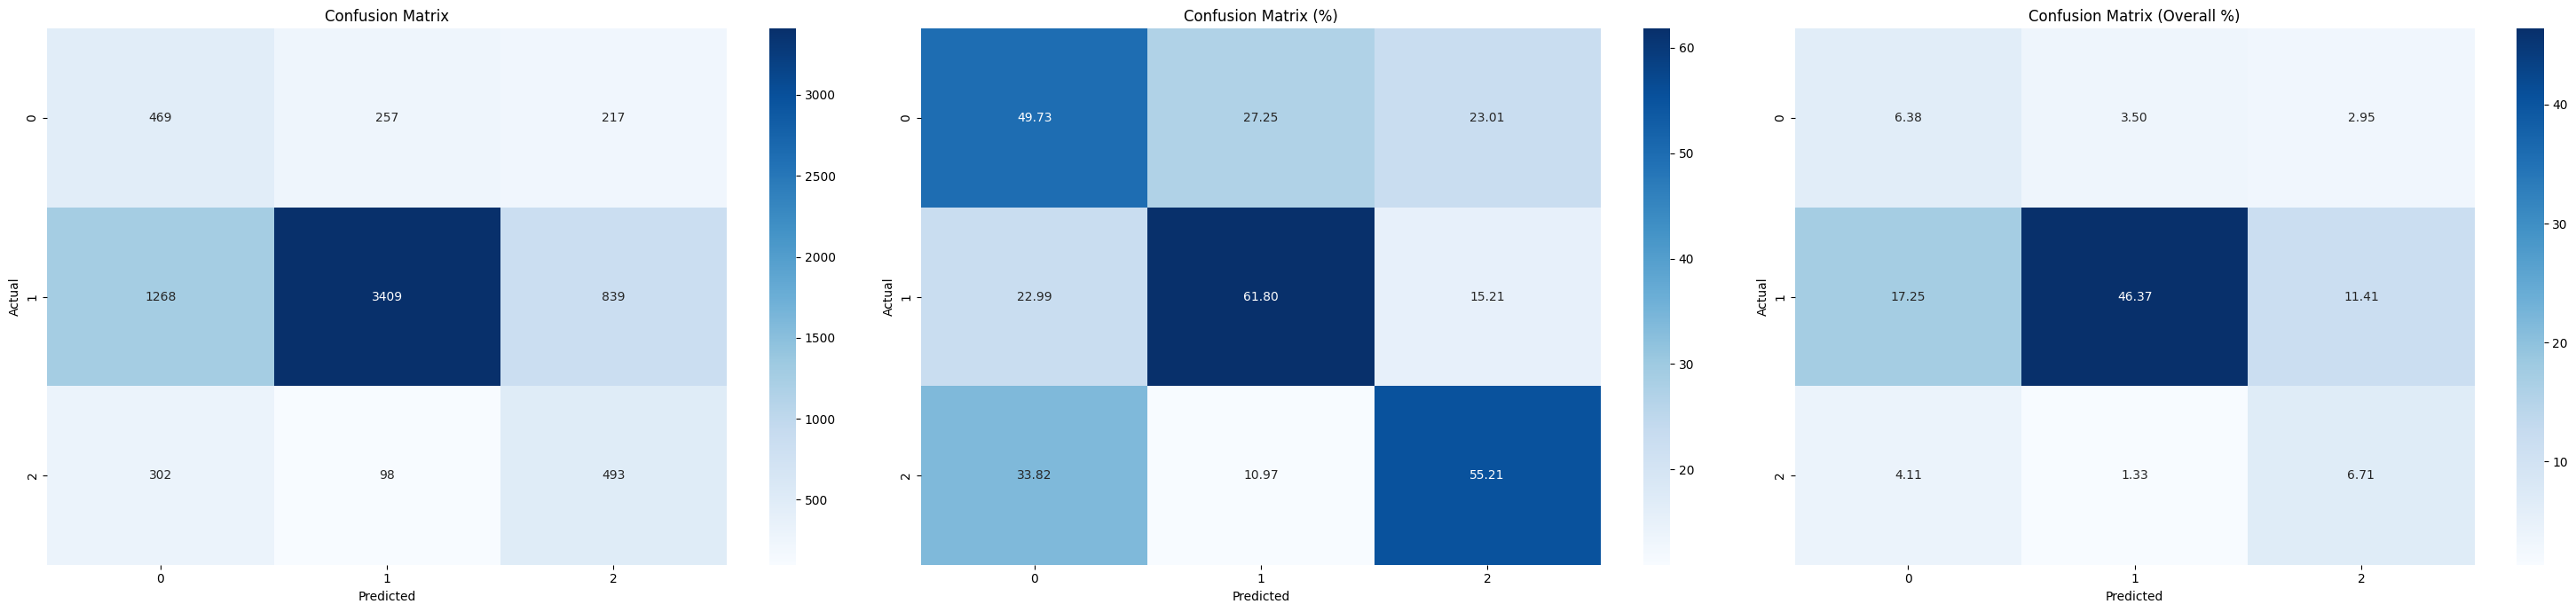

/tmp/ipykernel_83025/2671864123.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


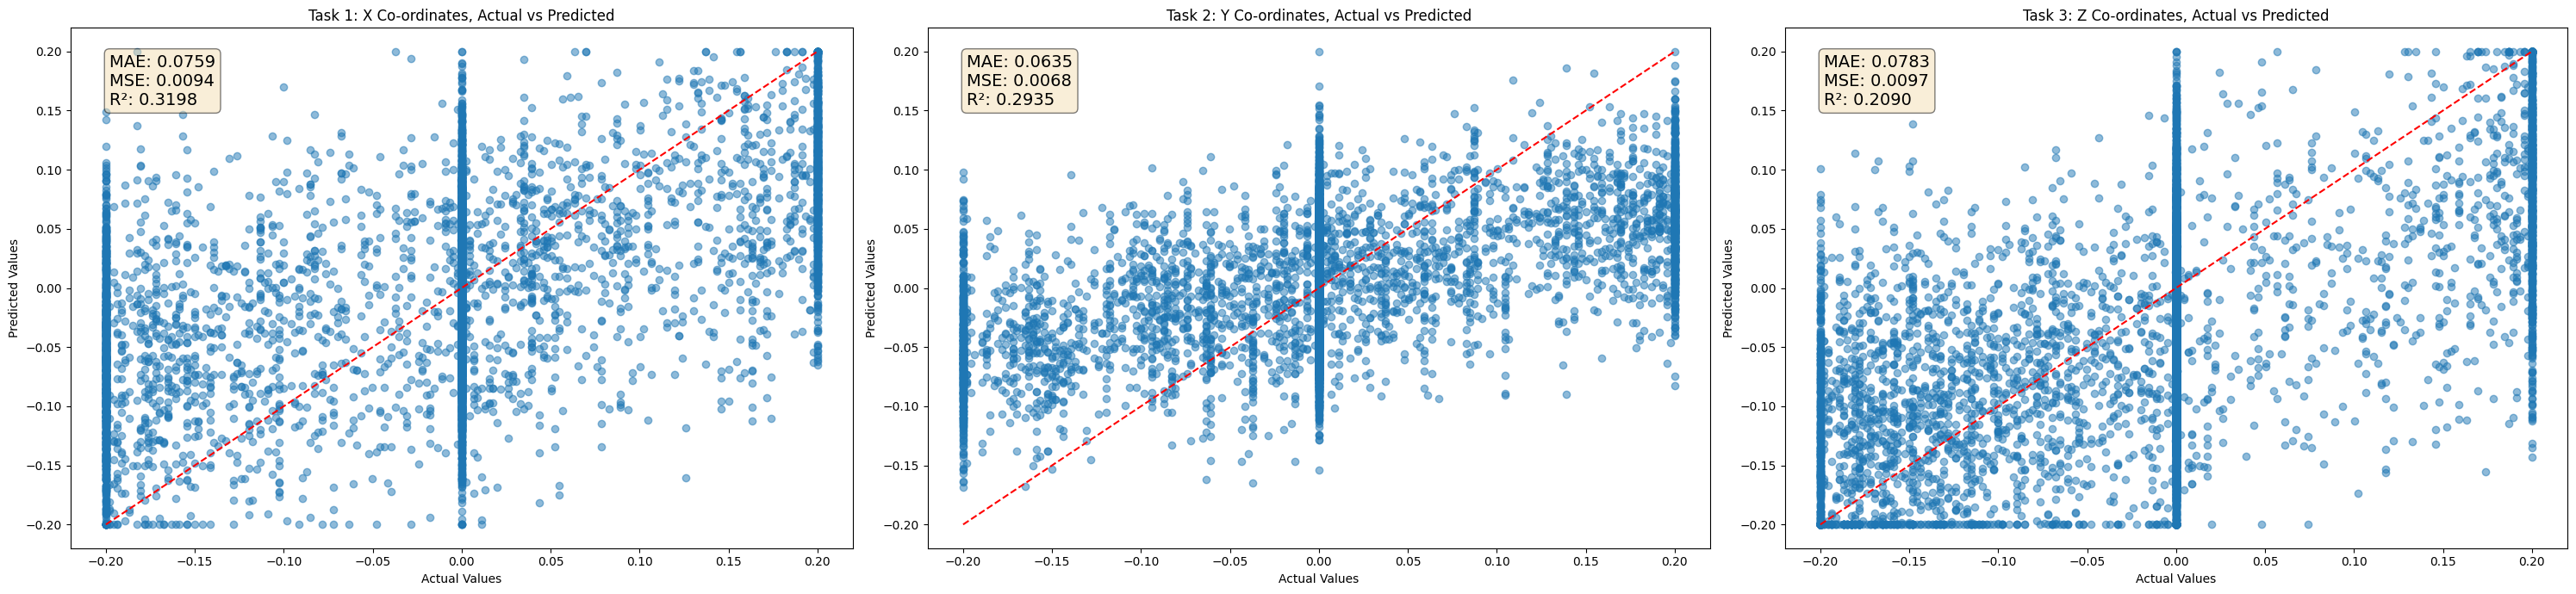

/tmp/ipykernel_83025/182827254.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


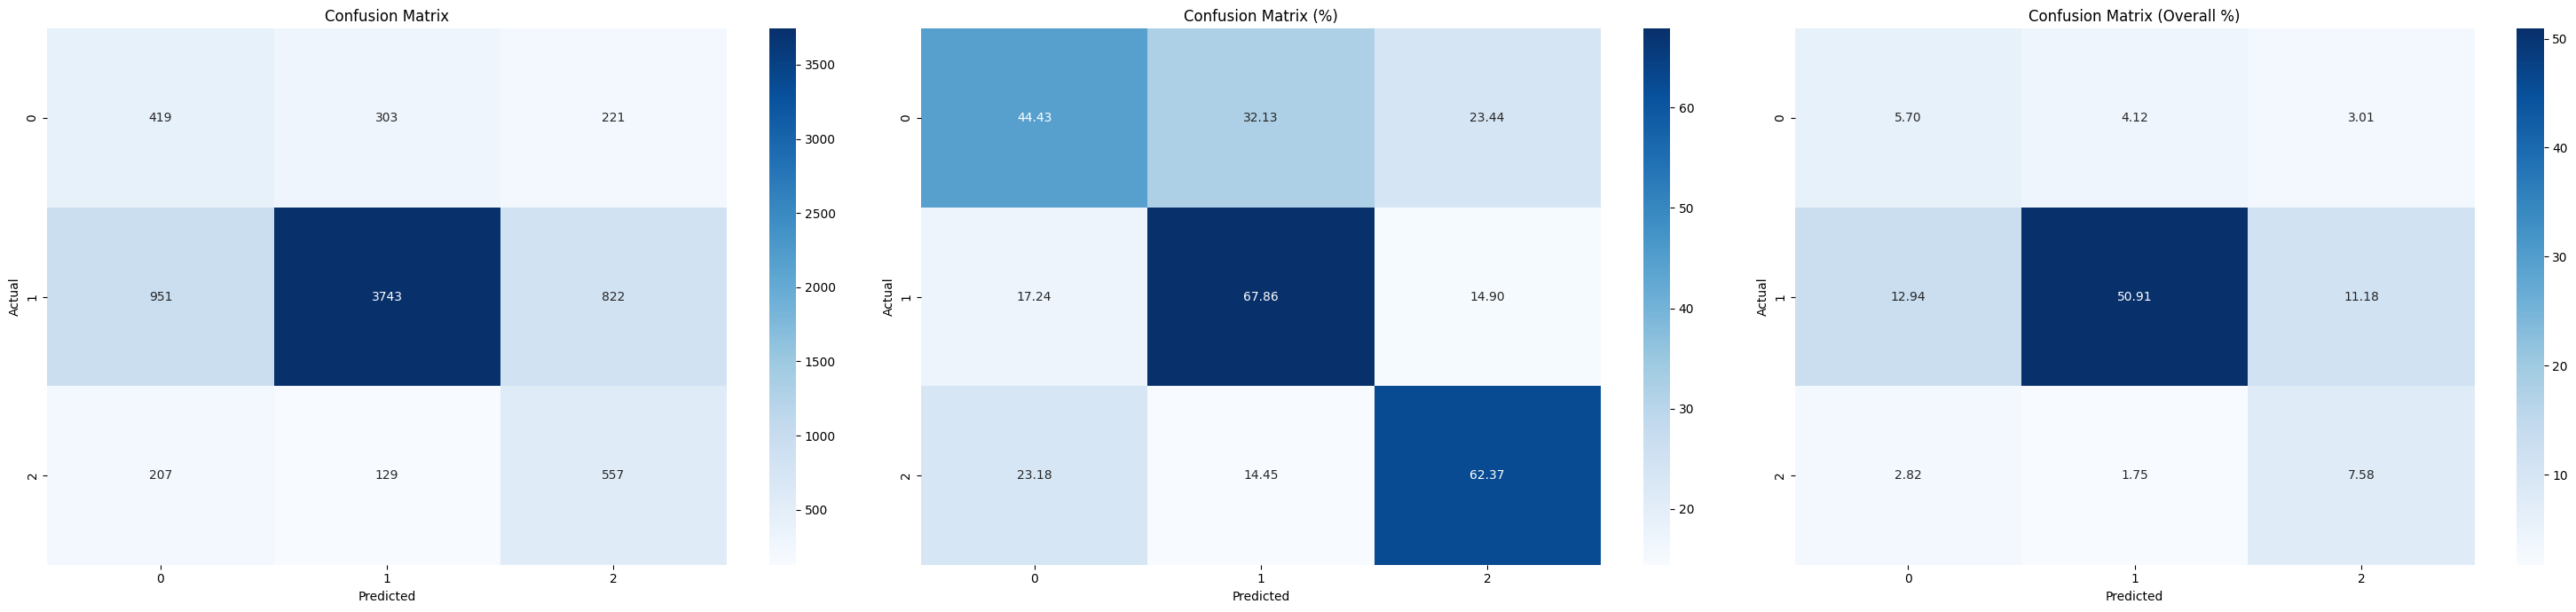

/tmp/ipykernel_83025/182827254.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


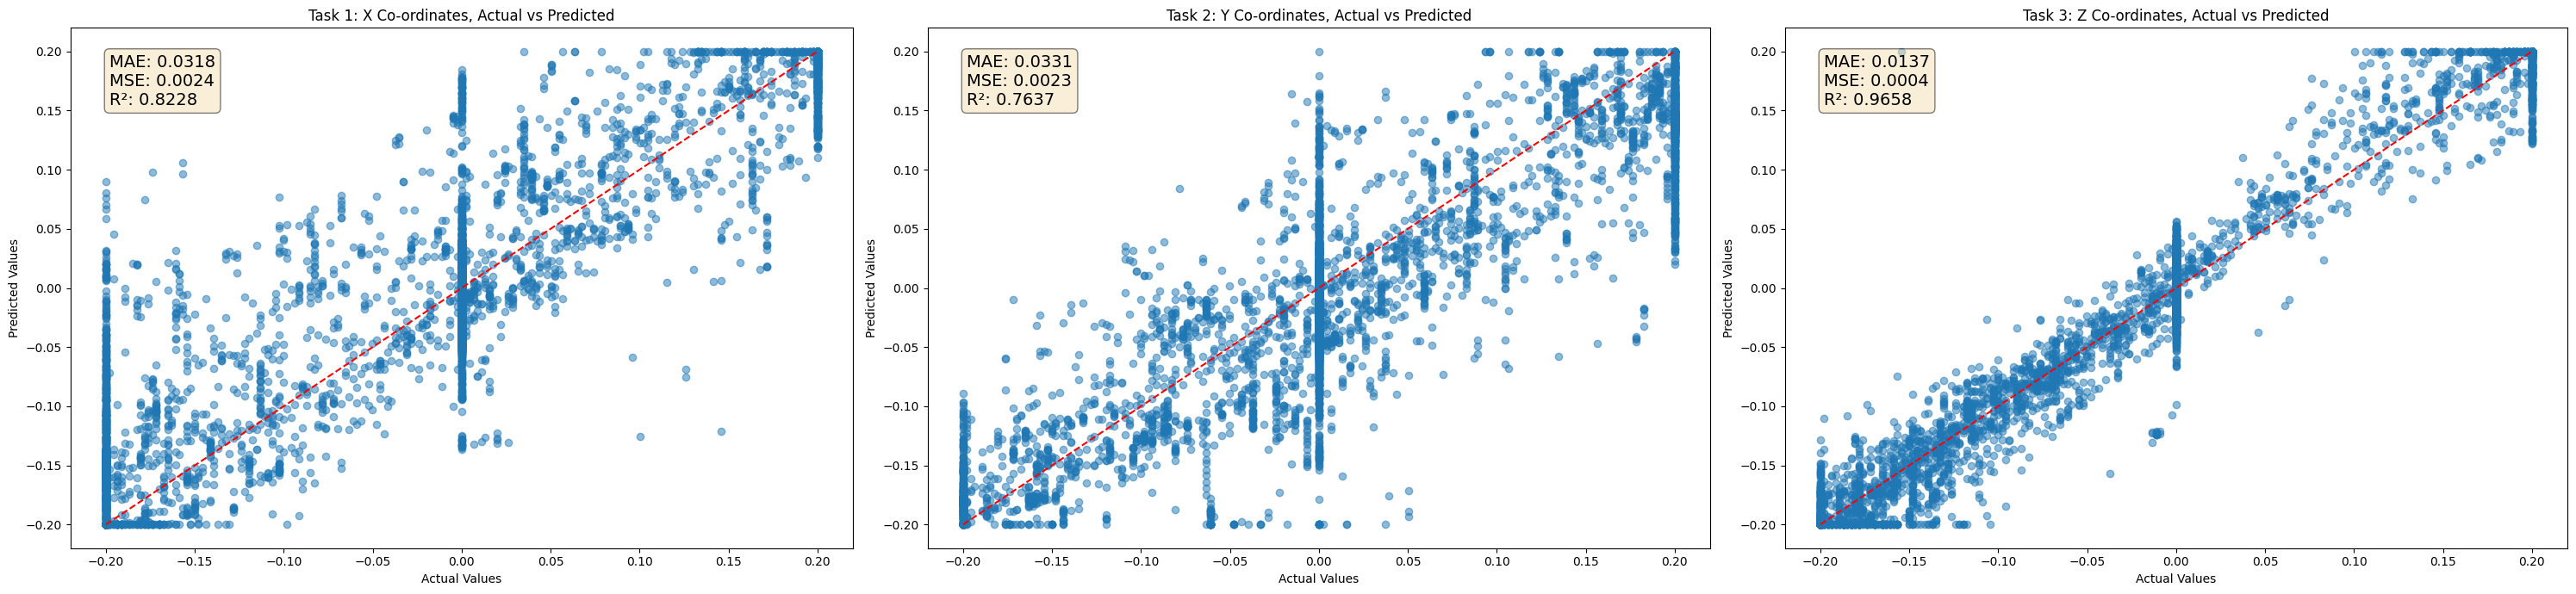

In [58]:
# ******* INSERT YOUR CODE HERE *******

display(HTML("<h1>Model with Self-Supervised VAE</h1>"))
run_vae_evaluation(
    model_class=Final1,
    classification_checkpoint_path='final_1_classification_model.pt',
    regression_checkpoint_path='final_1_regression_model.pt',
    val_dataloader=final_test_dataloader,  # Changed from final_val_dataloader to test_dataloader
    vae_model=vae_model,
    obs_encoder=final_obs_encoder,
    dense=final_dense,
    classification_save_path='final_1_classification_model.pt',
    regression_save_path='final_1_regression_model.pt',
    run_no_ensemble=False
)

display(HTML("<h1>Model without Self-Supervised VAE</h1>"))
run_evaluation(
    model_class=Improved1,
    classification_checkpoint_path='improved_classification_model.pt',
    regression_checkpoint_path='improved_regression_model.pt',
    val_dataloader=improved_test_dataloader, 
    image_encoder=improved_image_encoder, 
    obs_encoder=improved_obs_encoder,
    dense=improved_dense,
    save_classification_file='improved_classification_model.pt',
    save_regression_file='improved_regression_model.pt',
    run_no_ensemble=False
)

# ******* INSERT YOUR CODE HERE - END *******

#### Question 3.b.ii Justification (5 marks)

##### Task
- Conclude whether the self-supervised pre-training was beneficial for the task of predicting actions. Your answer should not solely focus on final performance but rather be nuianced and balance other model development considerations for example parameter count and speed of convergence. Also, if you believe the comparison between the model trained in question 3.a.i aganst the model trained in question 1.c.i is not _fair_, discuss further experiments which you would perform to reduce the bias in your conclusions. Provide __empirical evidence__ to support your conclusions. __0 marks__ will be awarded if empirical evidence is __not__ provided.

##### Answer

In this instance, using a VAE to create a latent space representation that replaces the images has not improved the results of the model. Only class 0 has a higher accuracy, otherwise all of the metrics are worse. However, the latent space from the VAE does show some promise. In particular, the VAE is able to cluster similar episodes together and within each episode, similar targets are clustered together. Adding an additional dimension, for time series, could see significant improvement in the explanatory power of the latent space. To properly compare this, the supervised model would also need to be upgraded to include the time series dimension as well.

In terms of technical performance, both models are able to converge quickly (within 20 epochs) and the separately trained VAE converges within 30 epochs. However, after the VAE has been trained and the parameters frozen, there are only 120 000 trainable parameters in the final model. Therefore, it is possible that a better VAE architecture can lead to a much quicker model. Having said that, the overall training process takes much longer when accounting for the training of the VAE and the supervised head together.

To improve the comparison, similar experiments could be run on the VAE model to those that have been run on the supervised model. In particular, it is possible that a further exploration of the run_vae_experiment function would show similar increases in performance of the regression variables and this could then be ensembled with the strongest classification model.

<table>
  <tr>
    <th>Metric</th>
    <th>Self-Supervised VAE Model with Supervised Head</th>
    <th>Fully Supervised Model</th>
  </tr>
    <tr>
    <td>Trainable Parameters</td>
    <td>124 102</td>
    <td>3 382 702</td>
  </tr>
  <tr>
    <td>Class 0 Accuracy</td>
    <td>49.73%</td>
    <td>44.43%</td>
  </tr>
  <tr>
    <td>Class 1 Accuracy</td>
    <td>61.80%</td>
    <td>67.86%</td>
  </tr>
  <tr>
    <td>Class 2 Accuracy</td>
    <td>55.21%</td>
    <td>62.37%</td>
  </tr>
  <tr>
    <td>Coordinate x R^2</td>
    <td>0.3198</td>
    <td>0.8228</td>
  </tr>
  <tr>
    <td>Coordinate y R^2</td>
    <td>0.2935</td>
    <td>0.7637</td>
  </tr>
  <tr>
    <td>Coordinate z R^2</td>
    <td>0.2909</td>
    <td>0.9658</td>
  </tr>
</table>

In conclusion, while the self-supervised pre-training using a VAE has not improved the final performance metrics for action prediction, it shows potential in clustering similar episodes and targets. The VAE model has significantly fewer parameters, which could lead to a more efficient model with further optimisation. However, the overall training time is longer due to the additional pre-training step. Further experiments, such as incorporating time series dimensions and exploring the run_vae_experiment function, are needed to fully assess the benefits and drawbacks of the self-supervised approach.